In [25]:
import sys,array
from ROOT import TFile, TCanvas
import root_numpy as rn
import numpy as np
import math
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{xfrac,fontspec,unicode-math}"]
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{mathastext}"]

font = 22   
legendfont = 18
matplotlib.rc('font',weight='bold')
matplotlib.rc('font',size=font)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']

In [26]:
stage = 'sel2'

f = 'DetSysFiles/BT_backgrounds_%s_' %stage

var_v = ['cv','stretchResp','altDeadChannels','deadSaturatedChannels','noPEnoise','noShortedResp',\
         'whitenoise','nospacecharge','dicharge','enhancedexttpcvis','lifetime10ms','dl0','dt0',\
         'birksrecomb','lightyeild']

# Stored in same order as above var_v; all are e20
pot_v = [4.63,4.53,4.34,4.53,2.38,4.53,4.52,3.98,4.58,4.60,3.82,3.81,3.62,4.54,2.84]

# CV sample, 3 that are way higher than expected, and one that is lower than expected
var_v = ['cv','lifetime10ms','dl0','whitenoise','noShortedResp']

pot_v = [ 4.63,3.82,3.81,4.52,4.53]
scale_v = [ 0.492/pot_v[i] for i in xrange(len(pot_v)) ]

df_v = []
df_cos_v = []; df_cc1pi0_v = []; df_nc1pi0_v = []; df_multpi0_v = []; df_cccex_v = []
df_nu_EM_v = []; df_oth_v = []; df_all_but_sig_v = []

w_v = []
cos_w_v = []; cc1pi0_w_v = []; nc1pi0_w_v = []; multpi0_w_v = []; cccex_w_v = []
nu_EM_w_v = []; oth_w_v = []; all_but_sig_w_v = []

for i in xrange(len(var_v)):
    
    f_new = f + str(var_v[i]) + '.root'
    
    t = rn.root2array(f_new,treename='tree')
    df = pd.DataFrame(t)

    df['mu_endx'] = np.where(df.mu_startx-df.vtx_x == 0, df.mu_endx, df.mu_startx)
    df['mu_endy'] = np.where(df.mu_starty - df.vtx_y == 0, df.mu_endy, df.mu_starty)
    df['mu_endz'] = np.where(df.mu_startz - df.vtx_z == 0, df.mu_endz, df.mu_startz)

    df['mu_startx'] = df['vtx_x']
    df['mu_starty'] = df['vtx_y']
    df['mu_startz'] = df['vtx_z']
    df_v.append(df)
    
    #print 'Shape of %s sample is %d ' % (var_v[i],df.shape[0])
    cos_v = df.query('bkgd_id == 1')
    cc1pi0_v = df.query('bkgd_id == 2')
    nc1pi0_v = df.query('bkgd_id == 3')
    multpi0_v = df.query('bkgd_id == 5')
    cccex_v = df.query('bkgd_id == 8 ')
    nu_EM_v = df.query('(bkgd_id == 4 or bkgd_id == 9 or bkgd_id == 10 or bkgd_id==11 or\
                          bkgd_id ==12 or bkgd_id ==13)')
    oth_v = df.query('bkgd_id == 0 or bkgd_id == 6 or bkgd_id == 7')
    all_but_sig_v = df.query('bkgd_id != 2')

    df_cos_v.append(cos_v)
    df_cc1pi0_v.append(cc1pi0_v)
    df_nc1pi0_v.append(nc1pi0_v)
    df_multpi0_v.append(multpi0_v)
    df_cccex_v.append(cccex_v)
    df_nu_EM_v.append(nu_EM_v)
    df_oth_v.append(oth_v)
    df_all_but_sig_v.append(all_but_sig_v)
    
    scale = scale_v[i]

    cos_w = [ scale for i in xrange(cos_v.shape[0]) ] 
    oth_w = [ scale for i in xrange(oth_v.shape[0]) ] 
    nc1pi0_w = [ scale for i in xrange(nc1pi0_v.shape[0]) ] 
    multpi0_w = [ scale for i in xrange(multpi0_v.shape[0]) ] 
    cccex_w = [ scale for i in xrange(cccex_v.shape[0]) ] 
    nu_EM_w = [ scale for i in xrange(nu_EM_v.shape[0]) ] 
    oth_w = [ scale for i in xrange(oth_v.shape[0]) ] 
    cc1pi0_w = [ scale for i in xrange(cc1pi0_v.shape[0]) ] 
    all_but_sig_w = [ scale for i in xrange(all_but_sig_v.shape[0]) ] 

    cos_w_v.append(cos_w)
    cc1pi0_w_v.append(cc1pi0_w)
    nc1pi0_w_v.append(nc1pi0_w)
    multpi0_w_v.append(multpi0_w)
    cccex_w_v.append(cccex_w)
    nu_EM_w_v.append(nu_EM_w)
    oth_w_v.append(oth_w)
    all_but_sig_w_v.append(all_but_sig_w)

    
df_bkgd_v = [df_cos_v,df_oth_v,df_nc1pi0_v,df_multpi0_v,df_cccex_v,df_nu_EM_v,df_cc1pi0_v,df_all_but_sig_v]
w_v = [cos_w_v,oth_w_v,nc1pi0_w_v,multpi0_w_v,cccex_w_v,nu_EM_w_v,cc1pi0_w_v,all_but_sig_w_v]

In [27]:
def makeAreaNormPlots(var,xmin,xmax,nbins=20,xlabel='',unit='cm'):

    bkgd_label_v = ['Cosmic','Other','NCpi0','Multpi0','CCCEx','FSEM','CC1pi0','AllBackgrounds']
 
    labels_tst = ['cv','lifetime10ms','dl0','whitenoise','noShortedResp']
    colors_tst = ['darkgoldenrod','turquoise','darkcyan','darkblue','salmon'] 

    # Loop through backgrounds; for each, inside plotting function loop through detsys and plot 
    # per variable per background
    for i in xrange(len(bkgd_label_v)):

        df_bkgd = df_bkgd_v[i]
        bkgd_label = bkgd_label_v[i]
        
        #if stage == 'sel2' and bkgd_label == 'Other':
        #    continue
        
        # Loop over variations
        fig,ax = plt.subplots(figsize=(8,6))
 
        print bkgd_label , len(colors_tst), len(df_bkgd)
        cv_v = df_bkgd[0]; lt_v = df_bkgd[1]; dl0_v = df_bkgd[2]; wn_v = df_bkgd[3]; noShort_v = df_bkgd[4]   

        counts, edges,_ = ax.hist([cv_v[var].values,lt_v[var].values,dl0_v[var].values,\
                        wn_v[var].values,noShort_v[var].values],bins=nbins,\
                        label=labels_tst,color=colors_tst,range=(xmin,xmax),histtype='step',\
                        normed=True,lw=3)
        handles,labels = ax.get_legend_handles_labels()

        #if unit == 'rad' or unit == 'asym' or var =='pi0_low_IP_w_vtx' or var =='pi0_high_IP_w_vtx' or\
        #    var == 'pi0_IP' or var == 'gamma_IP_w_vtx':
        #    plt.ylabel('Events / %0.2f %s '%(bin_width,unit),fontsize=font,weight='bold')
        #elif unit == 'empty':
        plt.ylabel('Events',fontsize=font,weight='bold')
        #elif unit.split('(')[0] == 'cos':
        #    plt.ylabel('Events / %0.2f'%bin_width,fontsize=font,weight='bold')
        #else:
        #    plt.ylabel('Events / %i %s '%(bin_width,unit),fontsize=font,weight='bold')

        plt.grid(True)
        plt.xlabel(xlabel,fontsize=font,weight='bold')
        plt.title('Variations for %s'%(str(bkgd_label)),fontsize=20)
        plt.xlim(xmin,xmax)

        #print var, bkgd_label
        lgd = plt.legend(handles=handles,fontsize=legendfont,loc='upper left',bbox_to_anchor=(1,1))    
        plt.savefig('Plots/DetSys_%s_AreaNorm_%s_%s.png'%(stage,var,bkgd_label),bbox_extra_artists=(lgd,),bbox_inches='tight')

In [32]:
def makeAbsNormPlots(var,xmin,xmax,nbins=20,xlabel='',unit='cm',cut=0):

    bkgd_label_v = ['Cosmic','Other','NCpi0','Multpi0','CCCEx','FSEM','CC1pi0','AllBackgrounds']
    labels_tst = ['cv','lifetime10ms','dl0','whitenoise','noShortedResp']
    colors_tst = ['darkgoldenrod','turquoise','darkcyan','darkblue','salmon'] 

    # Loop through backgrounds; for each, inside plotting function loop through detsys 
    for i in xrange(len(bkgd_label_v)):

        df_bkgd = df_bkgd_v[i]
        bkgd_label = bkgd_label_v[i]
        weights = w_v[i]
      
        cv_v = df_bkgd[0]; lt_v = df_bkgd[1]; dl0_v = df_bkgd[2]; wn_v = df_bkgd[3]; noShort_v = df_bkgd[4]   
        #print cv_v.shape[0], lt_v.shape[0], dl0_v.shape[0], wn_v.shape[0], noShort_v.shape[0]

        fig,ax = plt.subplots(figsize=(8,6))
        
        counts, edges,_ = ax.hist([cv_v[var].values,lt_v[var].values,dl0_v[var].values,\
                        wn_v[var].values,noShort_v[var].values],bins=nbins,weights=weights, \
                        label=labels_tst,color=colors_tst,range=(xmin,xmax),histtype='step',lw=3)
        handles,labels = ax.get_legend_handles_labels()
        plt.ylabel('Events',fontsize=font,weight='bold')
        plt.grid(True)
        plt.xlabel(xlabel,fontsize=font,weight='bold')
        plt.title('Variations for %s'%(str(bkgd_label)),fontsize=20)
        plt.xlim(xmin,xmax)
        #if var == 'nshrs':
        #    plt.yscale('log')
        
        #plt.ylim(3500,4000)
        if cut != 0:
            plt.axvline(cut,lw=2,ls='--',color='k',label='Cut value %d'%cut)
           
        #print var, bkgd_label
        lgd = plt.legend(handles=handles,fontsize=legendfont,loc='upper left',bbox_to_anchor=(1,1))    
        plt.savefig('Plots/DetSys_%s_AbsNorm_%s_%s.png'%(stage,var,bkgd_label),bbox_extra_artists=(lgd,),bbox_inches='tight')

In [ ]:
makeAreaNormPlots('nshrs',0,7,nbins=7,xlabel='Number of Reconstructed Showers',unit='empty')

In [ ]:
makeAreaNormPlots('mu_startx',0,260,nbins=11,xlabel='Candidate $\mu$ Track Start X [cm]')
makeAreaNormPlots('mu_starty',-110,110,nbins=11,xlabel='Candidate $\mu$ Track Start Y [cm]')
makeAreaNormPlots('mu_startz',0,1040,nbins=11,xlabel='Candidate $\mu$ Track Start Z [cm]')
makeAreaNormPlots('mu_endx',0,260,nbins=11,xlabel='Candidate $\mu$ Track End X [cm]')
makeAreaNormPlots('mu_endy',-120,120,nbins=11,xlabel='Candidate $\mu$ Track End Y [cm]')
makeAreaNormPlots('mu_endz',0,1040,nbins=11,xlabel='Candidate $\mu$ Track End Z [cm]')

makeAreaNormPlots('mu_phi',-3.14,3.14,nbins=11,xlabel='Candidate $\mu$ Track $\\phi$ [rad]',unit='rad')
makeAreaNormPlots('mu_angle',-1,1,nbins=11,xlabel='Candidate $\mu$ Track cos($\\theta$)',unit='empty')
makeAreaNormPlots('mu_len',0,600,nbins=11,xlabel='Contained Candidate $\mu$ Track Length [cm]')
makeAreaNormPlots('mult',0,7,nbins=7,xlabel='Observed Vertex Multiplicity',unit='empty')

In [ ]:
makeAreaNormPlots('gamma_E',0,425,nbins=12,xlabel='Clustered Tagged Shower Energy [MeV]',unit='MeV')
makeAreaNormPlots('gamma_RL',3.5,60,nbins=12,xlabel='Conversion Distance of Shower Candidate [cm]')
makeAreaNormPlots('gamma_IP_w_vtx',0,10,nbins=12,xlabel='Tagged Shower Impact Parameter with Vertex [cm]')

makeAreaNormPlots('gamma_pdg',-220,220,nbins=40,xlabel='Candidate Shower True PDG',unit='empty')
makeAreaNormPlots('gamma_perfect_clustering_E',0,700,nbins=11,xlabel='Perfect Clustering E [MeV]',unit='empty')
makeAreaNormPlots('gamma_cw_purity',0,1,nbins=11,xlabel='Shower Purity',unit='empty')
makeAreaNormPlots('gamma_cw_complete',0,1,nbins=11,xlabel='Shower Completeness',unit='empty')

makeAreaNormPlots('flash_y_center',-120,120,nbins=11,xlabel='Flash Y Center',unit='[cm]')
makeAreaNormPlots('flash_z_center',0,1040,nbins=11,xlabel='Flash Z Center',unit='[cm]')
makeAreaNormPlots('flash_pe',0,15000,nbins=11,xlabel='Number Flash PE',unit='#PE')
makeAreaNormPlots('flash_time',3,5,nbins=11,xlabel='Flash Time wrt Trigger [us]',unit='us')

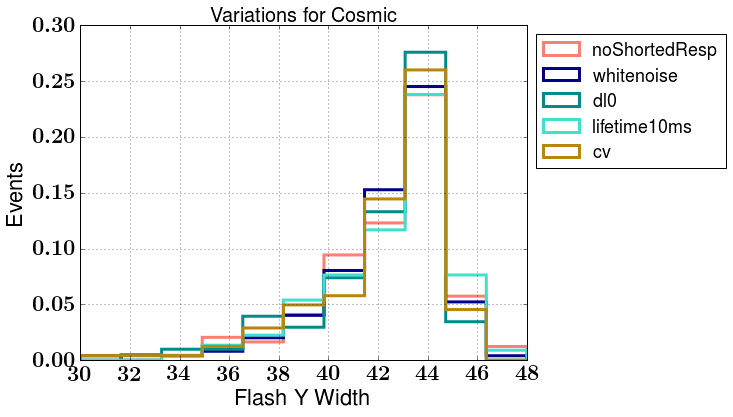

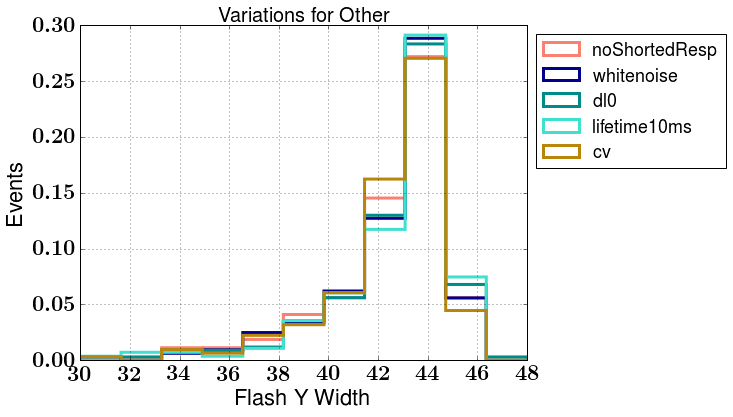

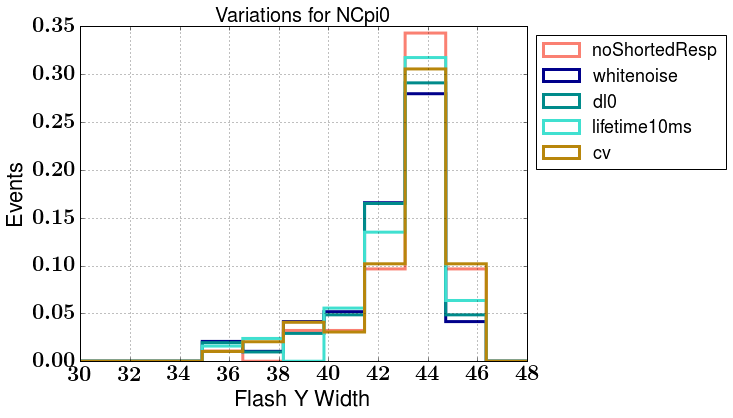

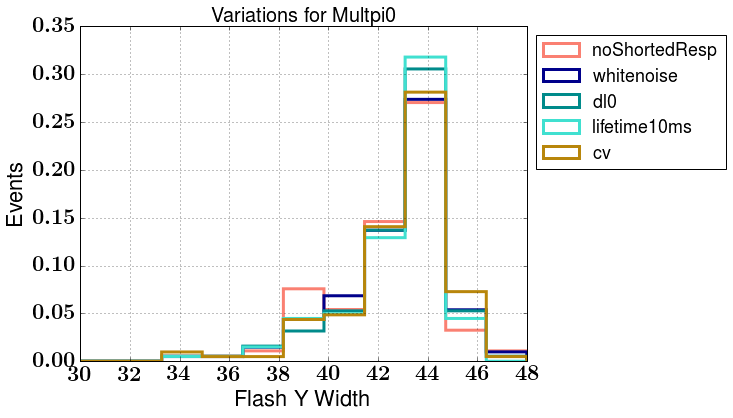

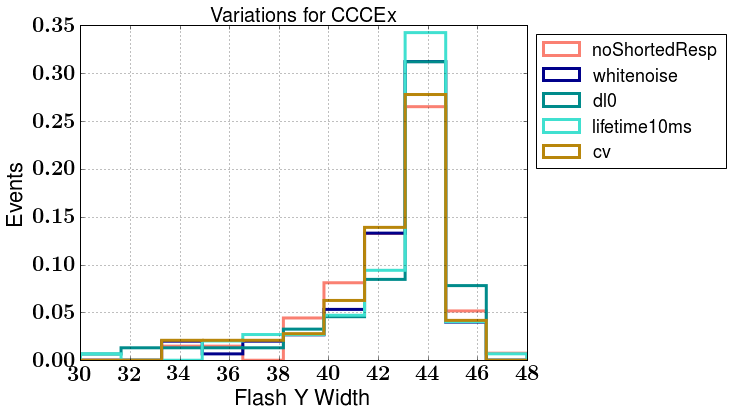

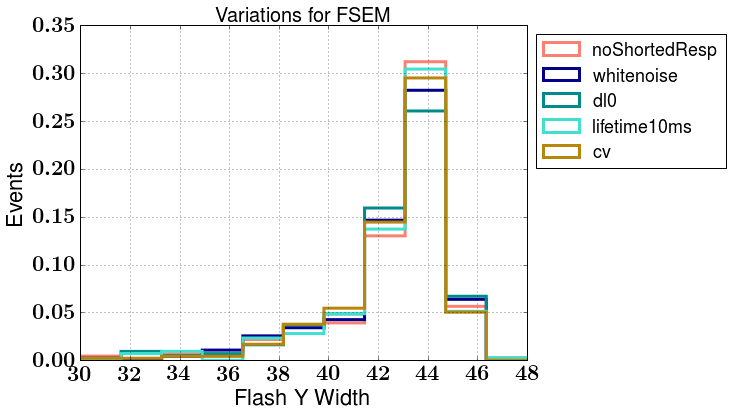

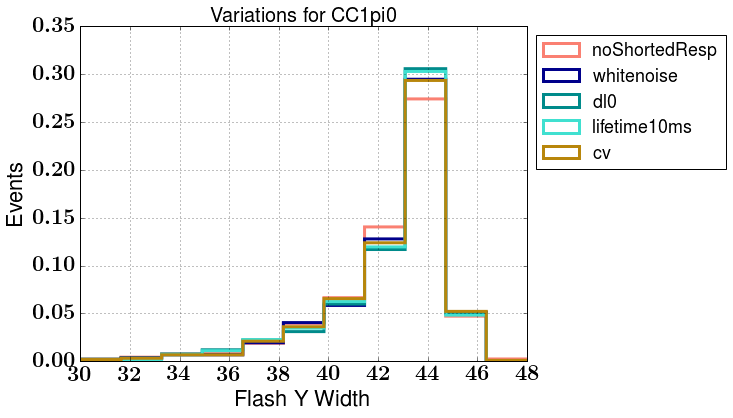

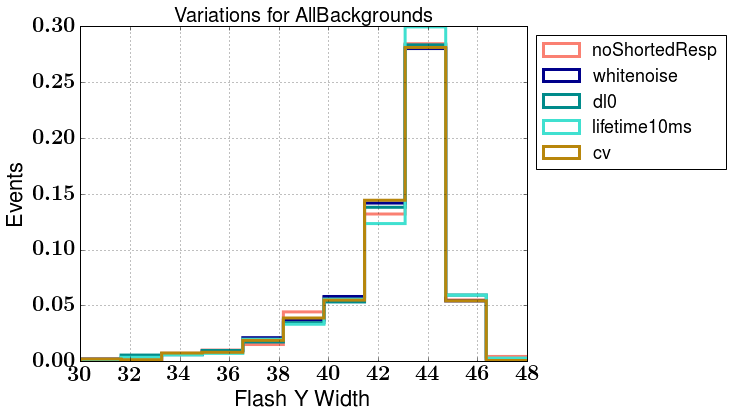

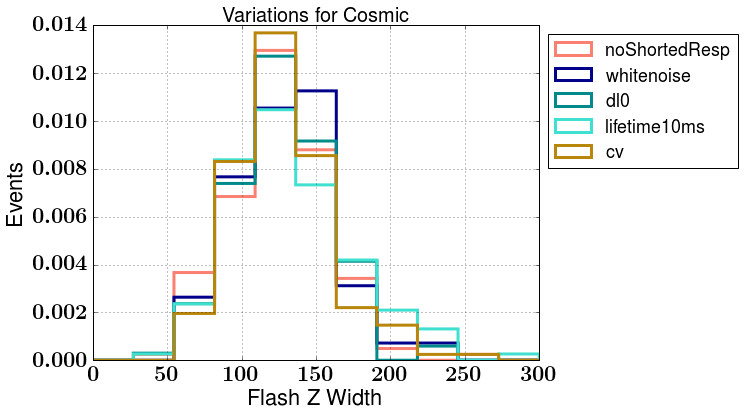

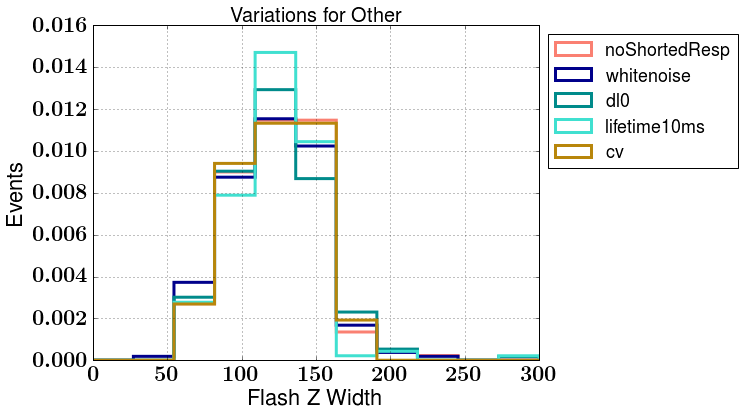

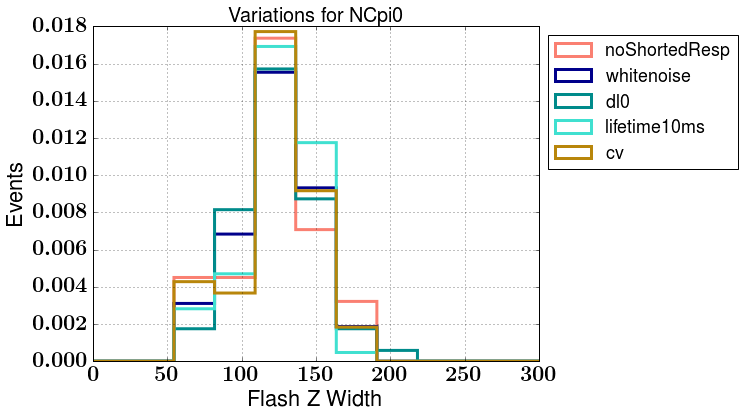

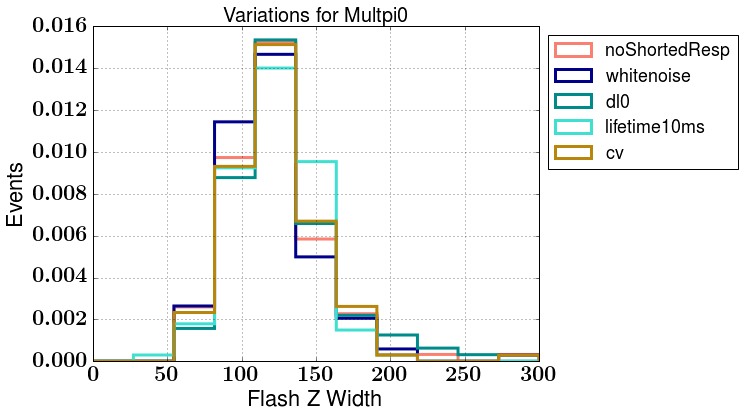

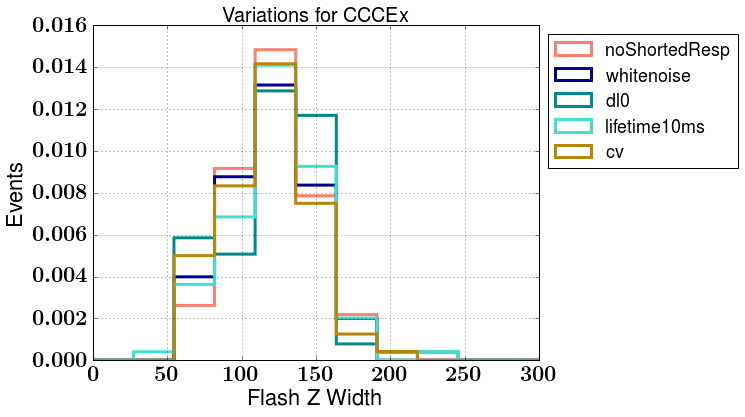

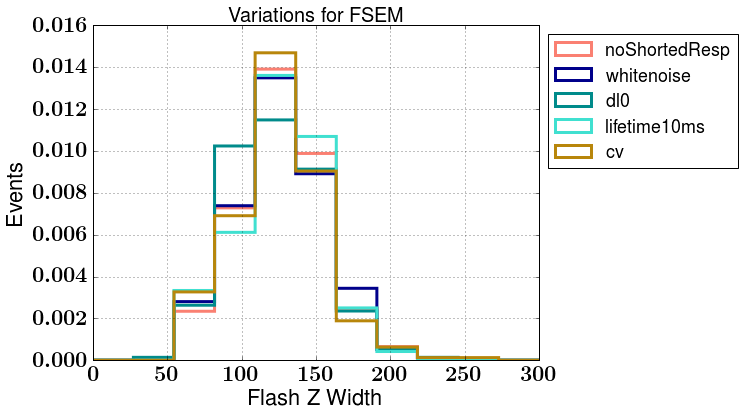

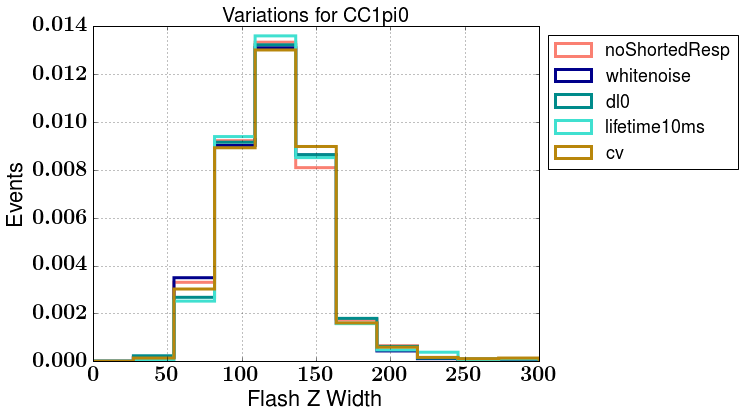

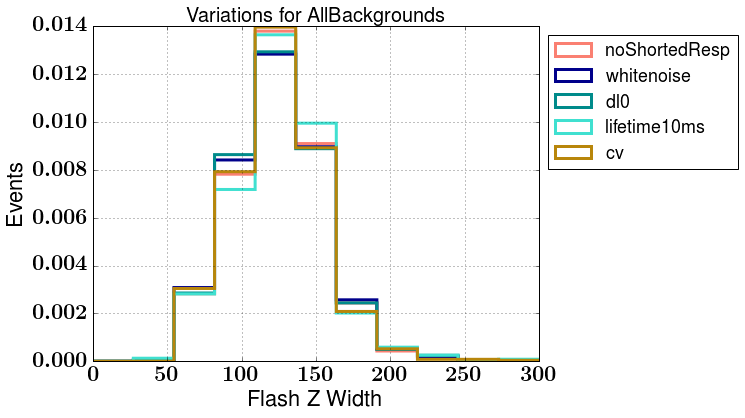

In [208]:
makeAreaNormPlots('flash_y_width',30,48,nbins=11,xlabel='Flash Y Width',unit='[cm]')
makeAreaNormPlots('flash_z_width',0,300,nbins=11,xlabel='Flash Z Width',unit='[cm]')

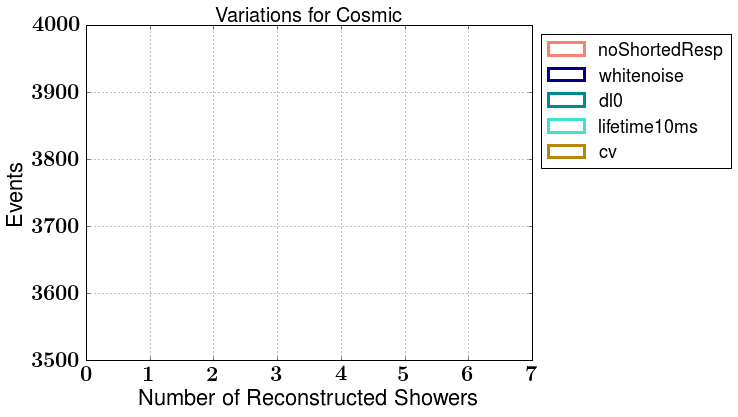

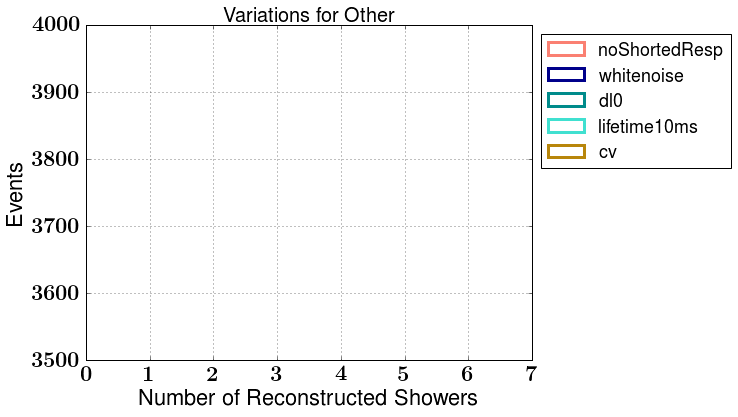

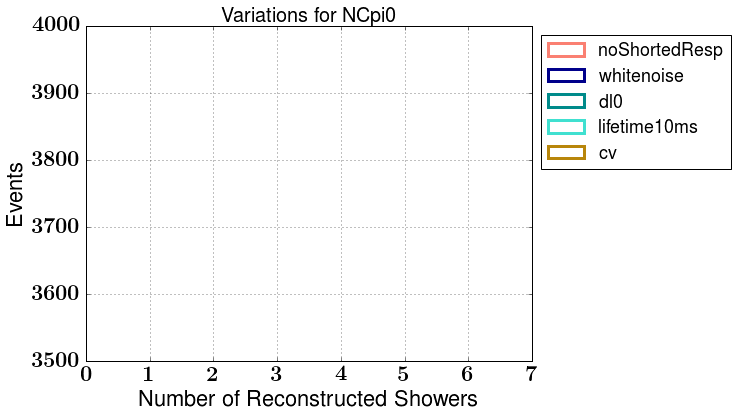

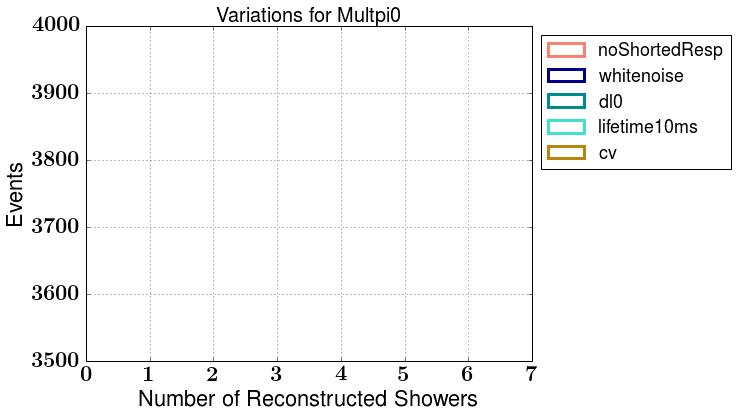

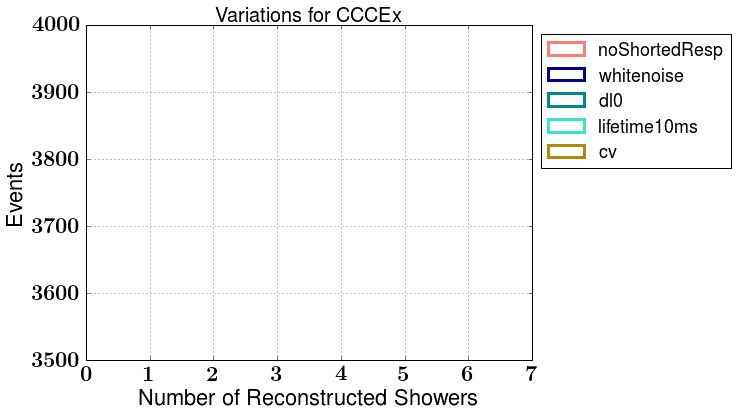

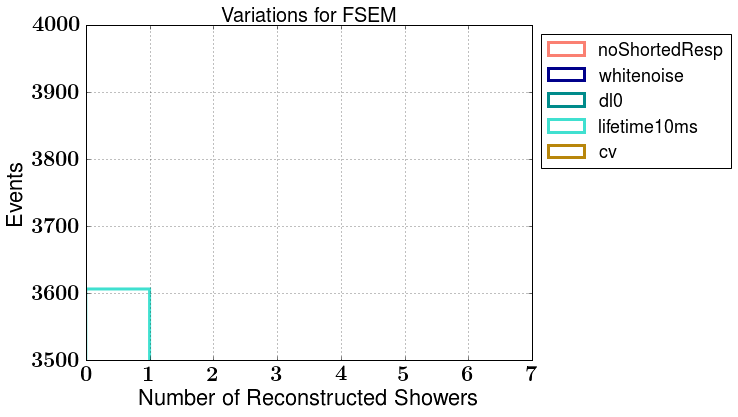

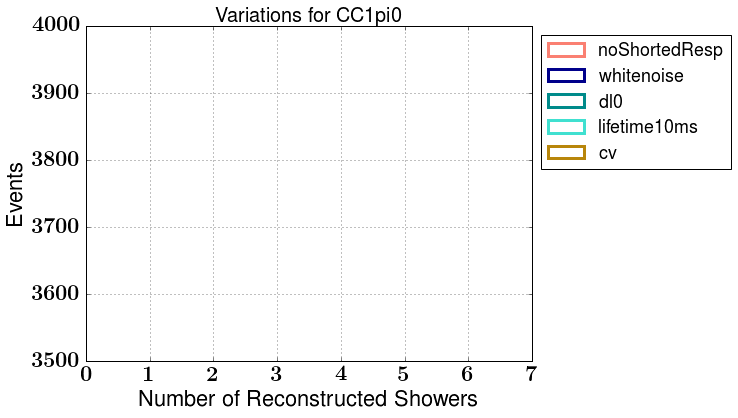

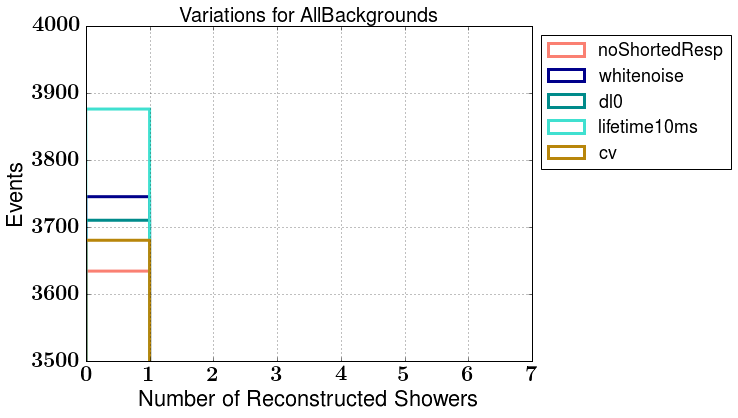

In [33]:
makeAbsNormPlots('nshrs',0,7,nbins=7,xlabel='Number of Reconstructed Showers',unit='empty')

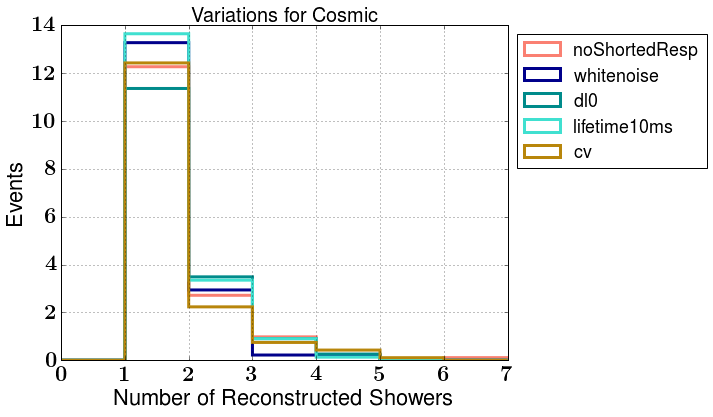

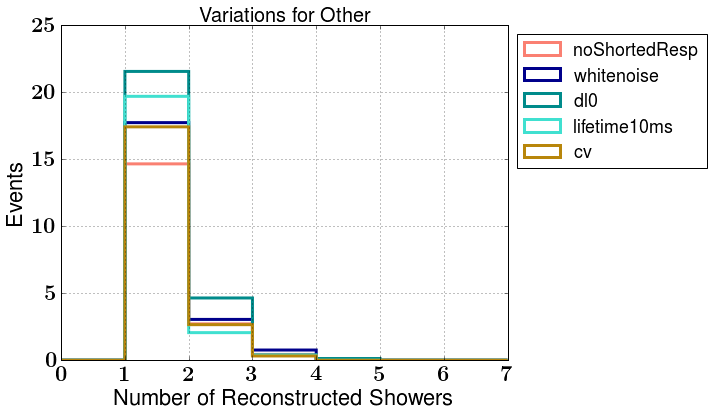

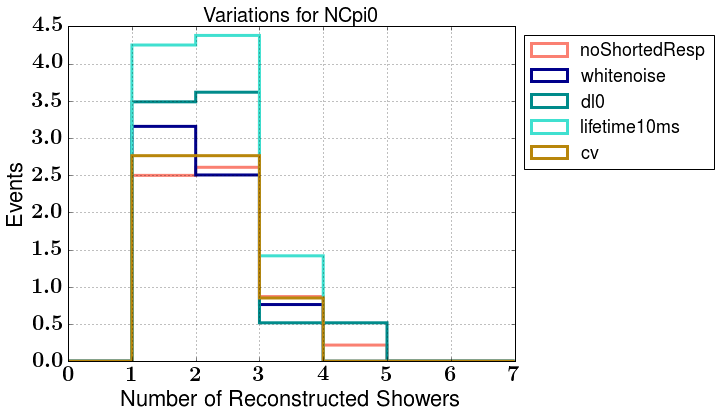

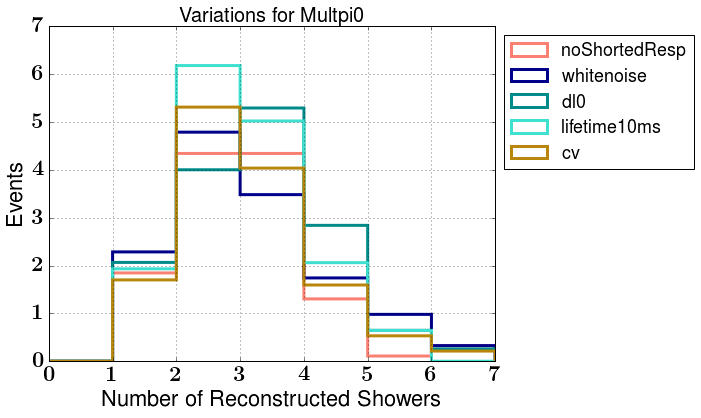

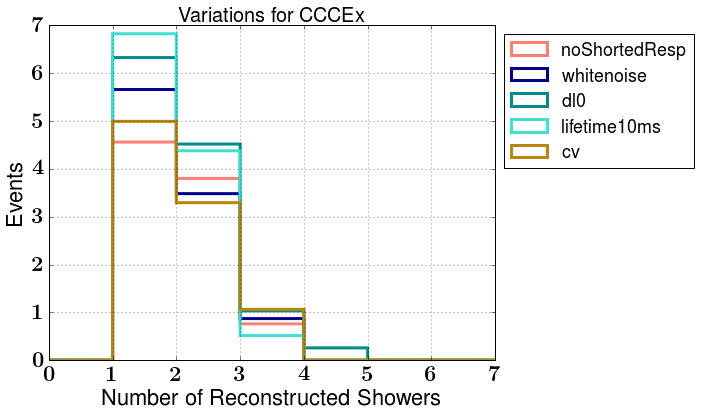

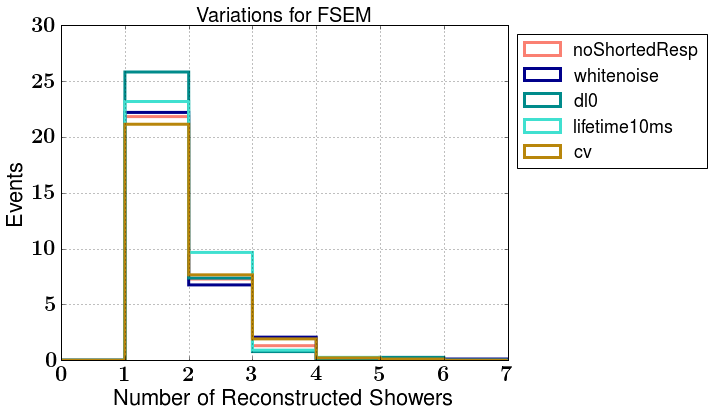

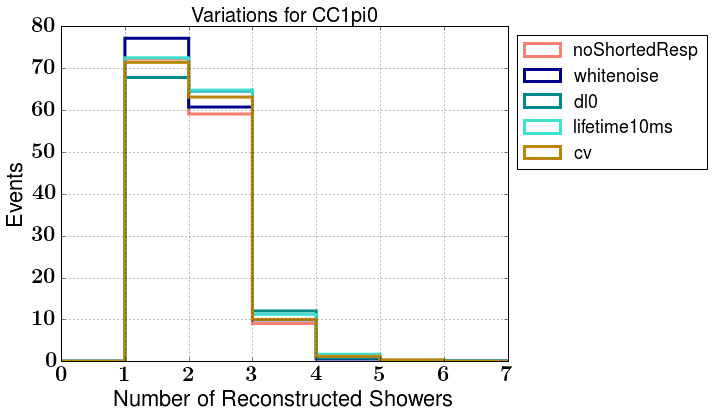

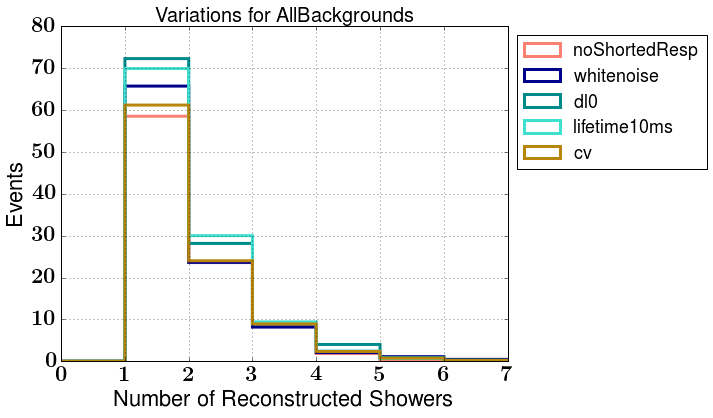

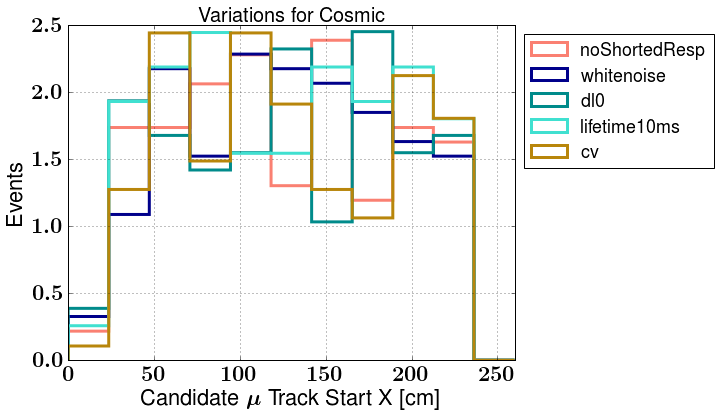

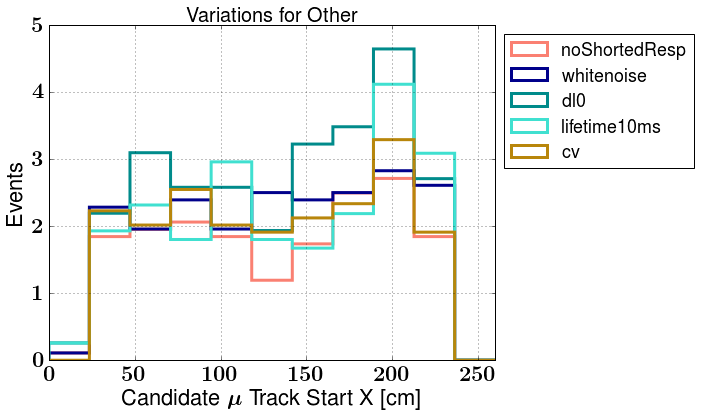

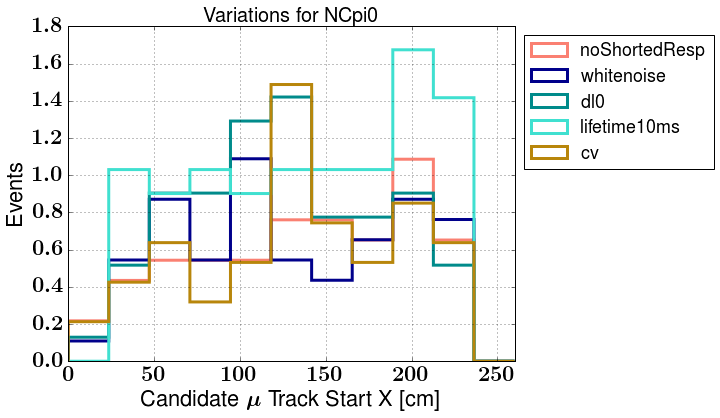

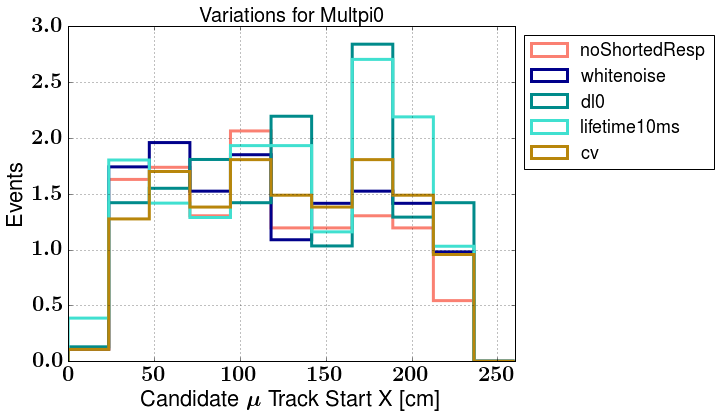

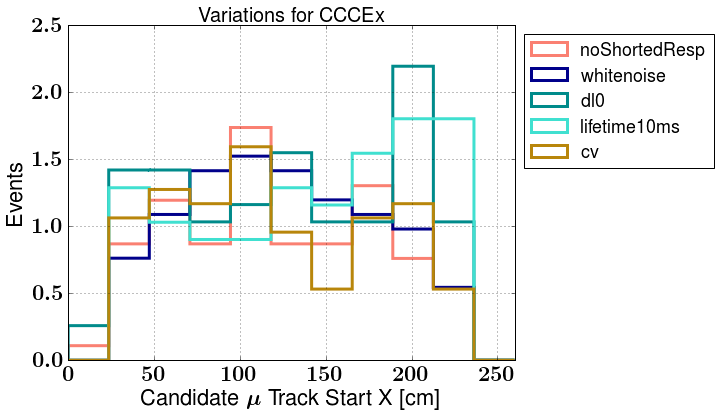

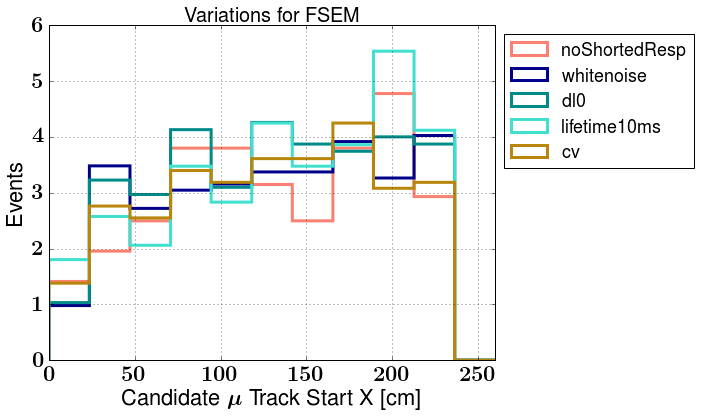

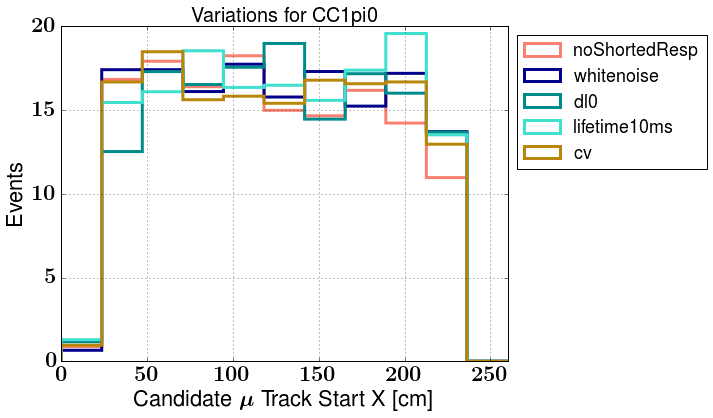

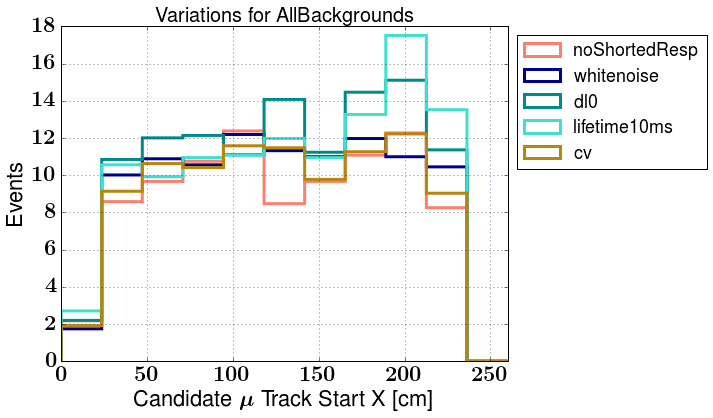

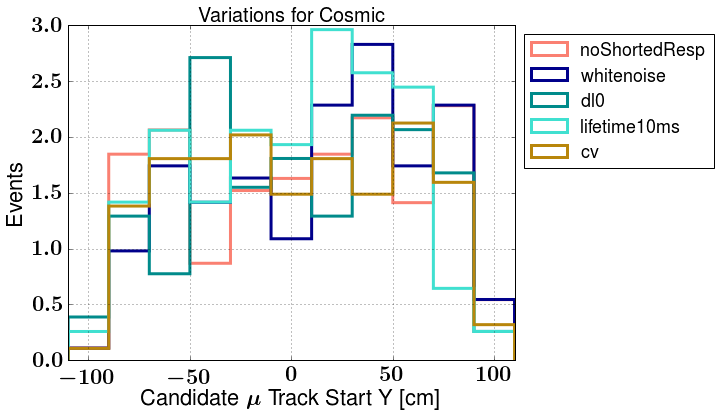

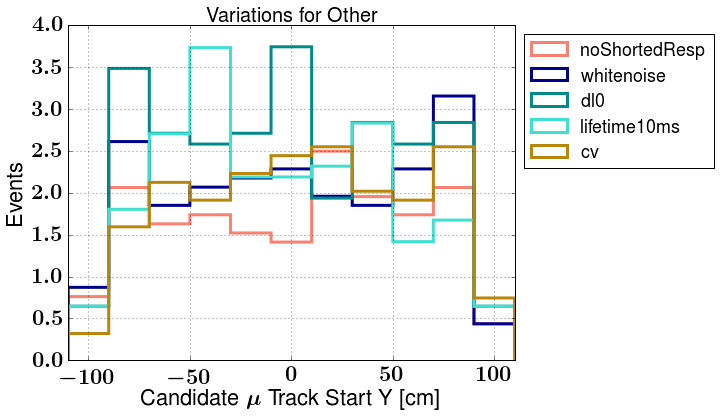

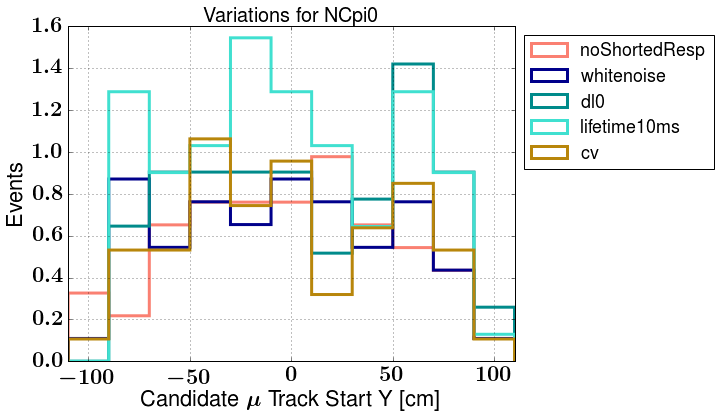

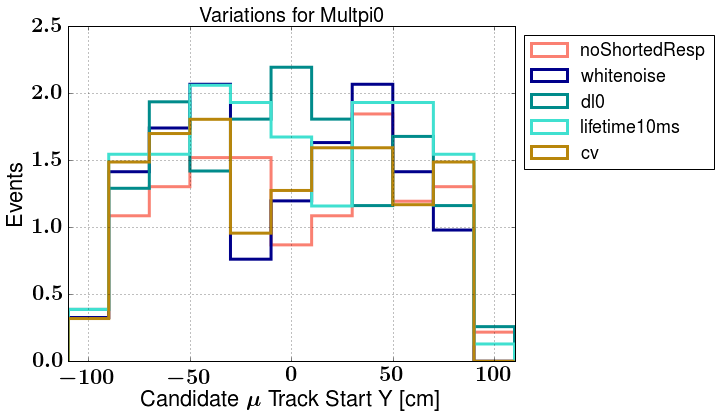

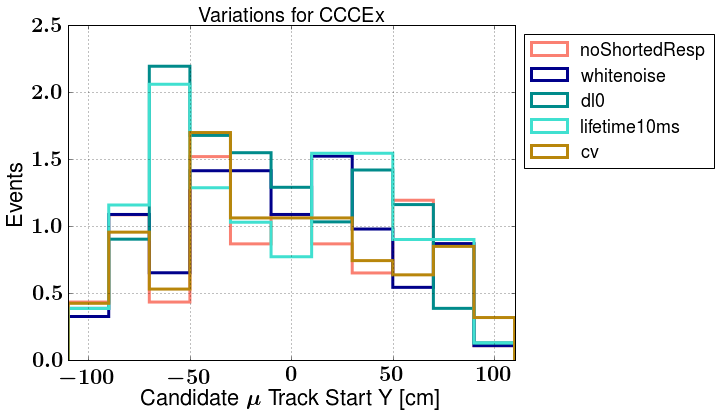

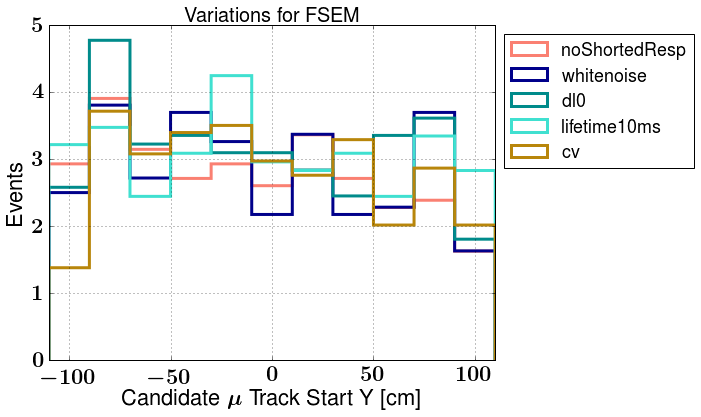

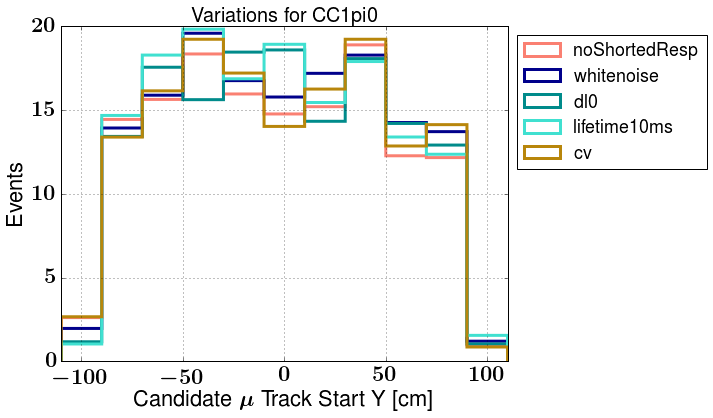

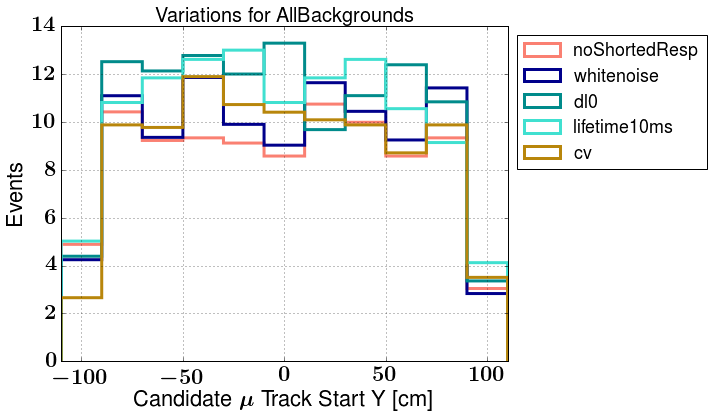

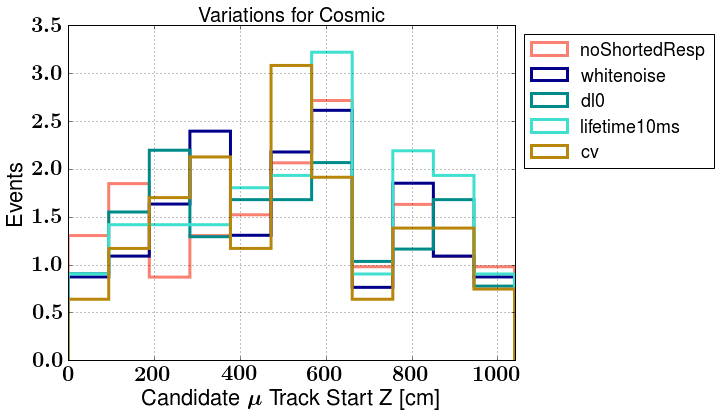

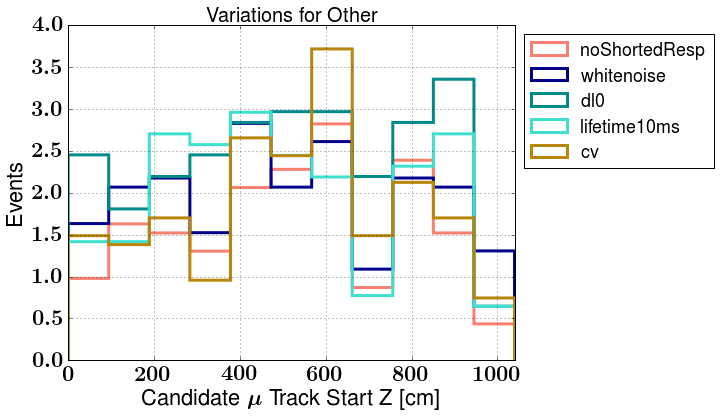

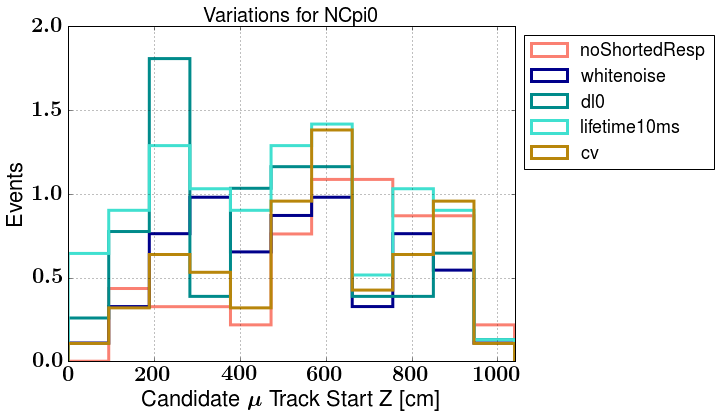

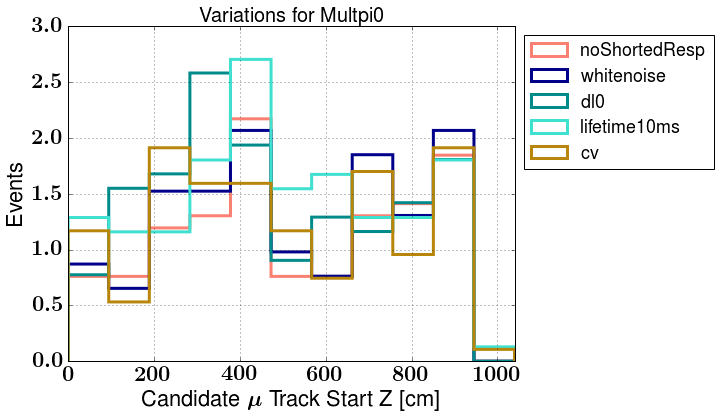

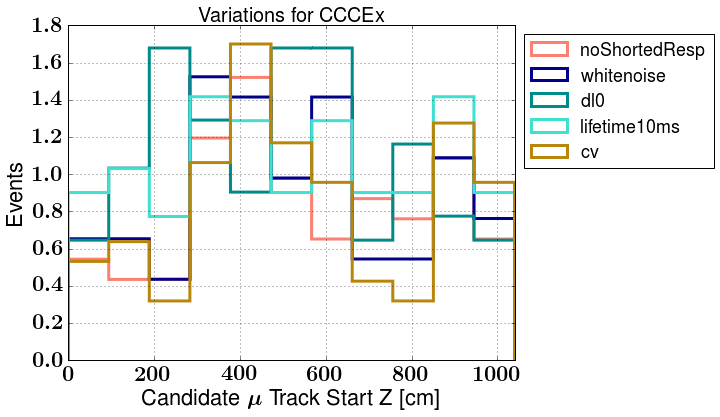

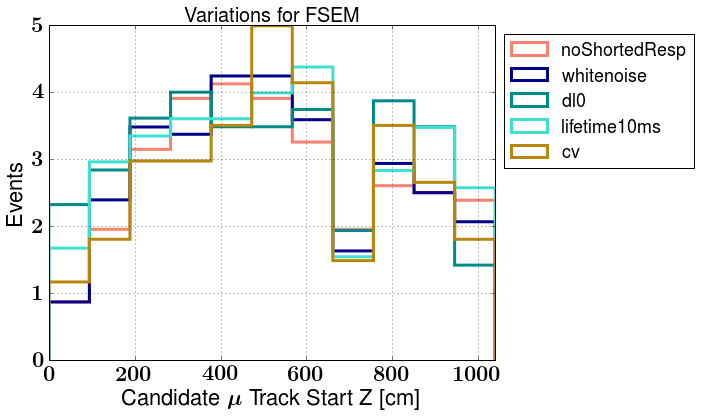

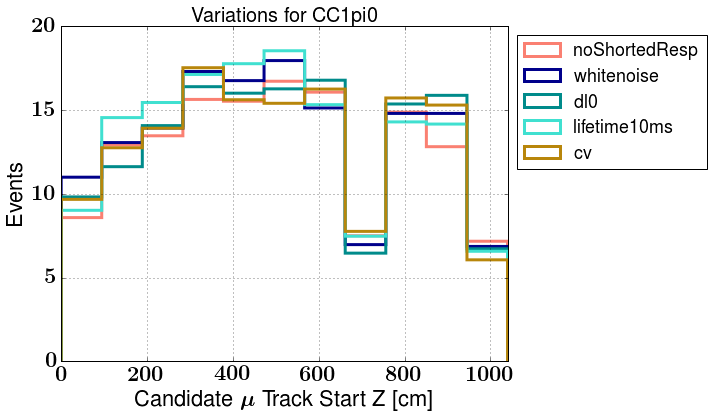

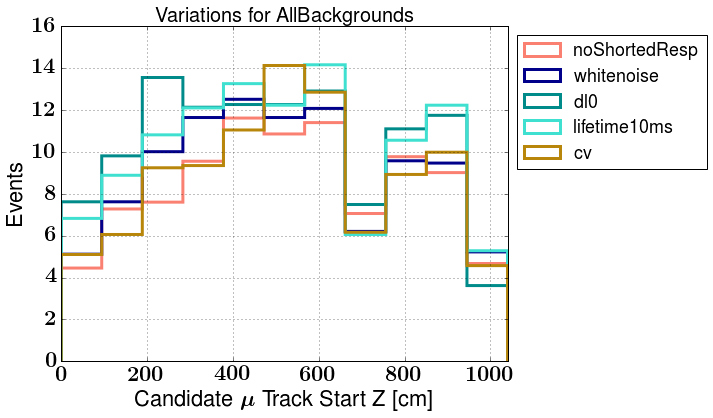

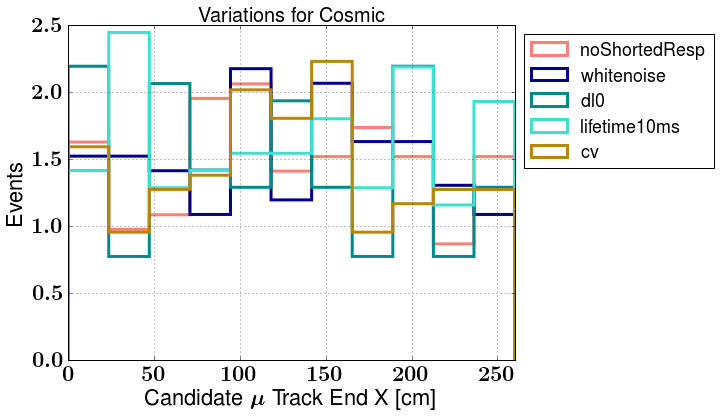

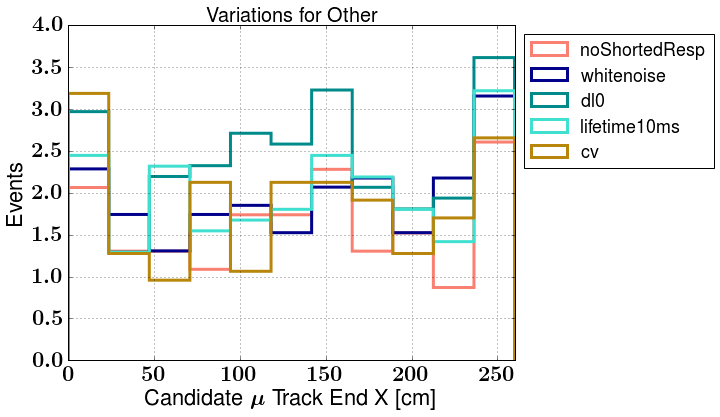

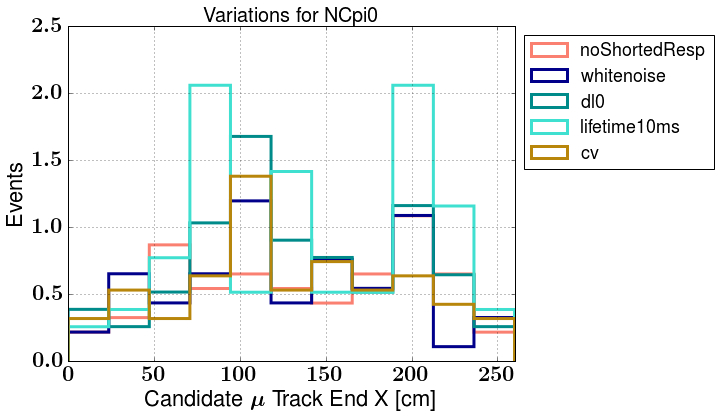

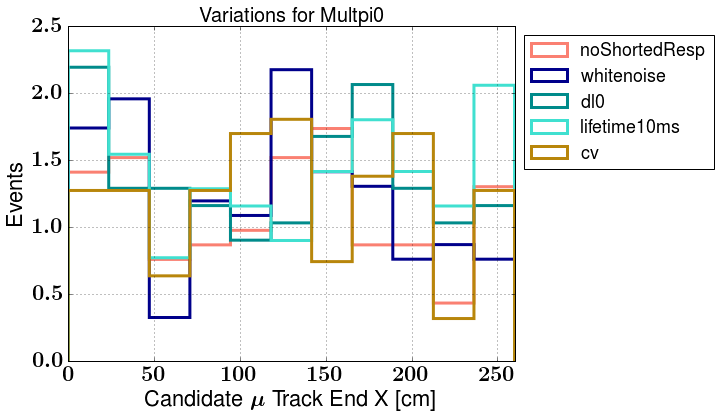

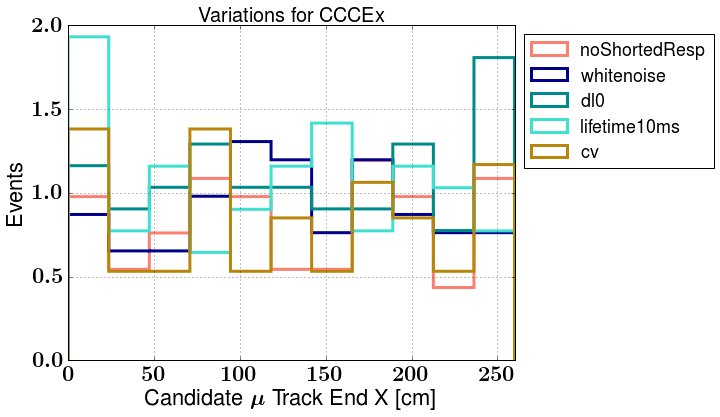

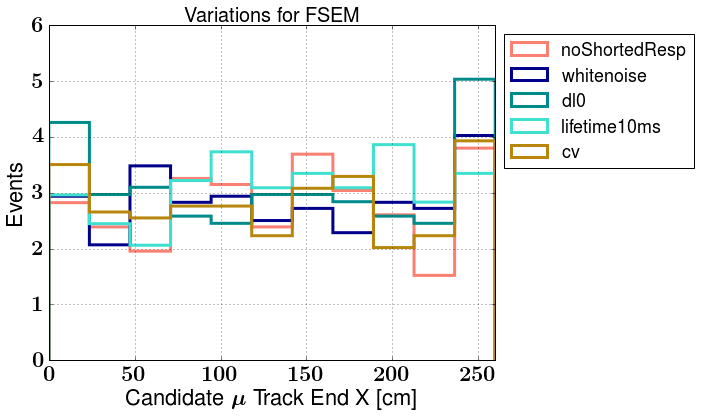

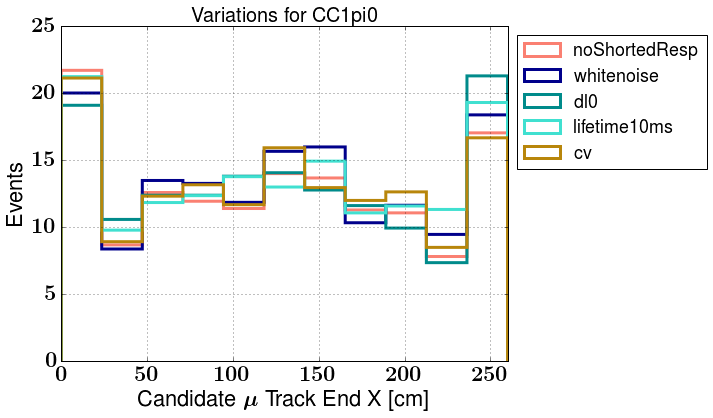

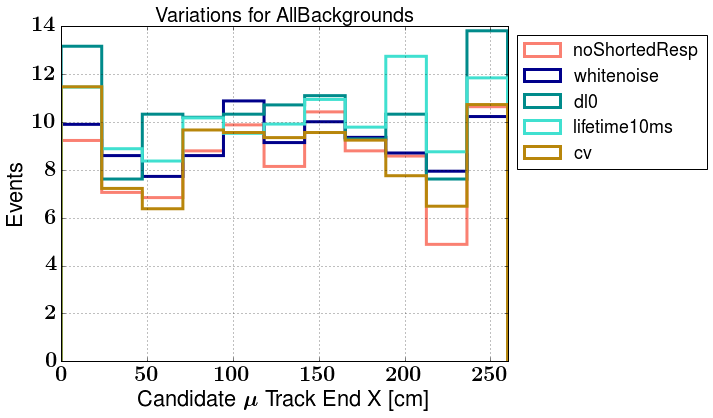

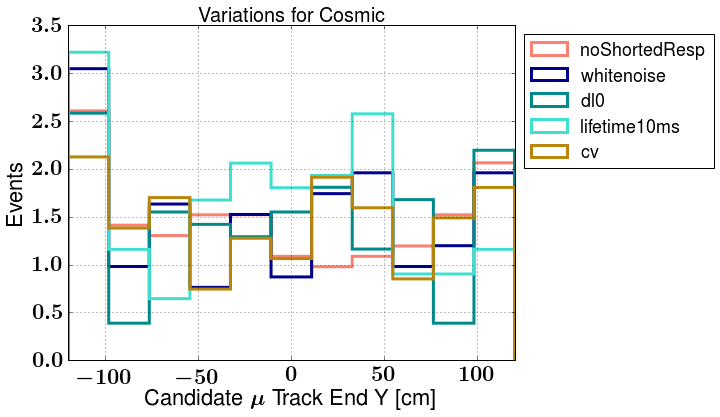

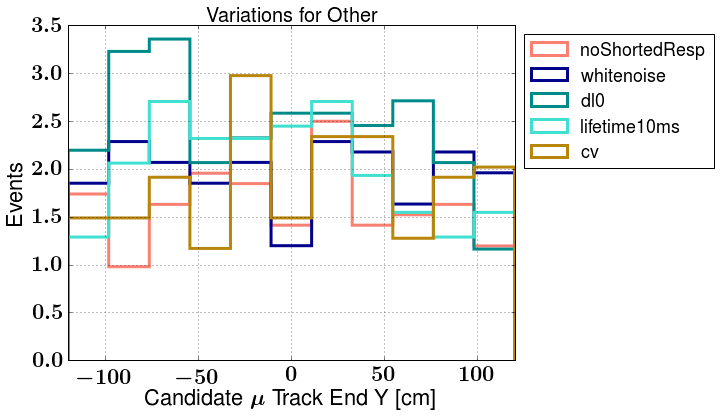

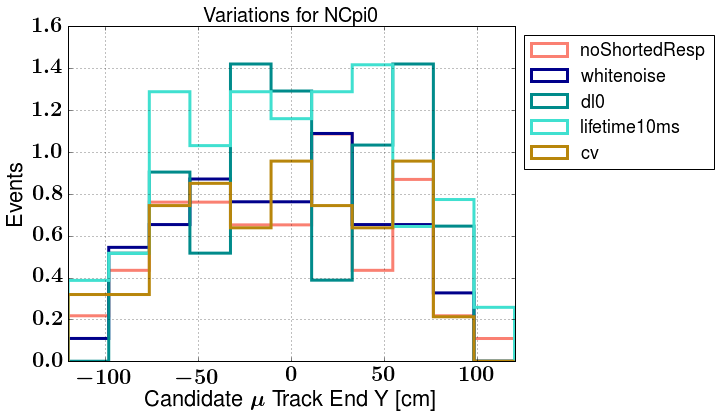

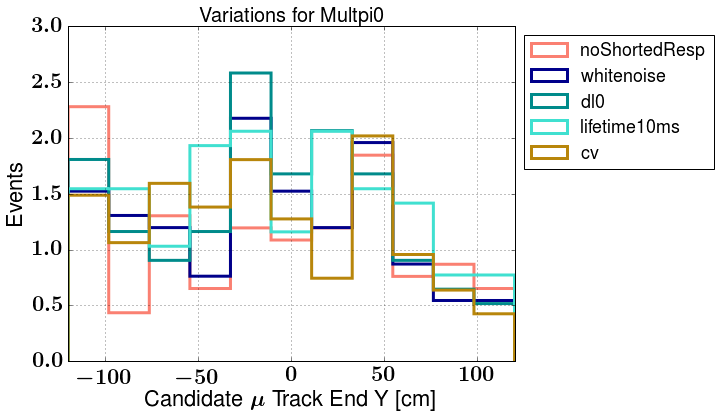

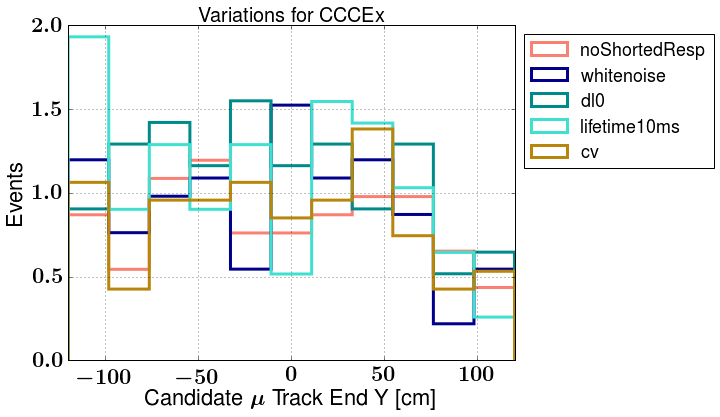

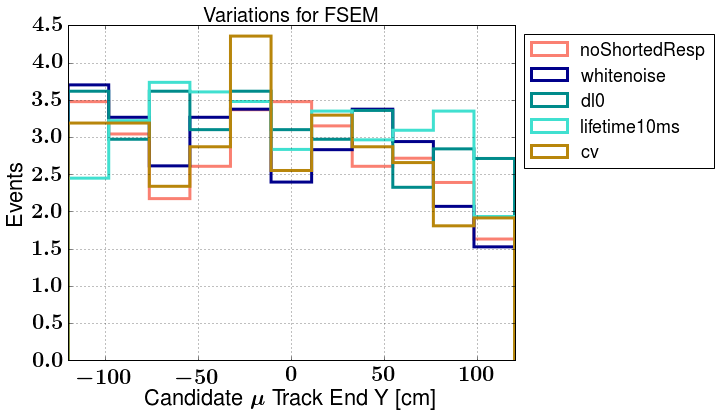

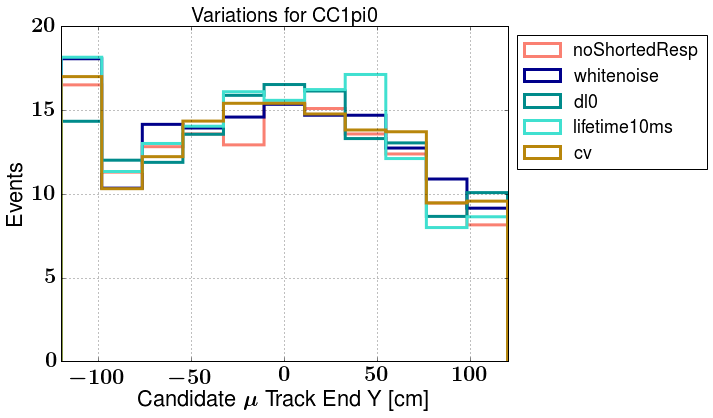

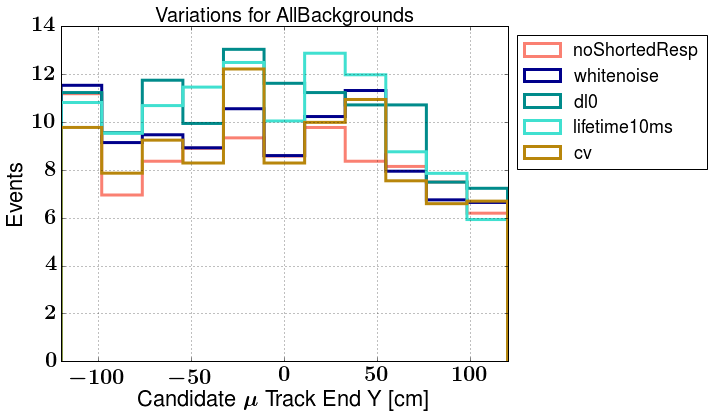

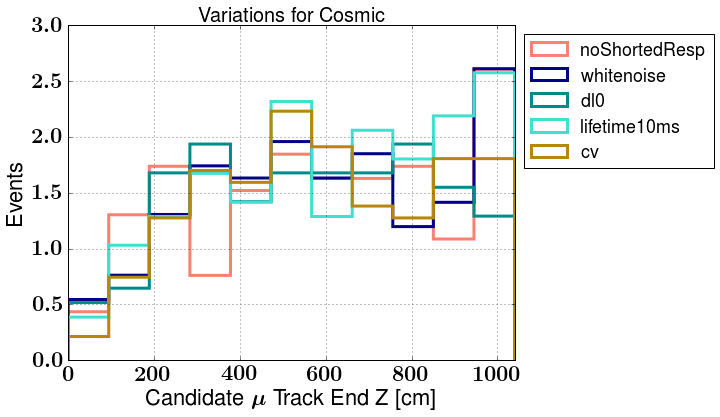

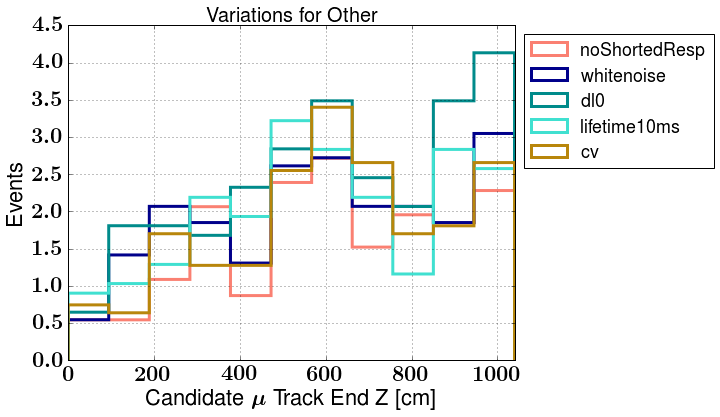

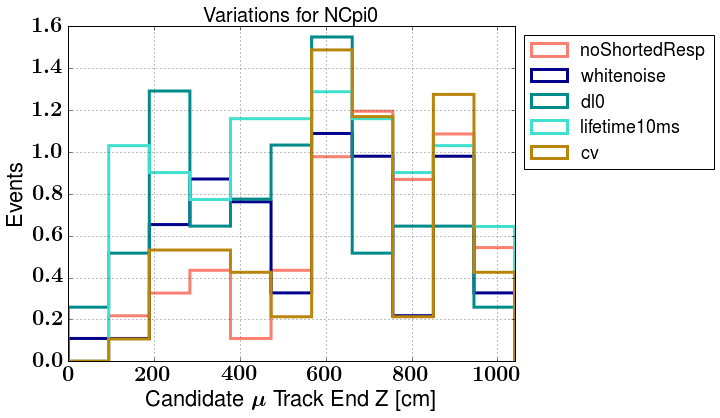

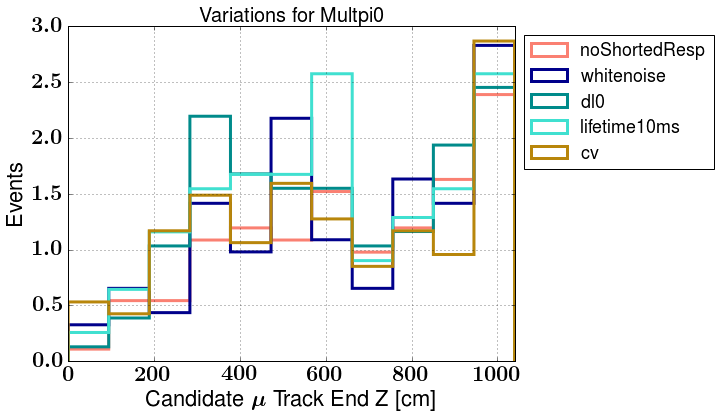

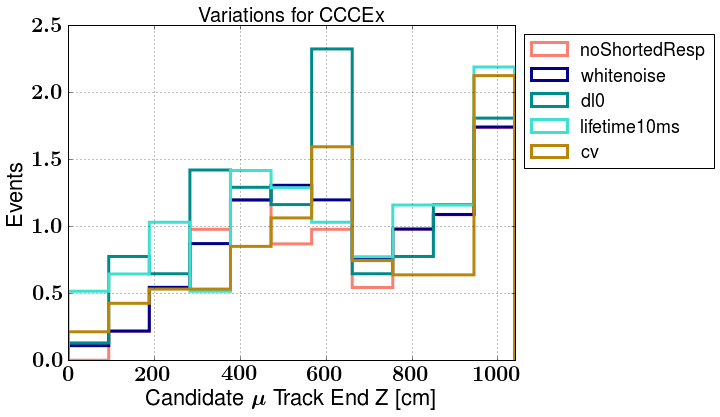

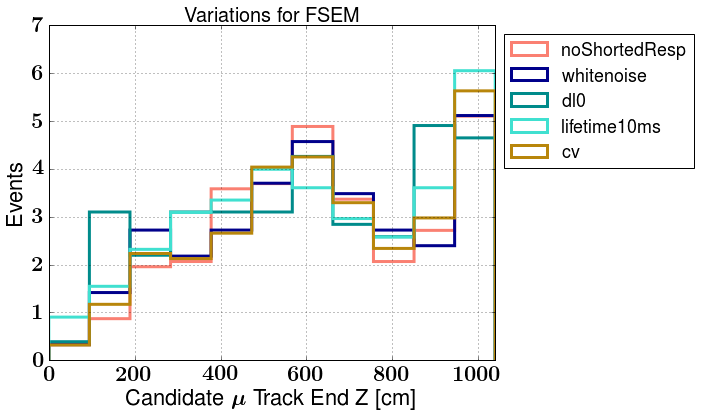

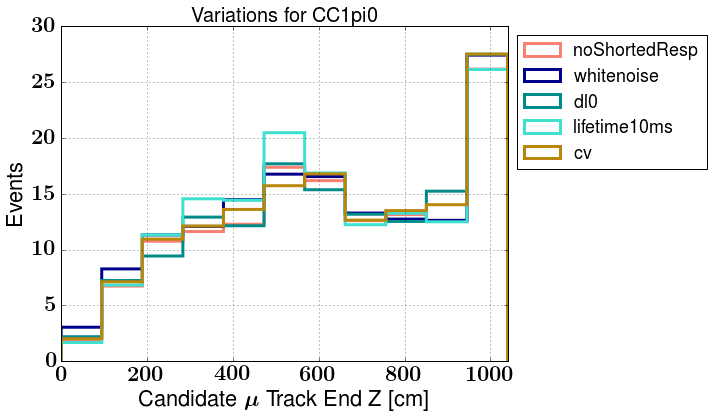

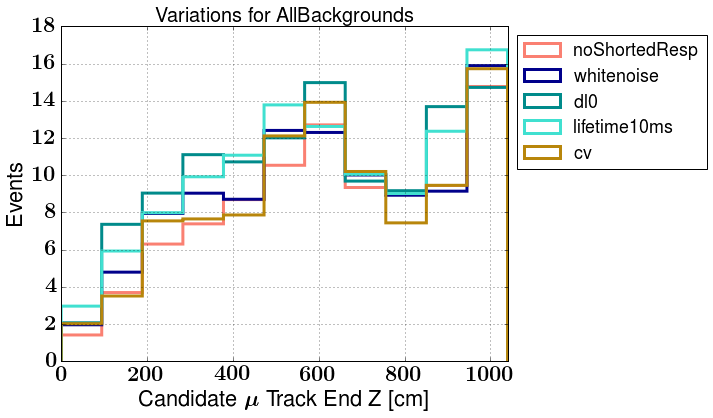

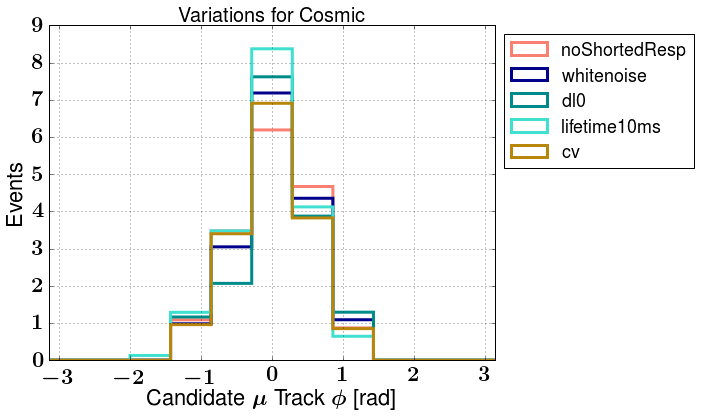

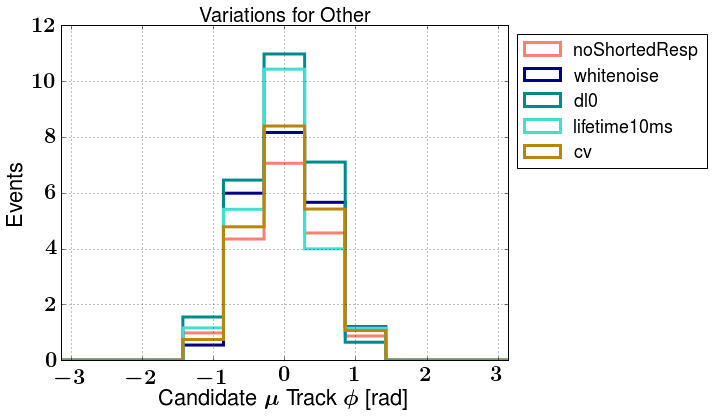

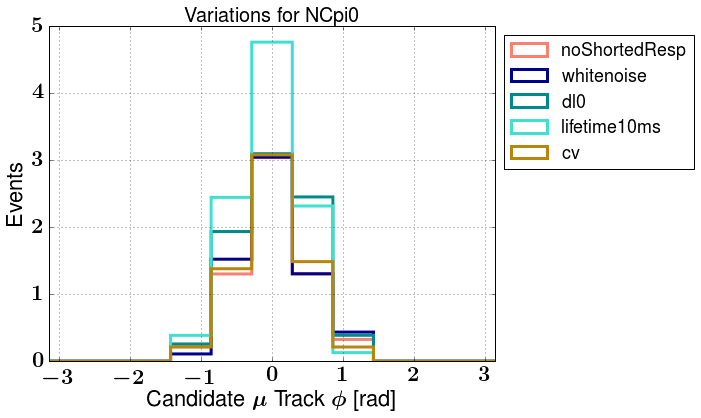

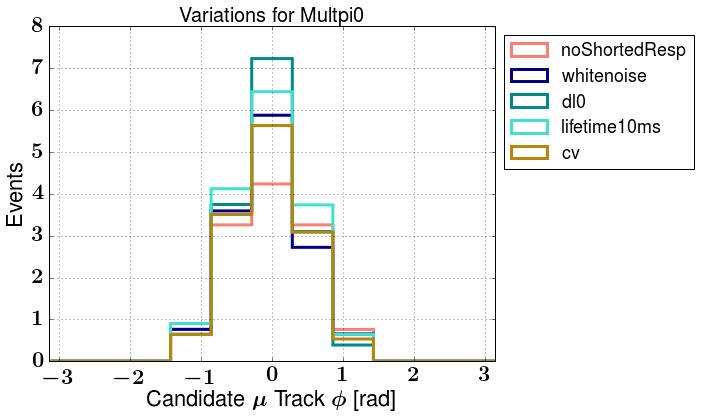

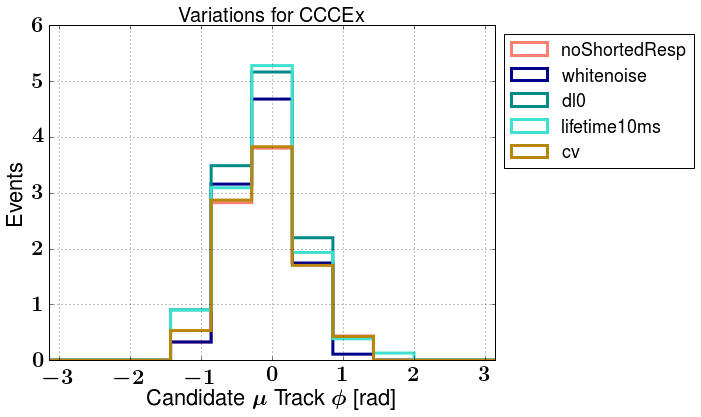

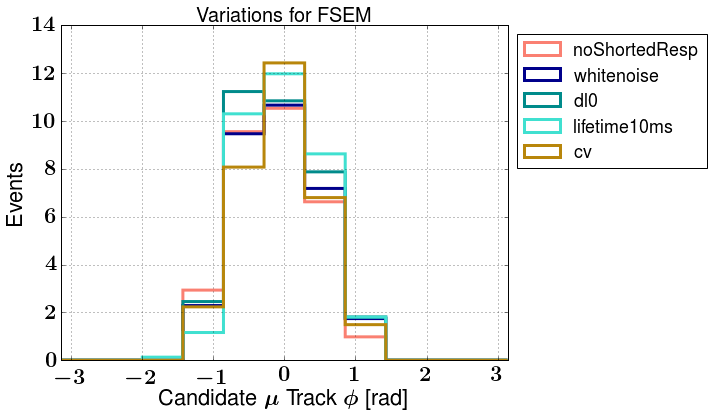

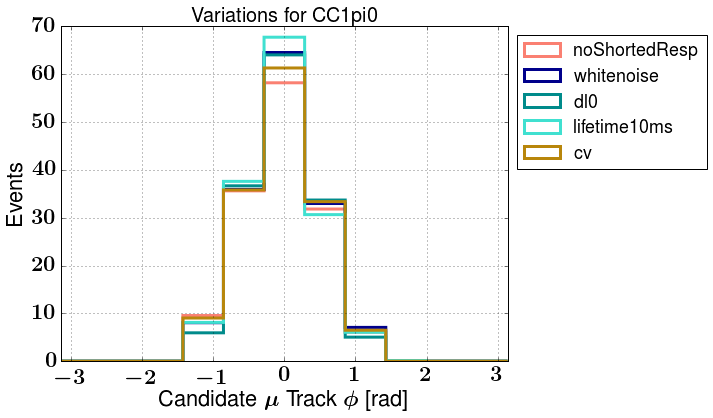

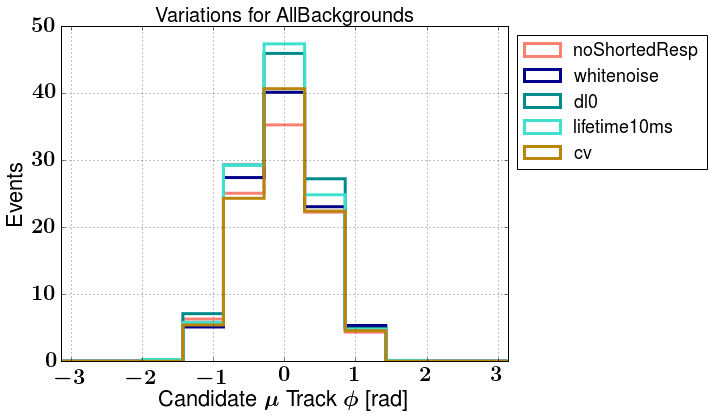

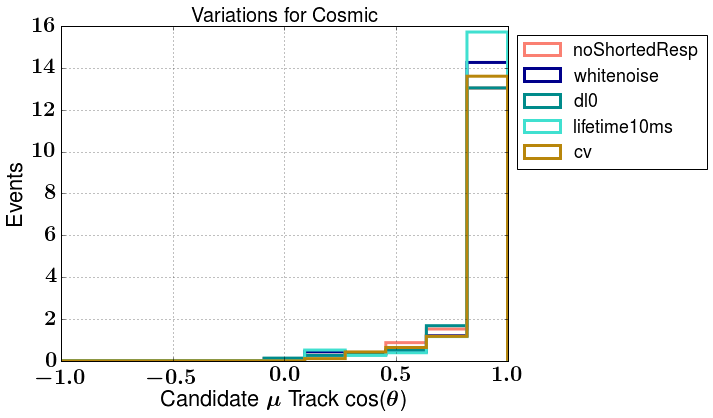

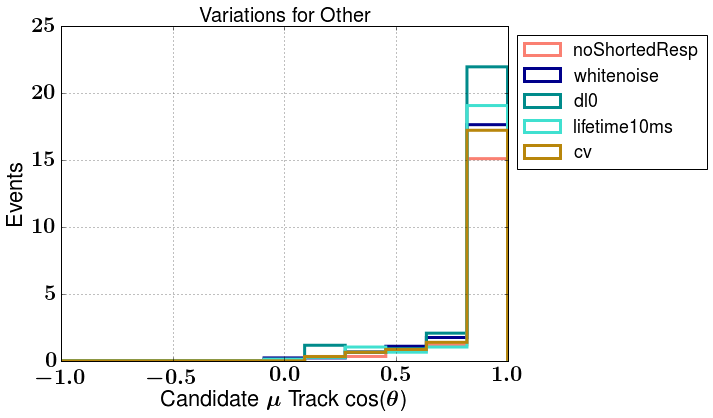

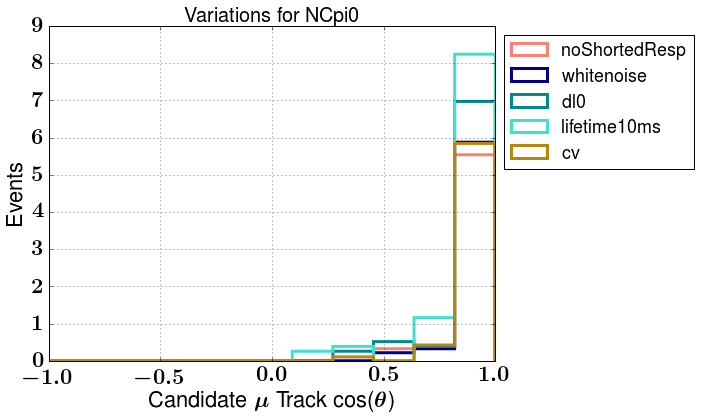

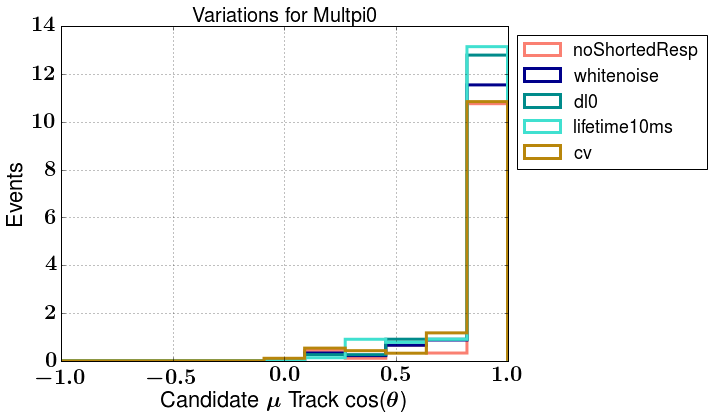

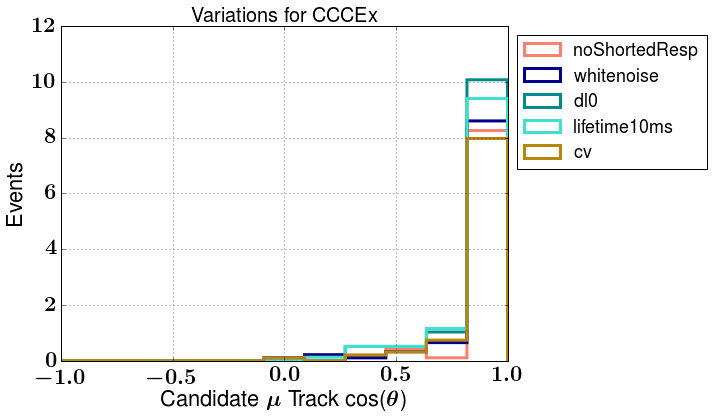

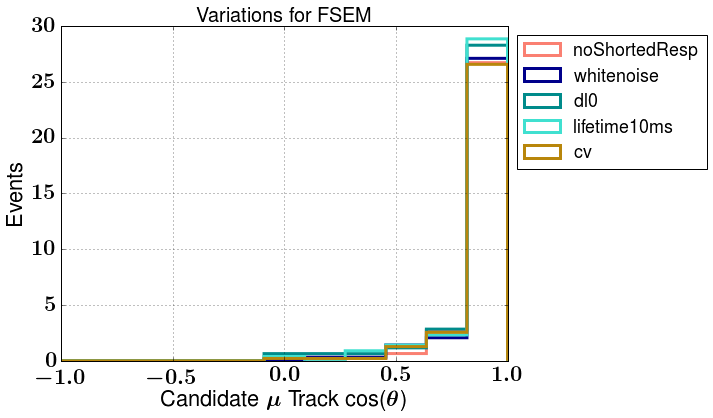

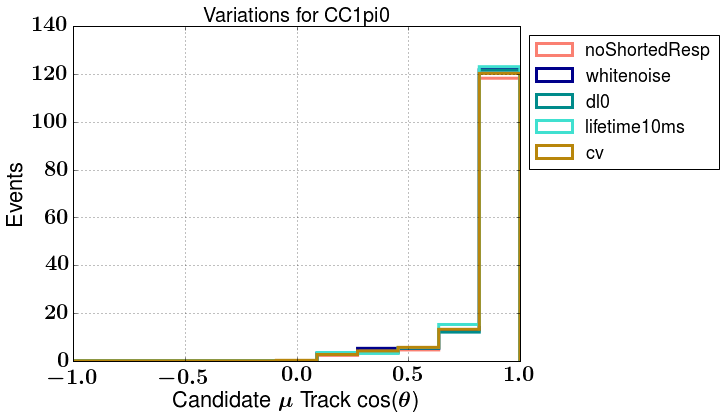

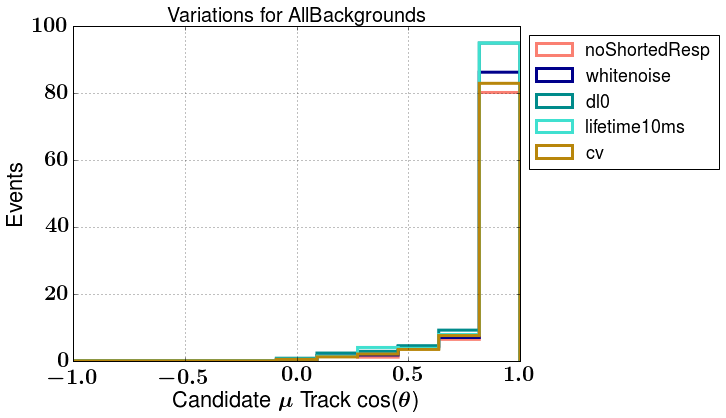

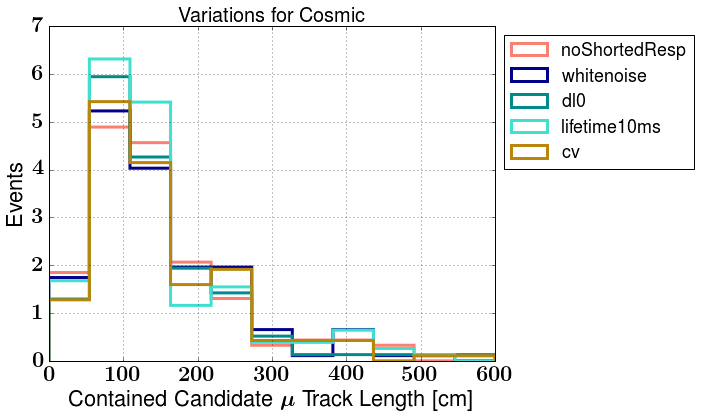

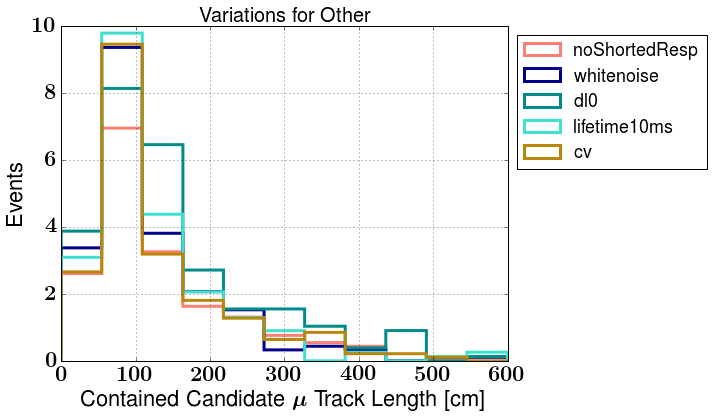

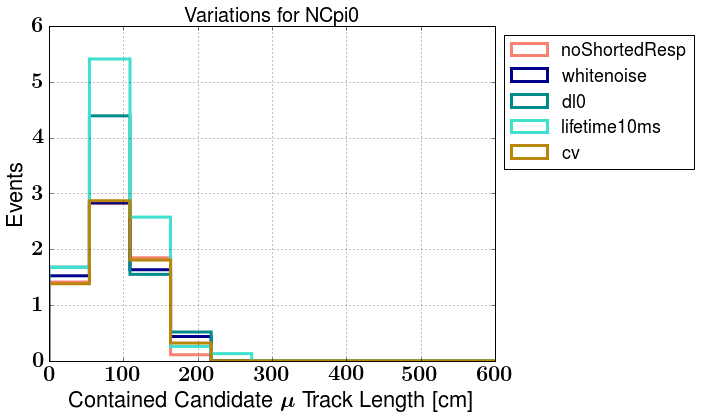

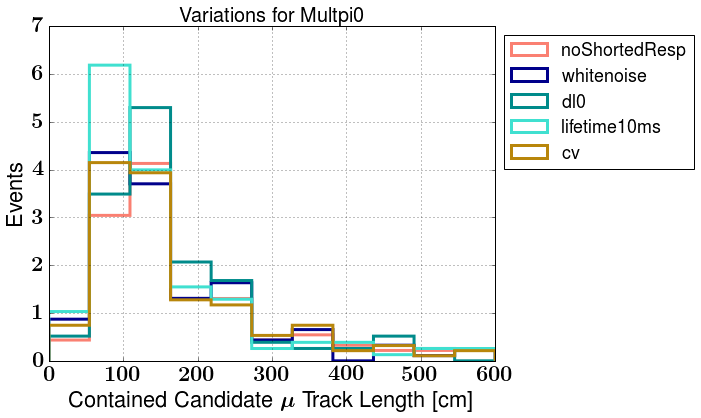

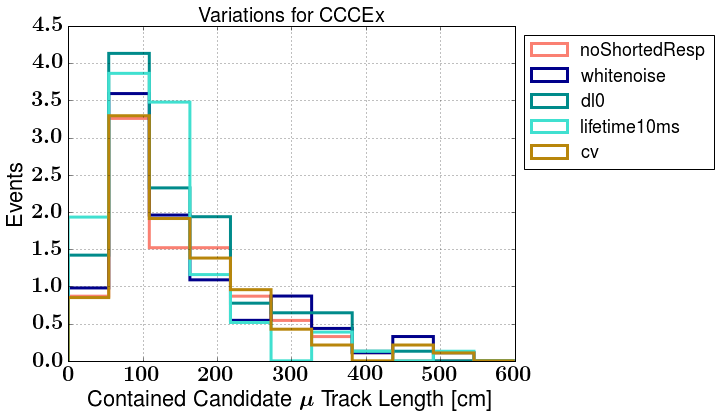

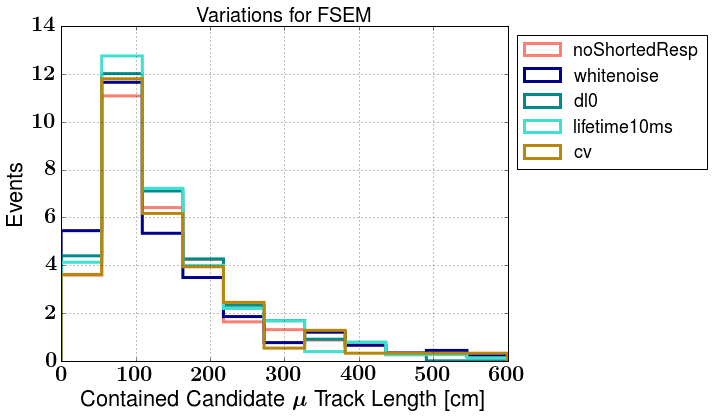

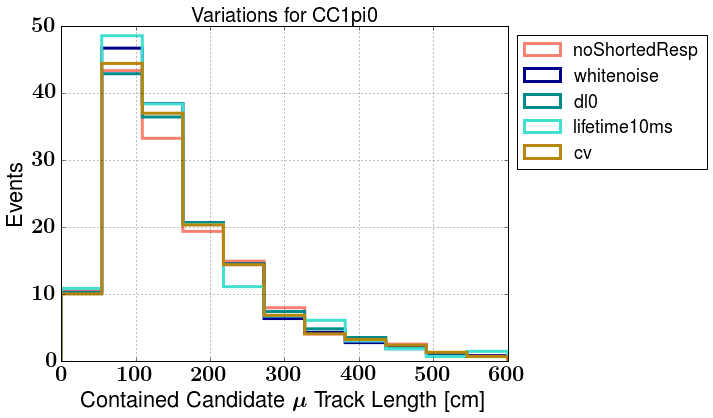

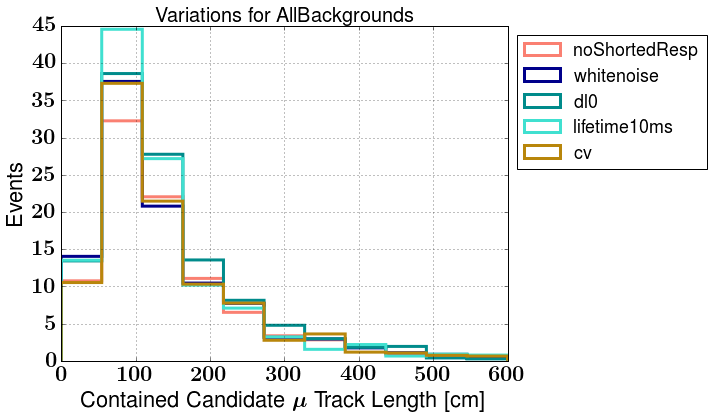

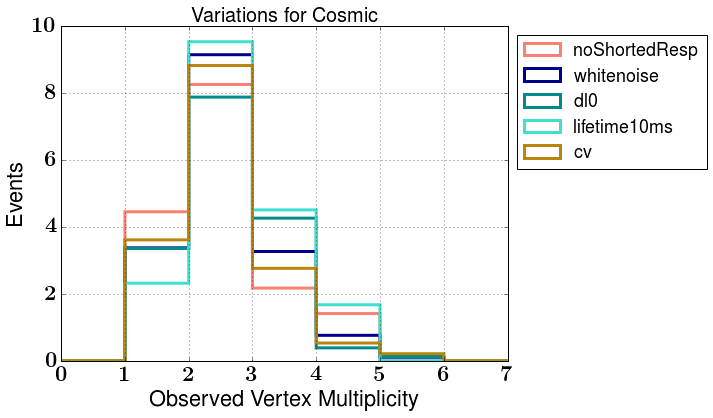

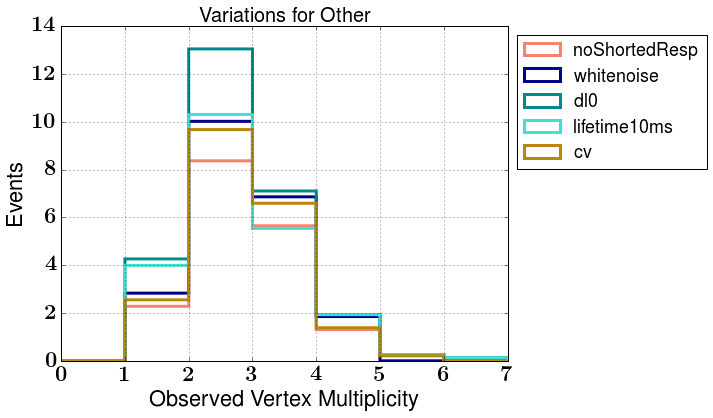

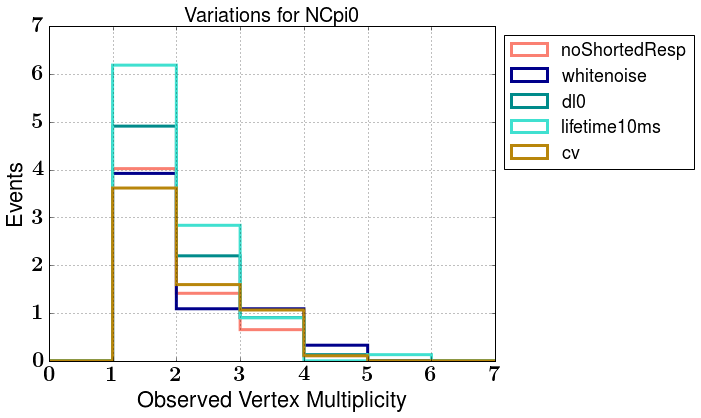

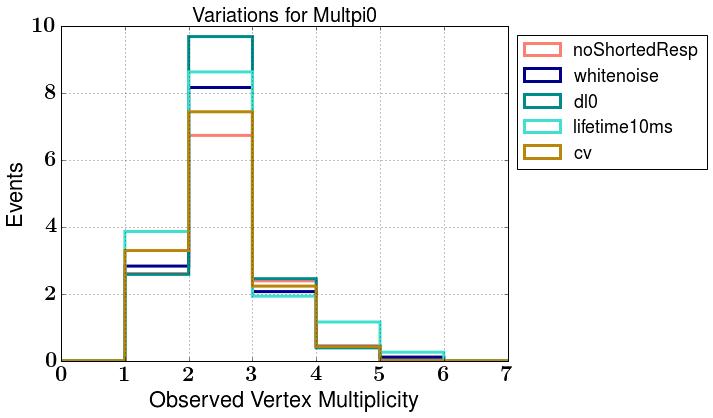

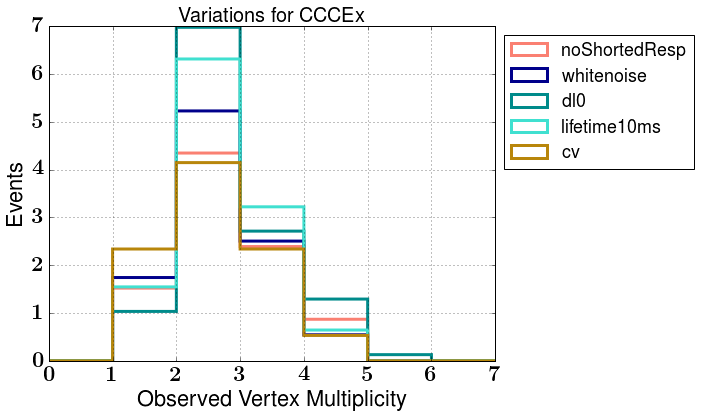

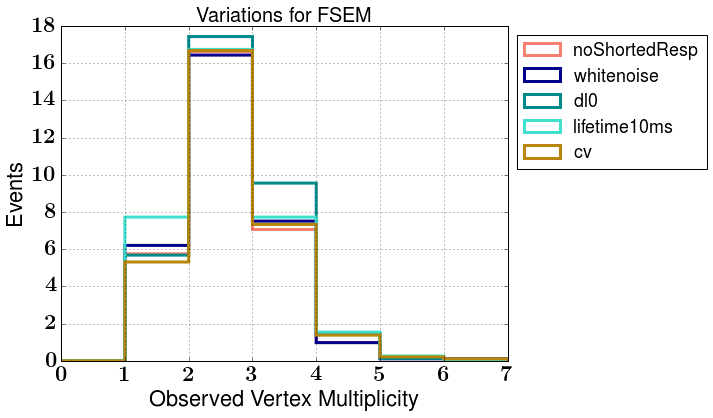

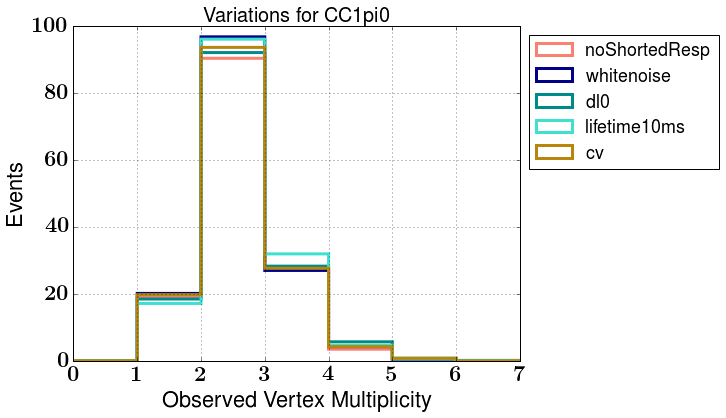

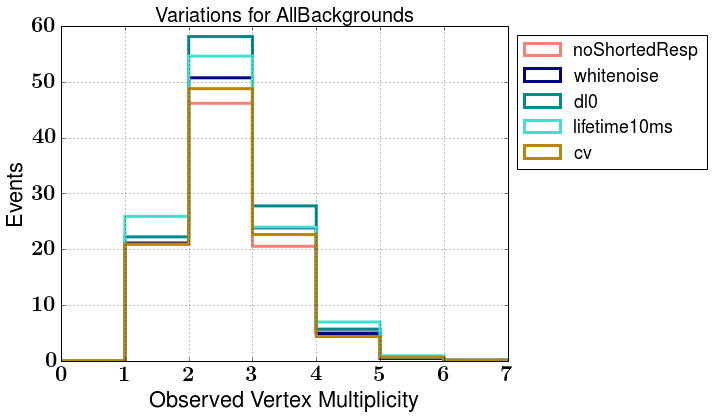

In [192]:
makeAbsNormPlots('nshrs',0,7,nbins=7,xlabel='Number of Reconstructed Showers',unit='empty')
makeAbsNormPlots('mu_startx',0,260,nbins=11,xlabel='Candidate $\mu$ Track Start X [cm]')
makeAbsNormPlots('mu_starty',-110,110,nbins=11,xlabel='Candidate $\mu$ Track Start Y [cm]')
makeAbsNormPlots('mu_startz',0,1040,nbins=11,xlabel='Candidate $\mu$ Track Start Z [cm]')
makeAbsNormPlots('mu_endx',0,260,nbins=11,xlabel='Candidate $\mu$ Track End X [cm]')
makeAbsNormPlots('mu_endy',-120,120,nbins=11,xlabel='Candidate $\mu$ Track End Y [cm]')
makeAbsNormPlots('mu_endz',0,1040,nbins=11,xlabel='Candidate $\mu$ Track End Z [cm]')

makeAbsNormPlots('mu_phi',-3.14,3.14,nbins=11,xlabel='Candidate $\mu$ Track $\\phi$ [rad]',unit='rad')
makeAbsNormPlots('mu_angle',-1,1,nbins=11,xlabel='Candidate $\mu$ Track cos($\\theta$)',unit='empty')
makeAbsNormPlots('mu_len',0,600,nbins=11,xlabel='Contained Candidate $\mu$ Track Length [cm]')
makeAbsNormPlots('mult',0,7,nbins=7,xlabel='Observed Vertex Multiplicity',unit='empty')

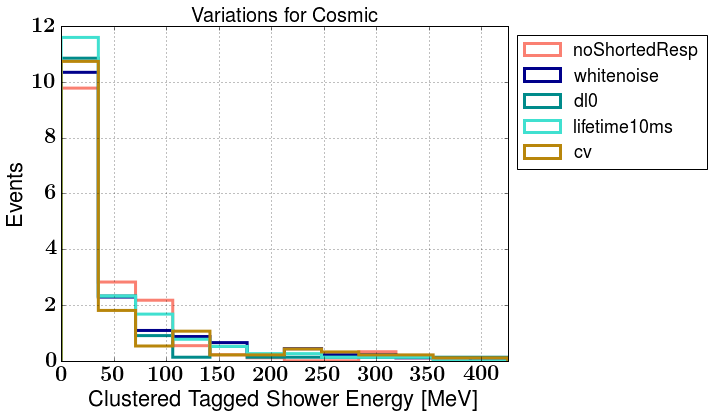

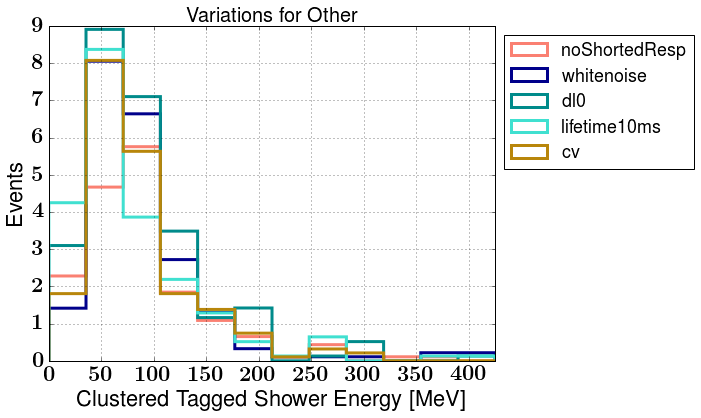

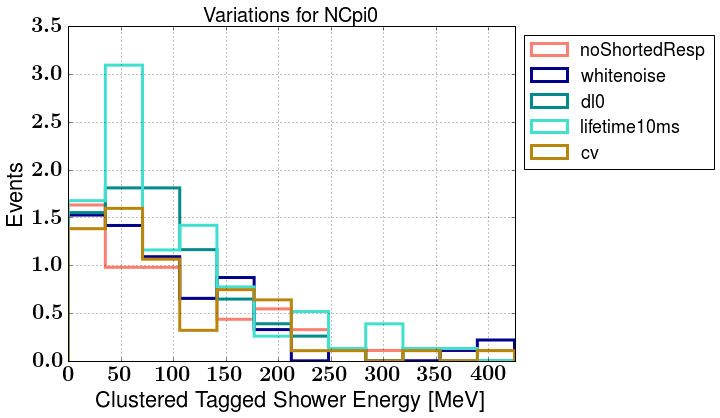

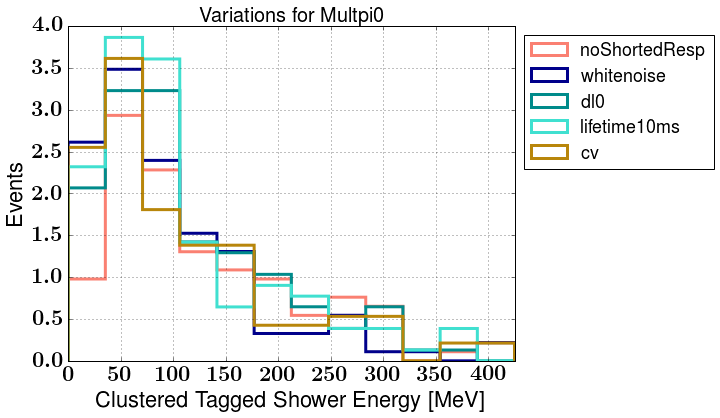

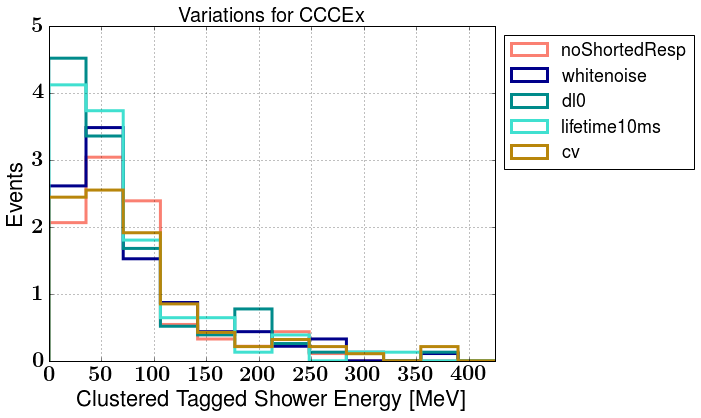

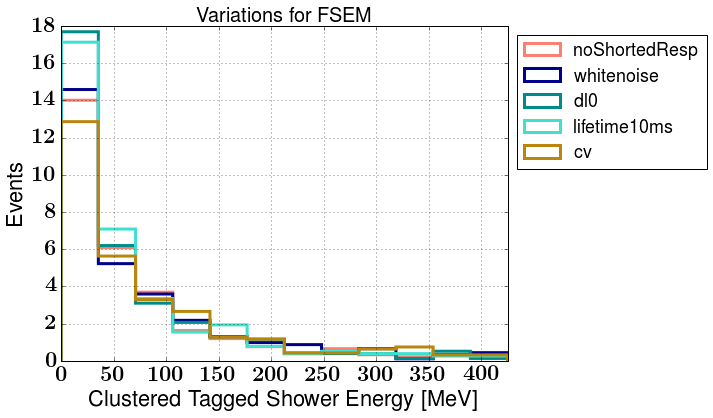

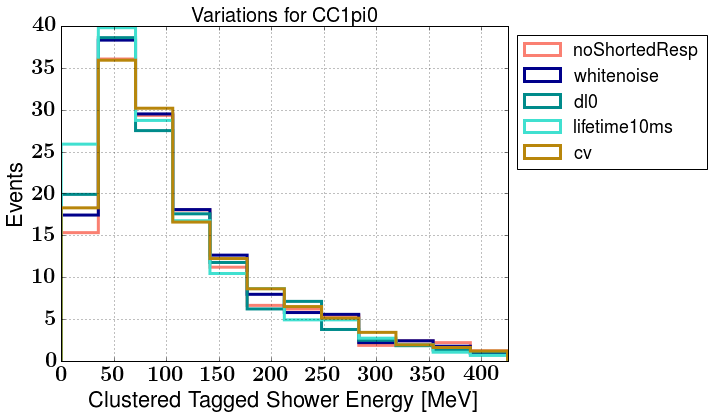

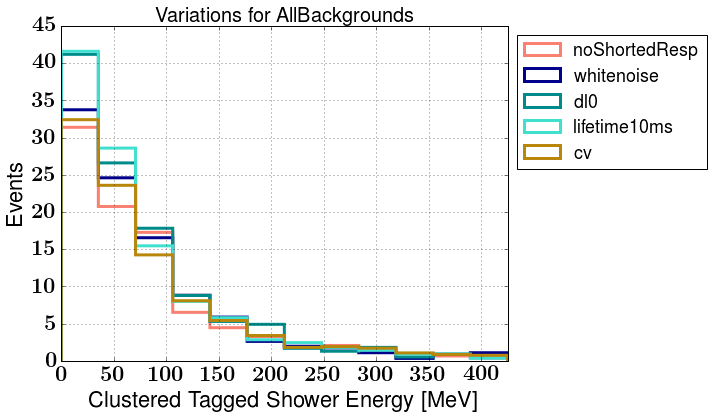

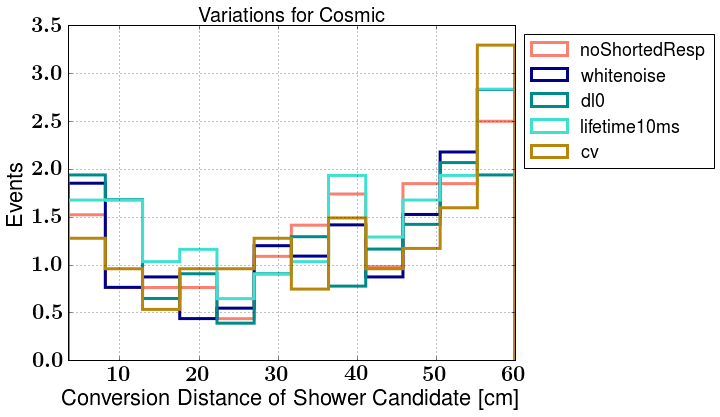

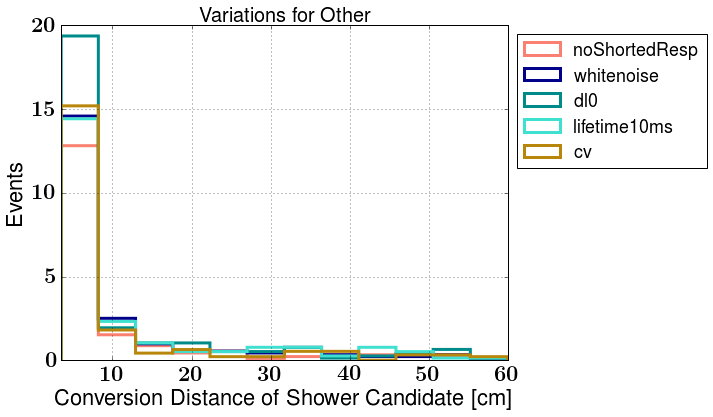

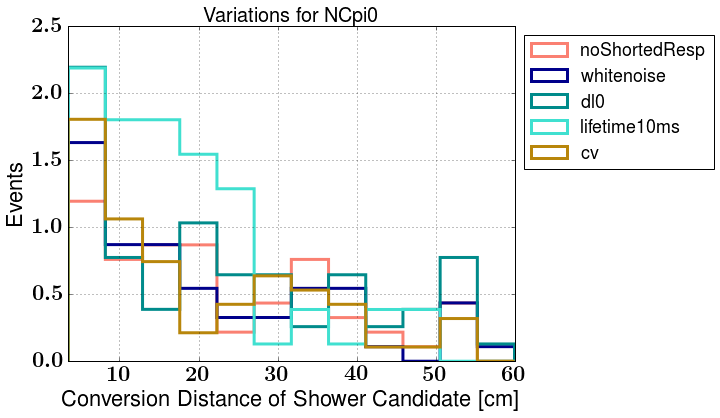

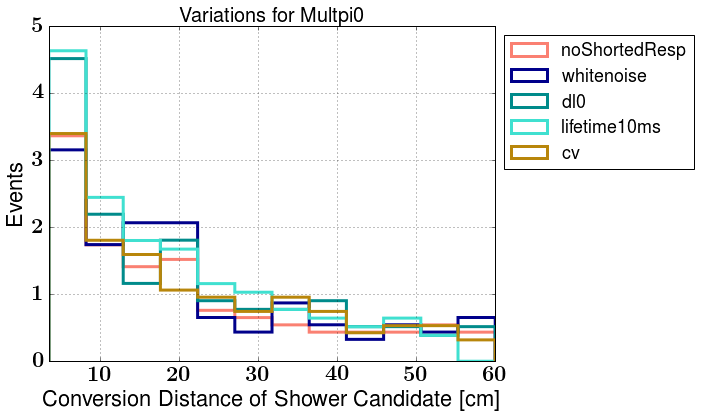

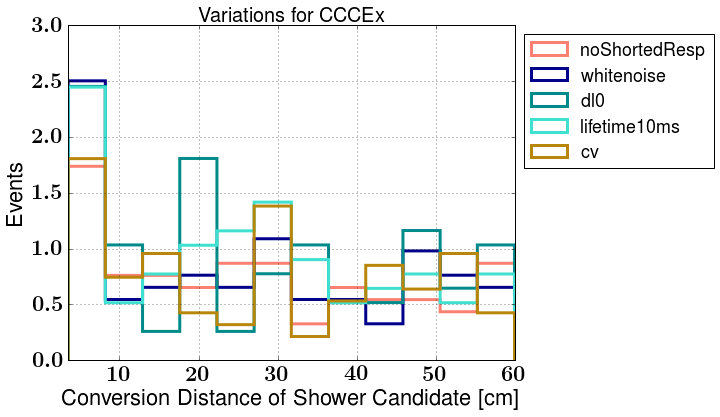

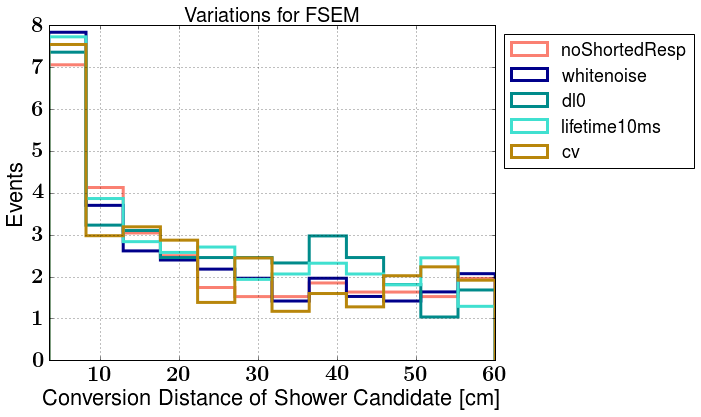

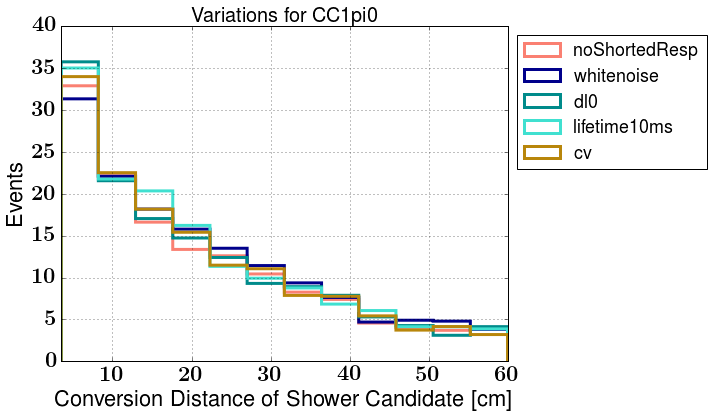

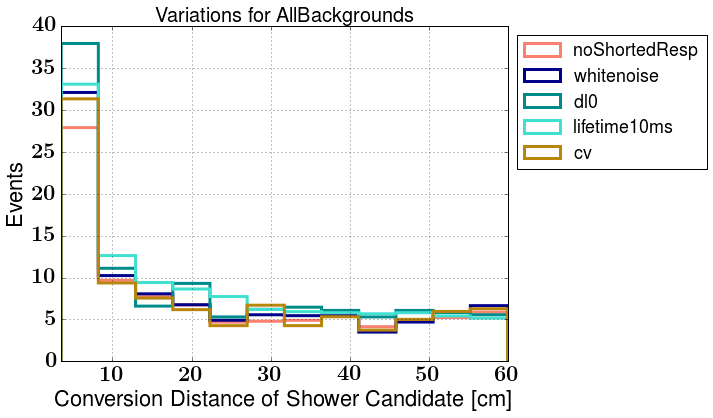

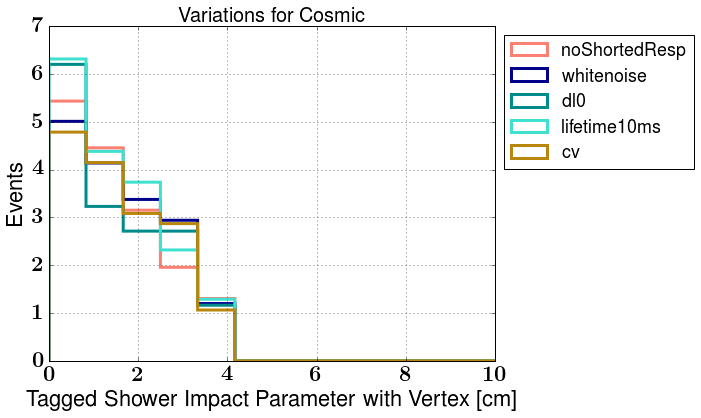

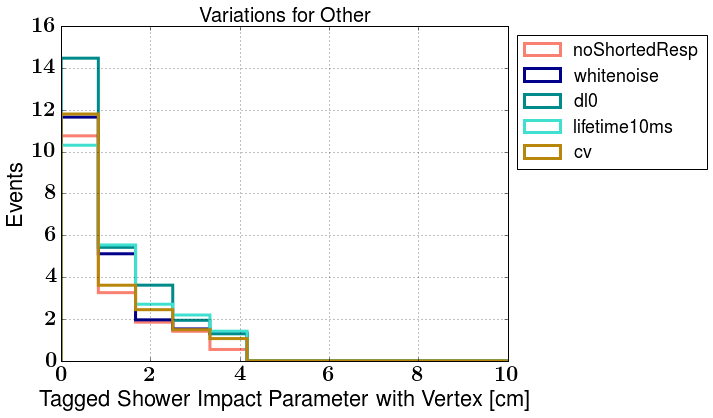

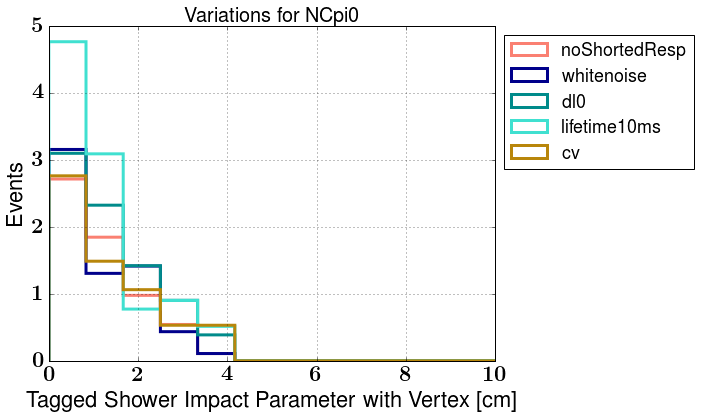

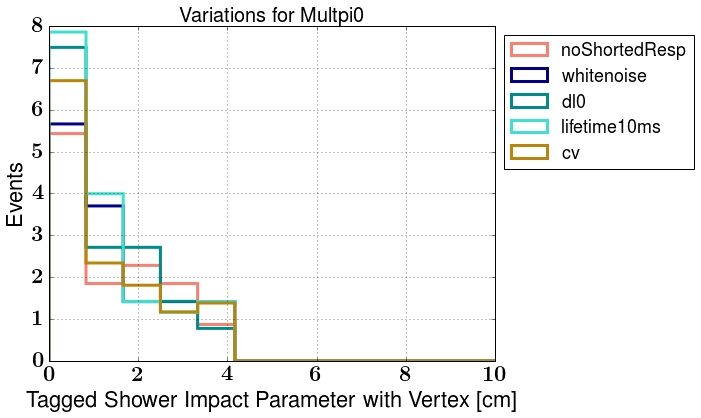

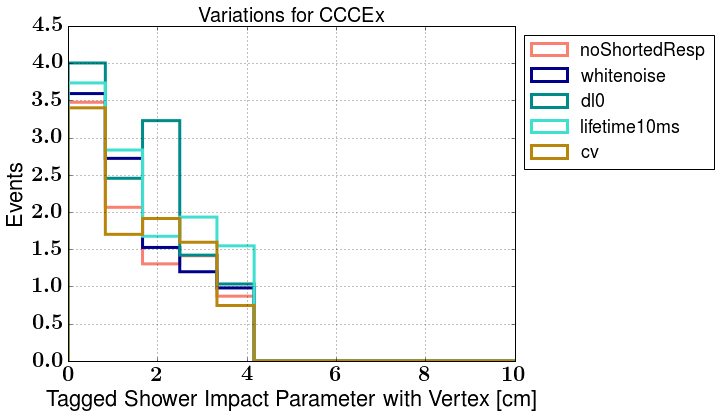

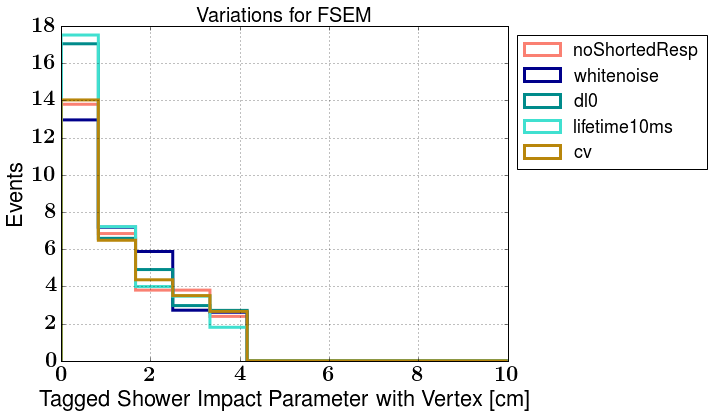

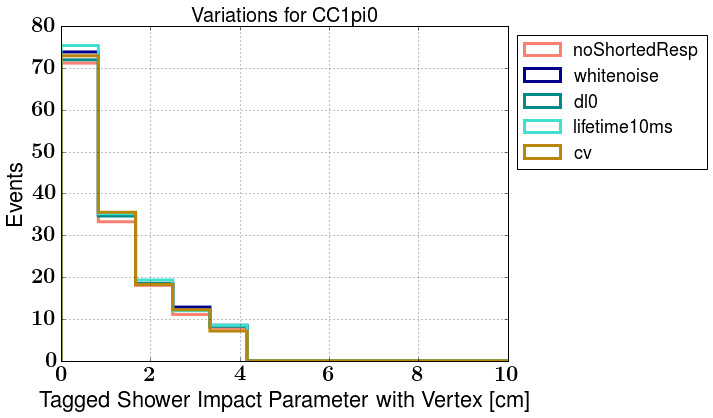

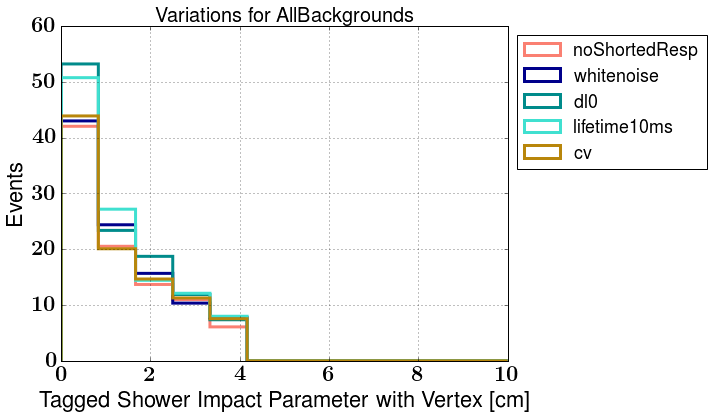

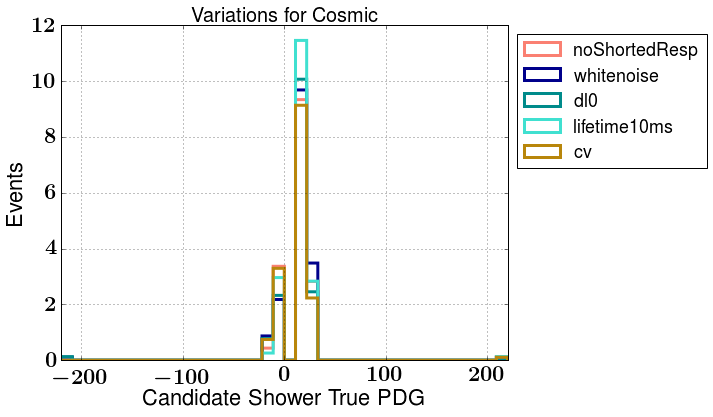

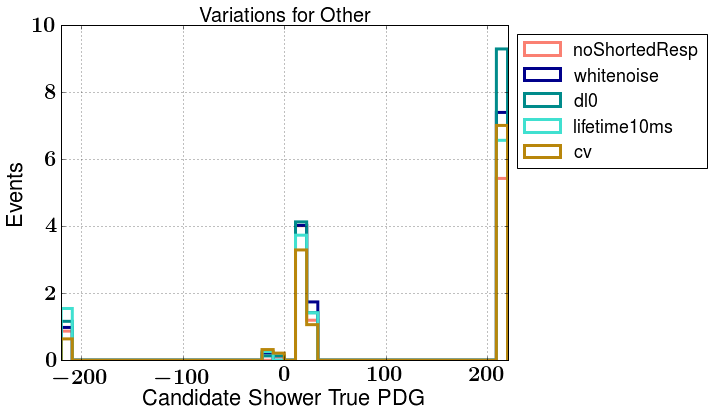

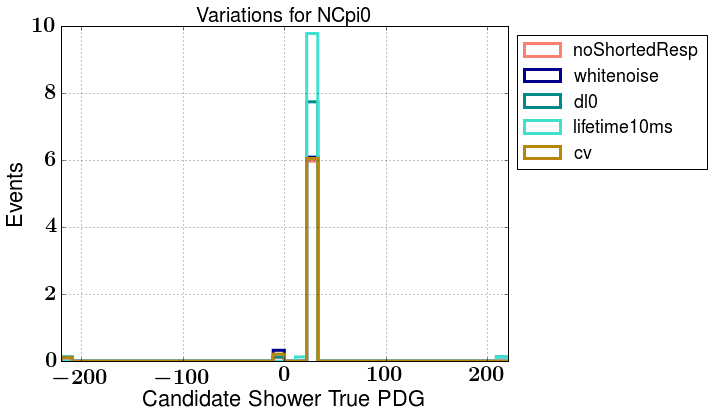

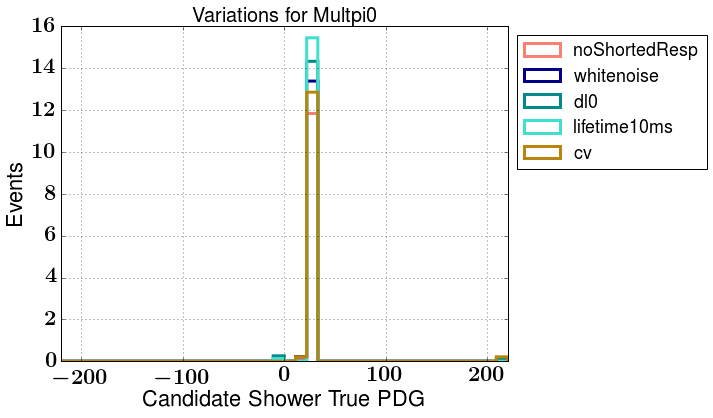

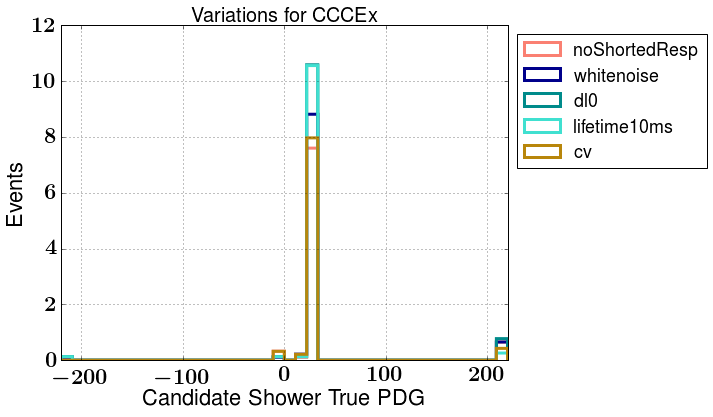

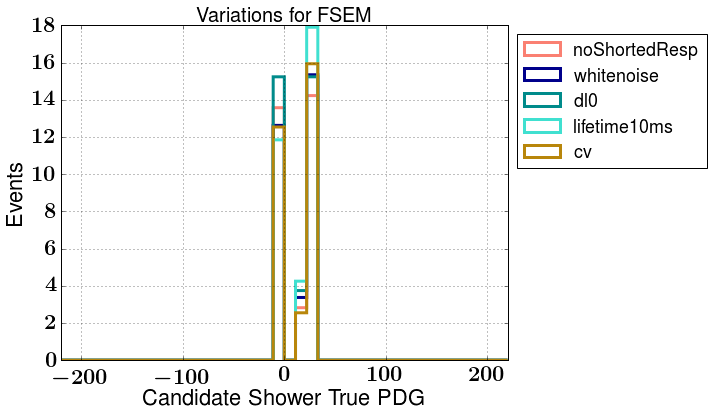

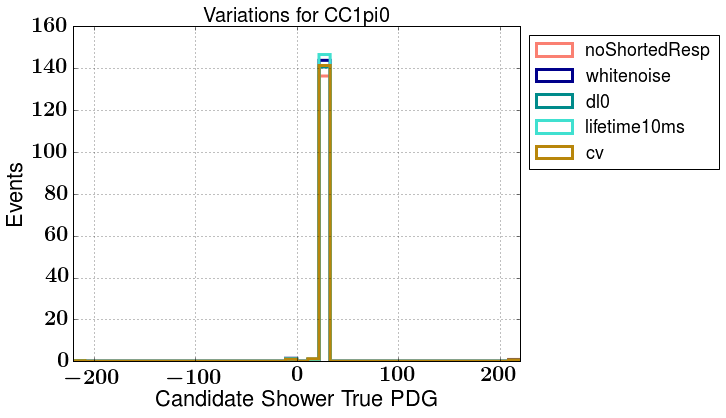

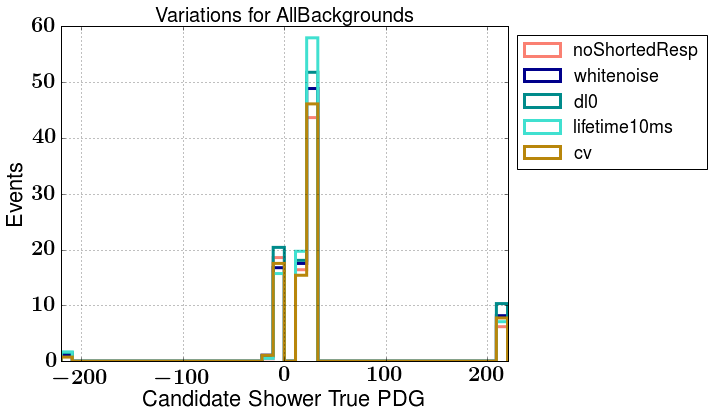

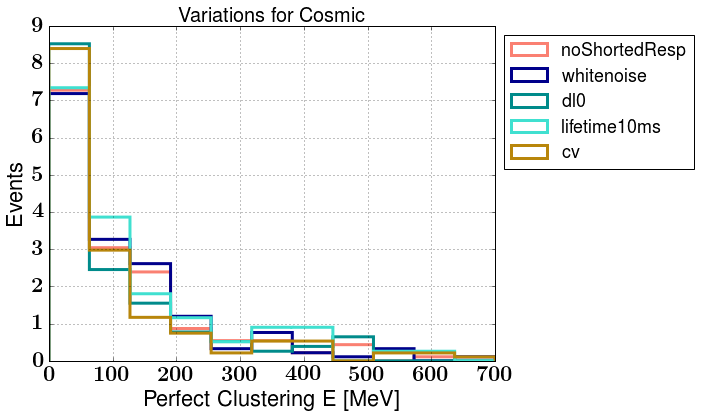

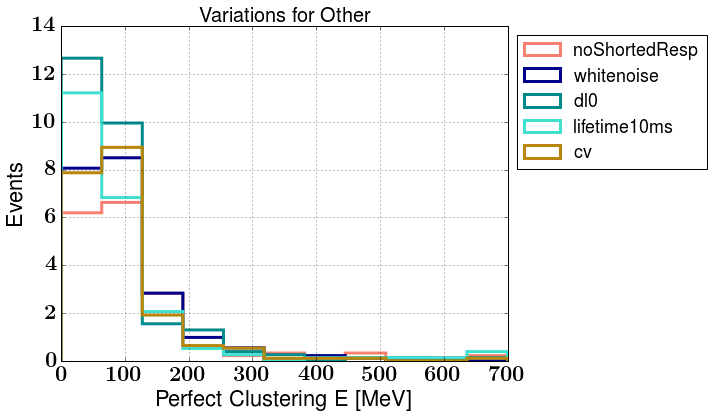

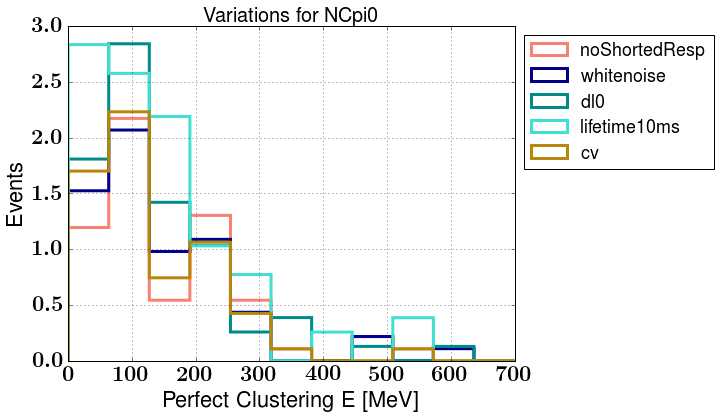

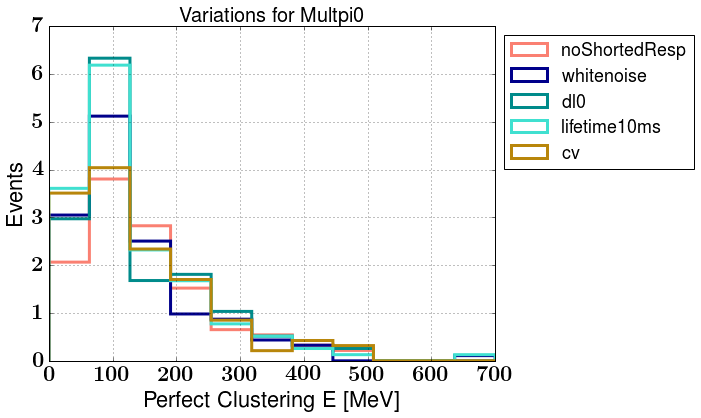

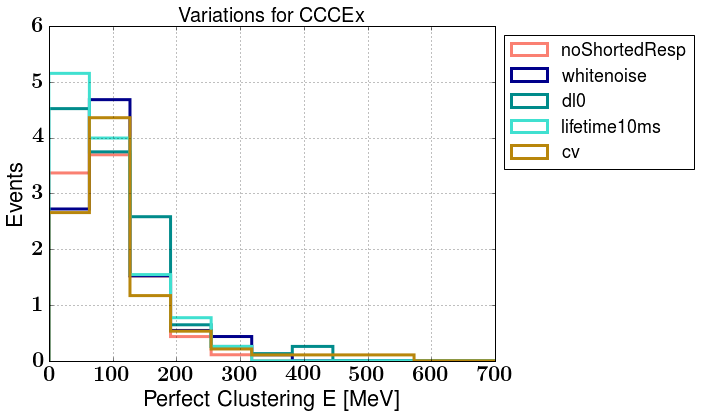

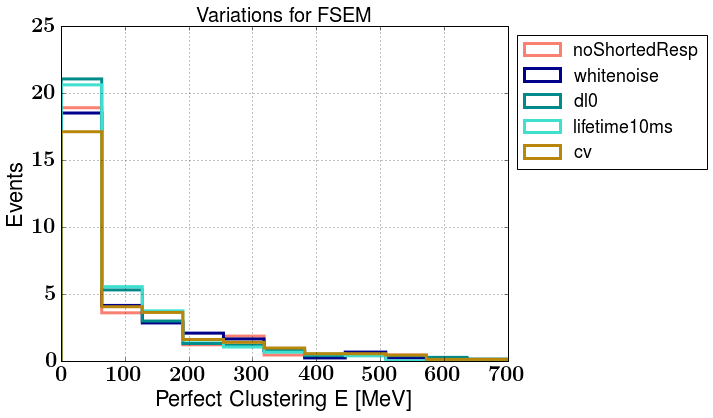

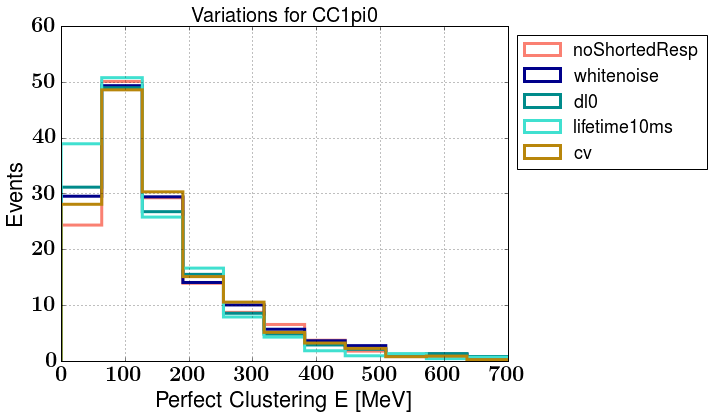

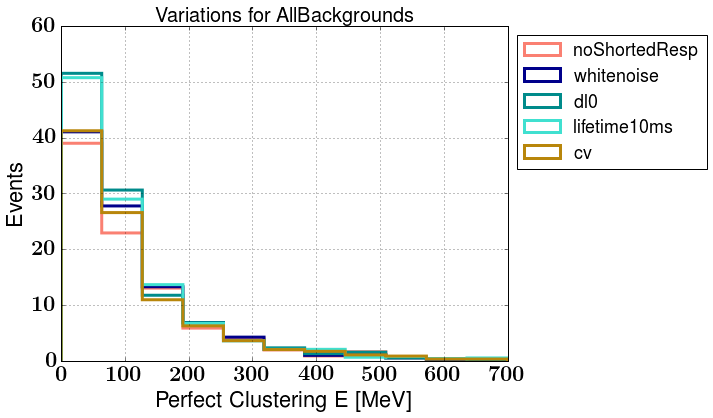

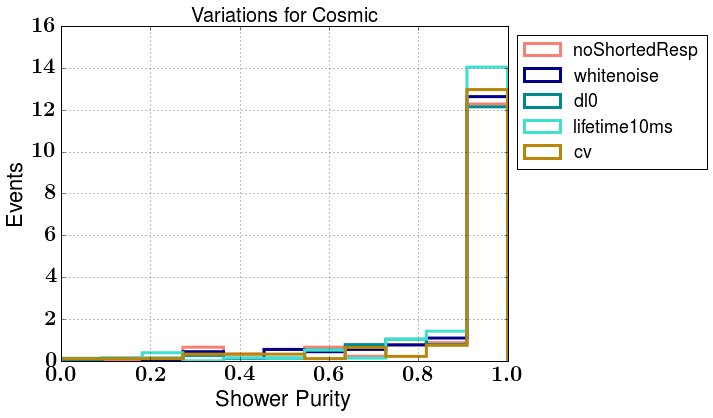

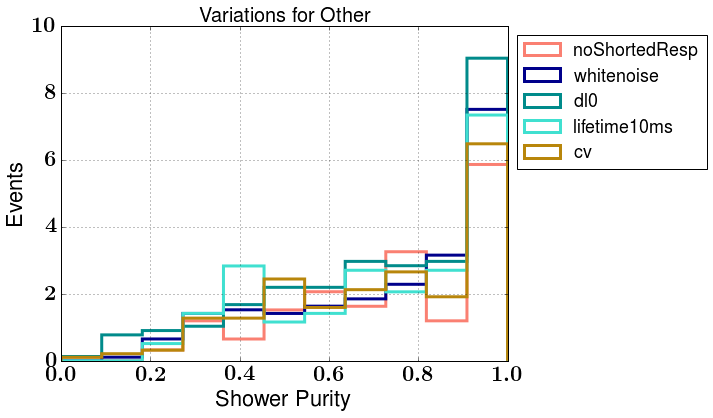

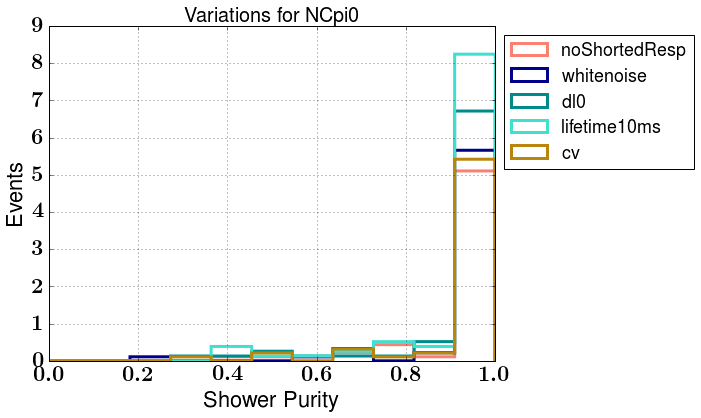

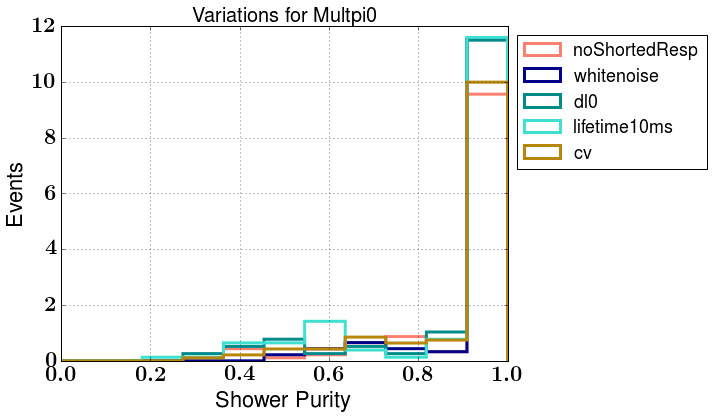

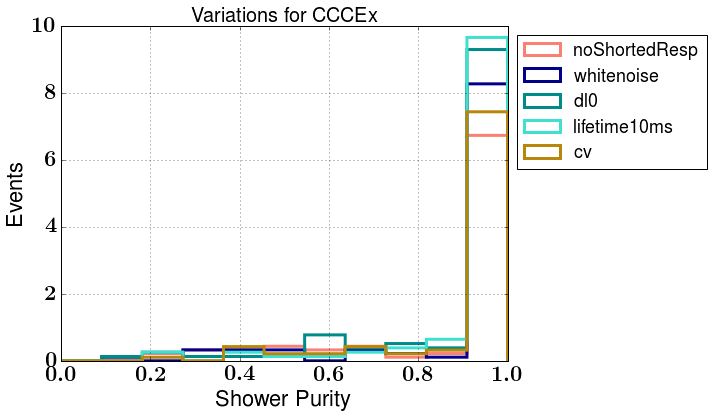

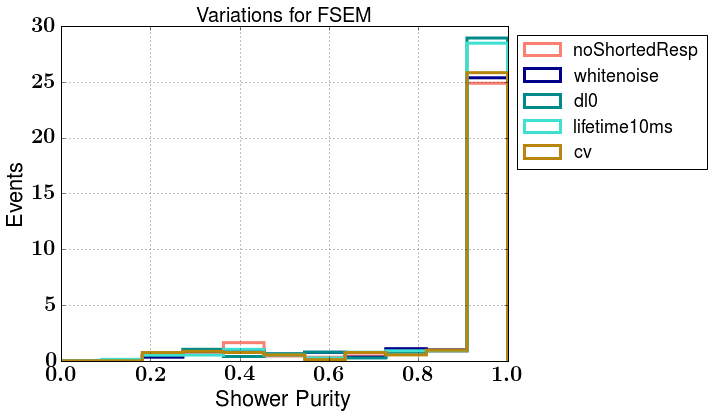

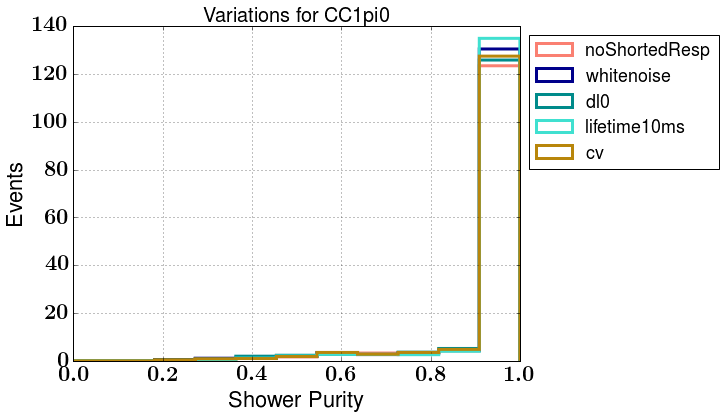

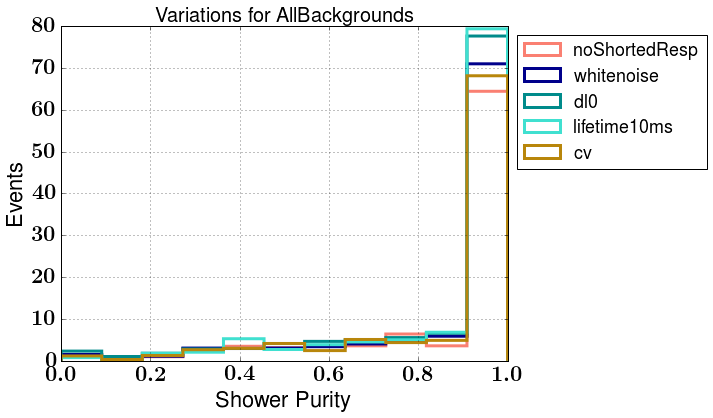

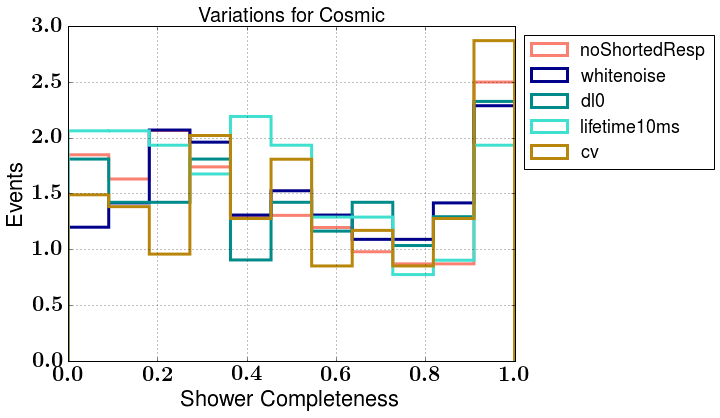

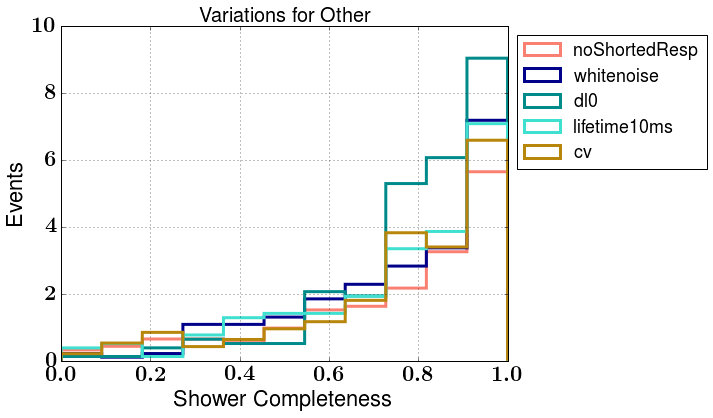

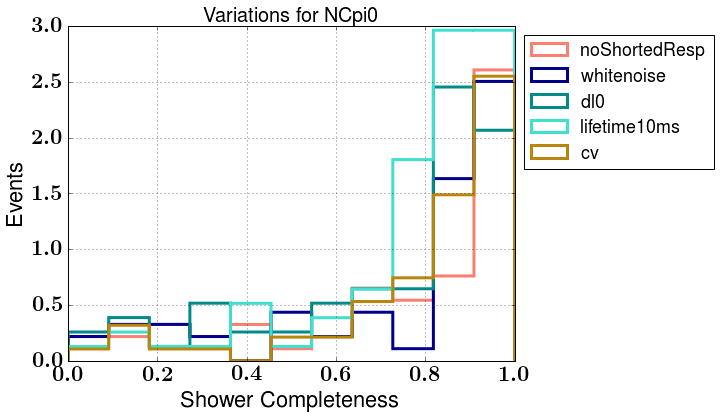

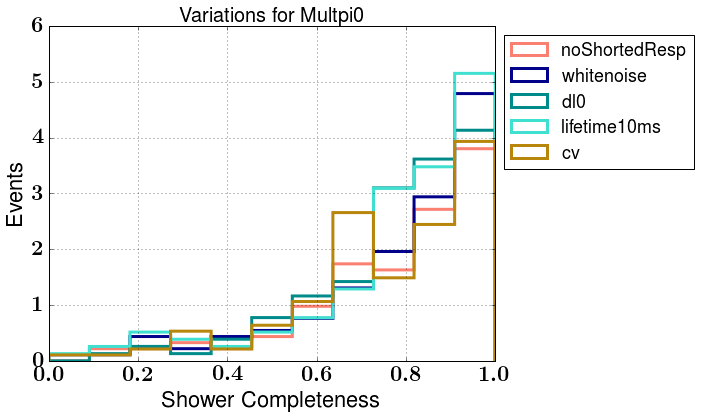

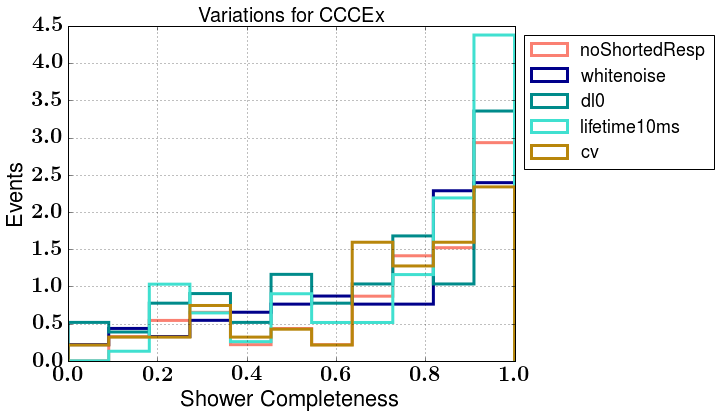

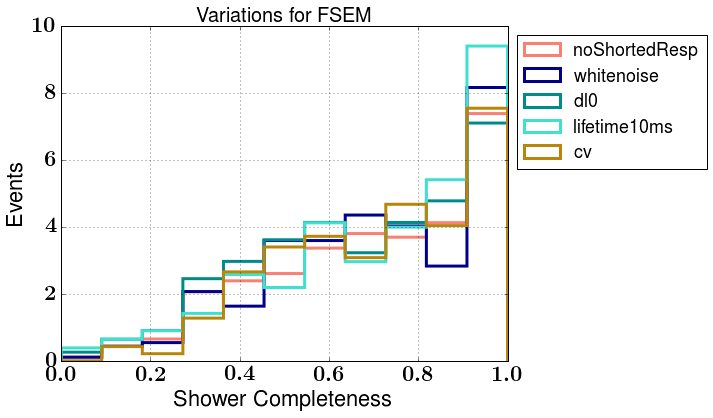

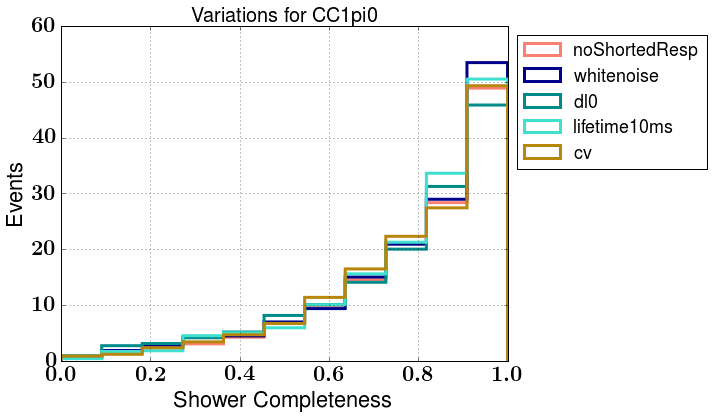

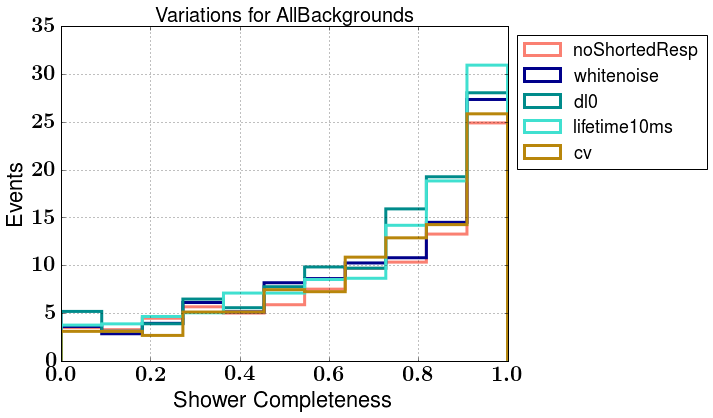

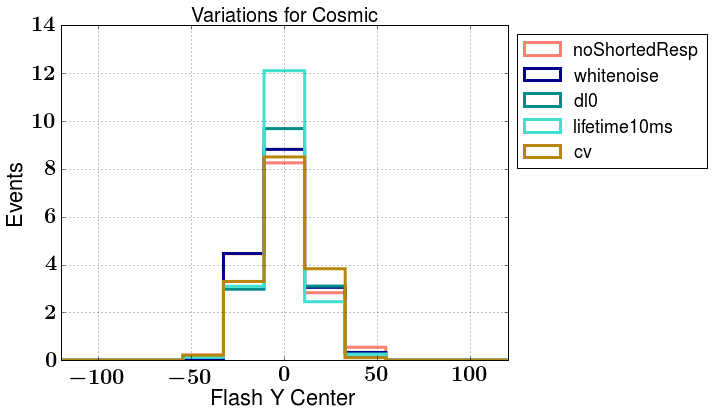

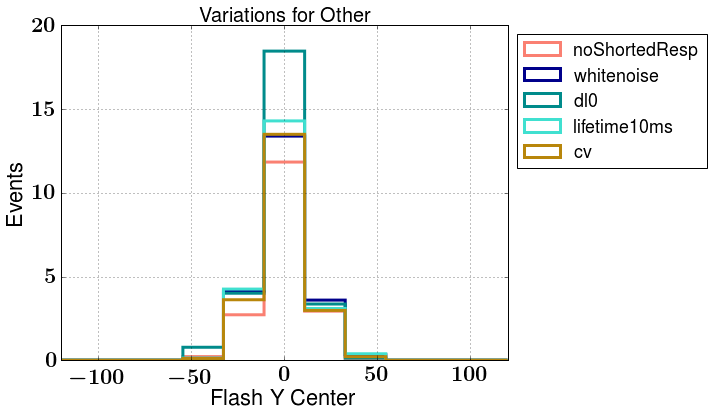

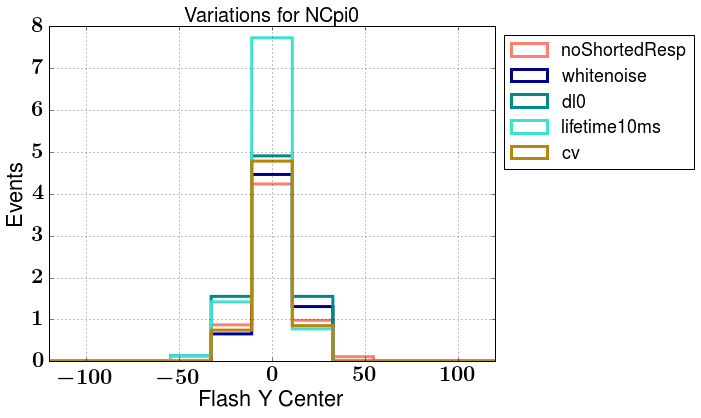

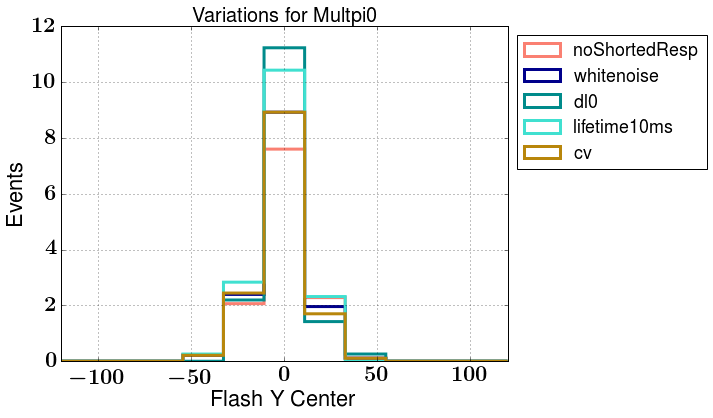

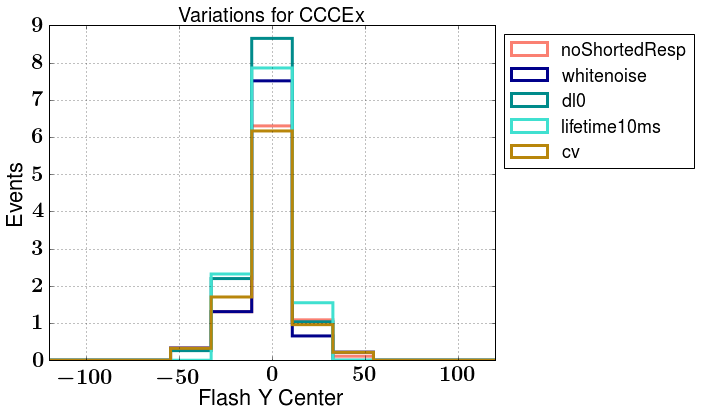

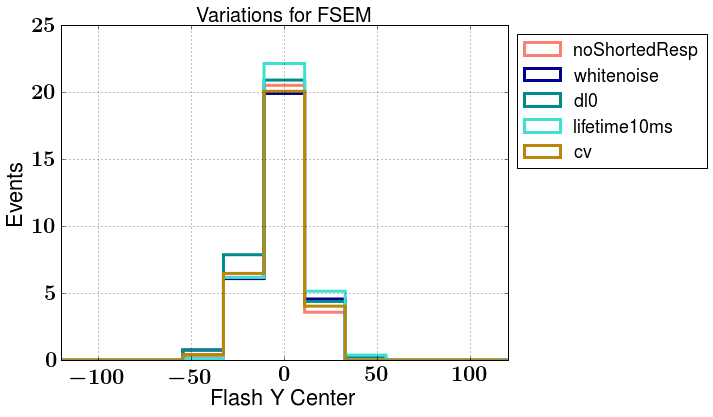

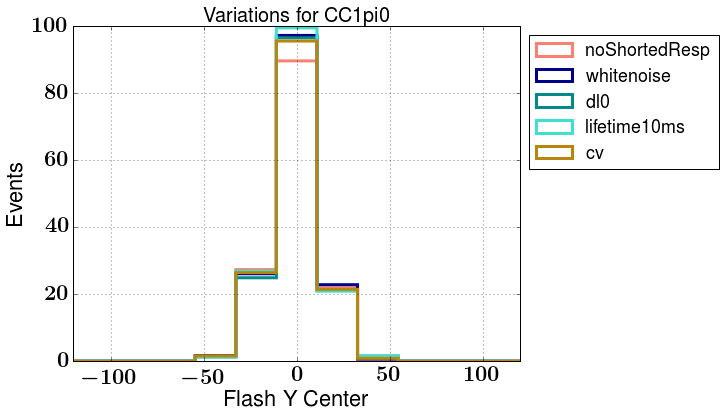

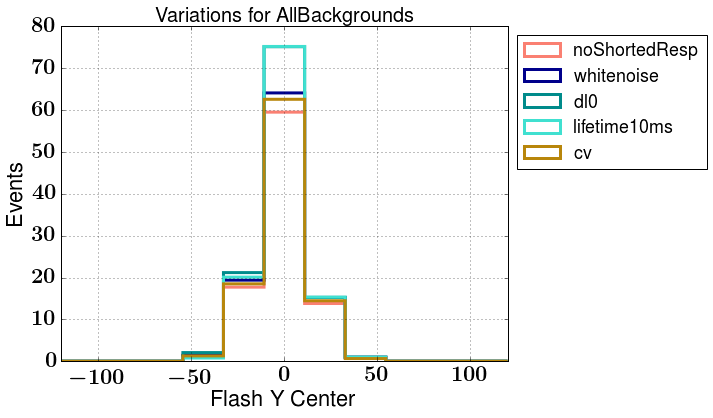

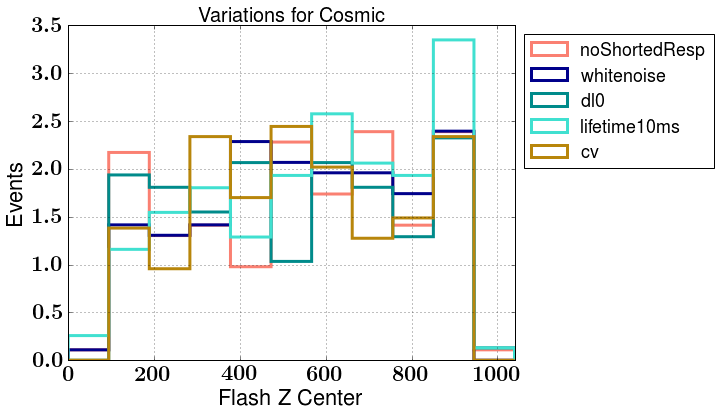

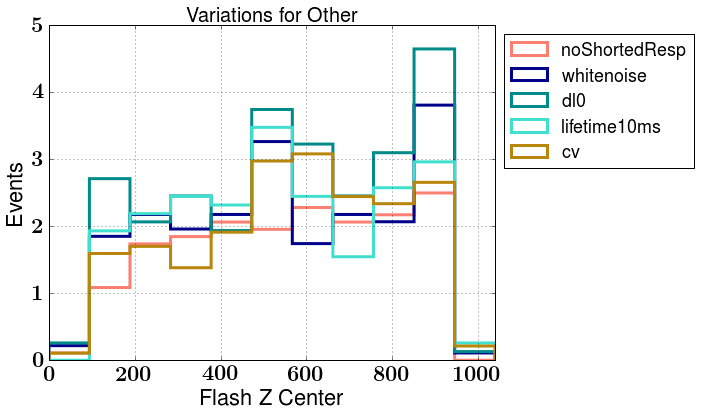

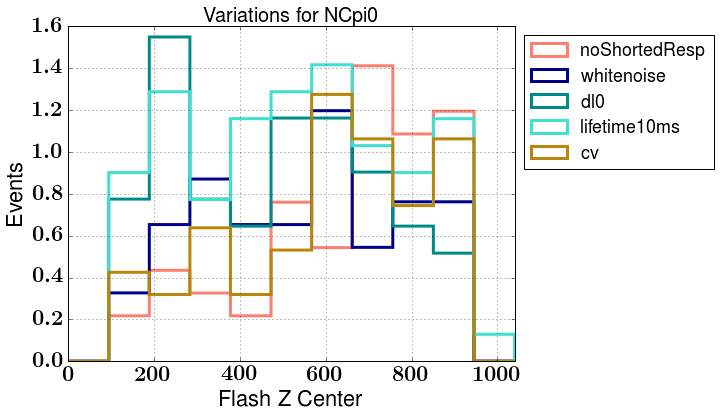

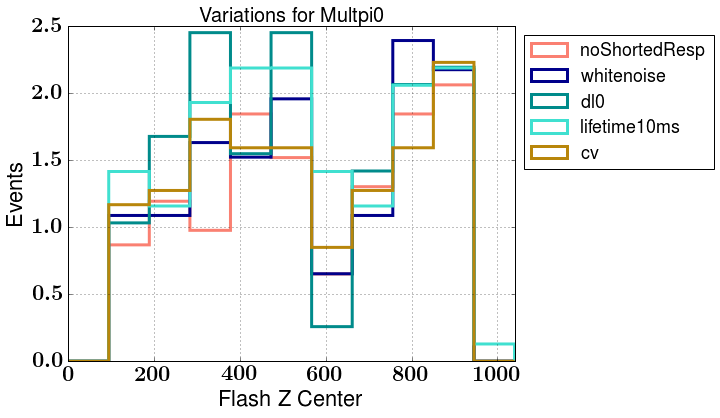

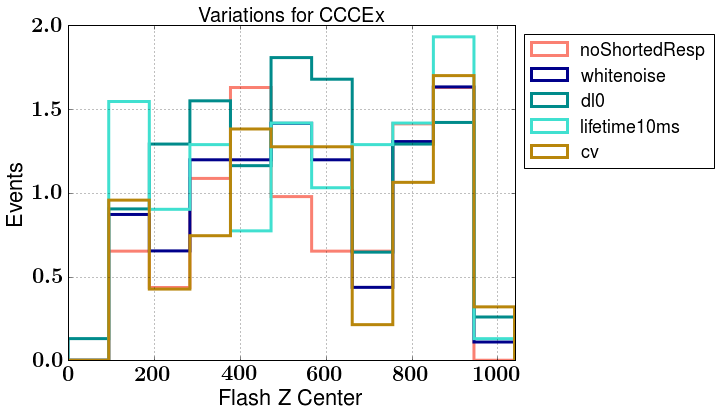

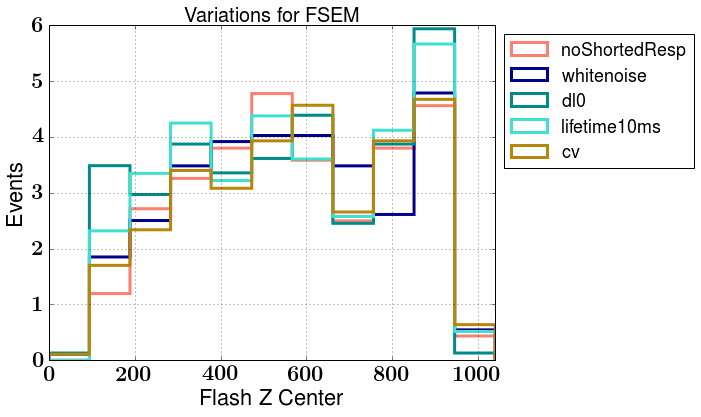

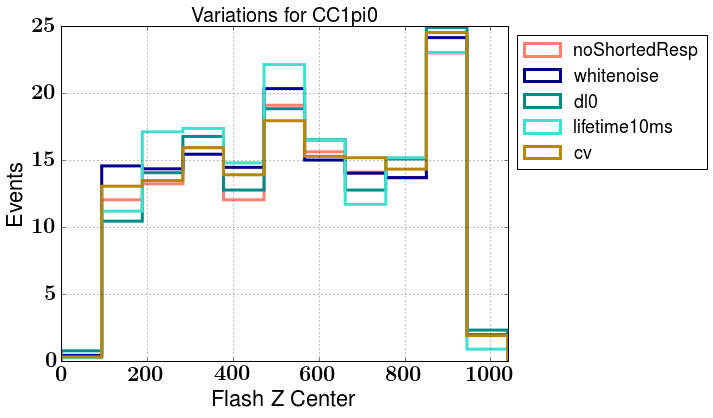

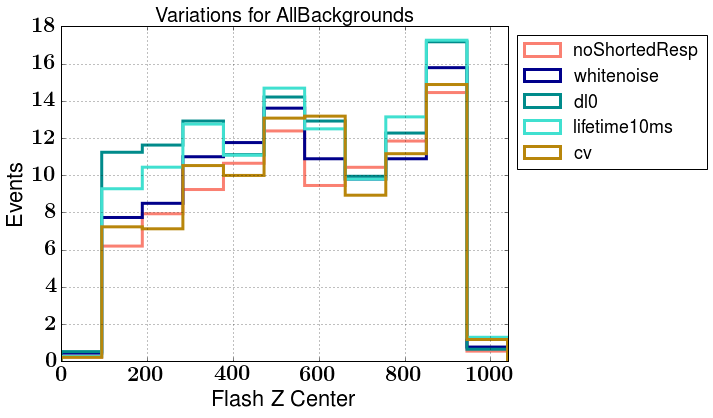

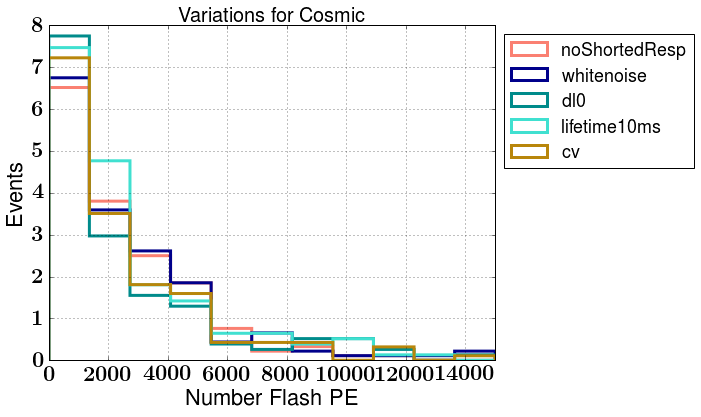

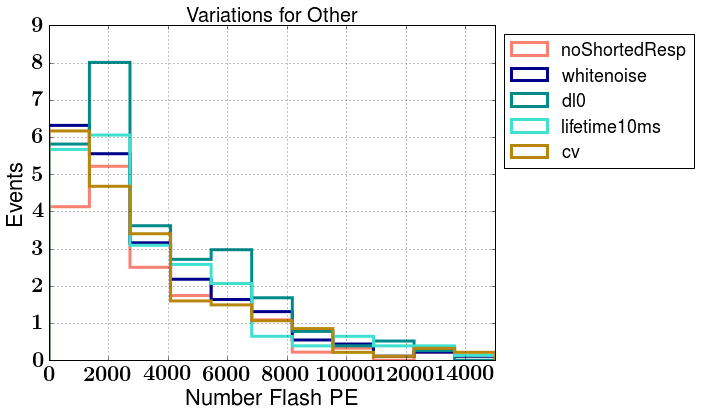

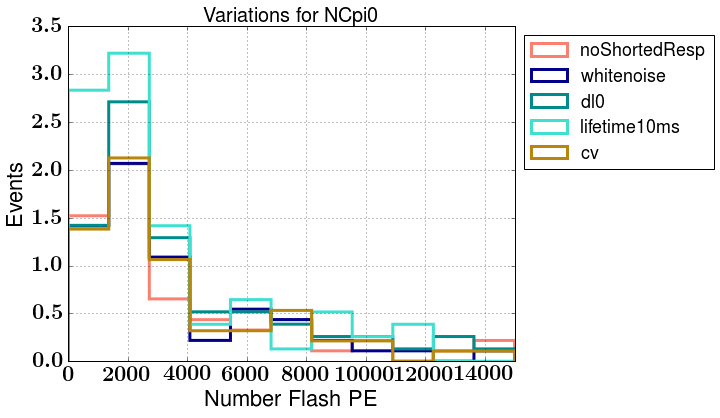

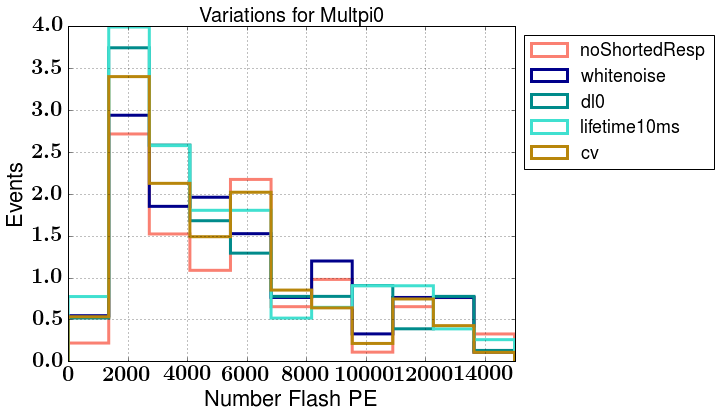

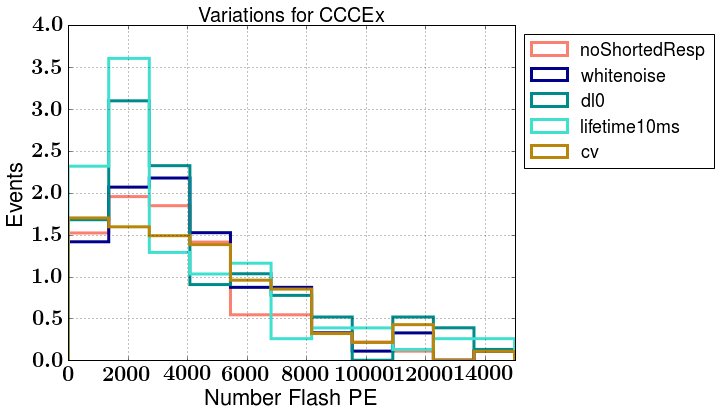

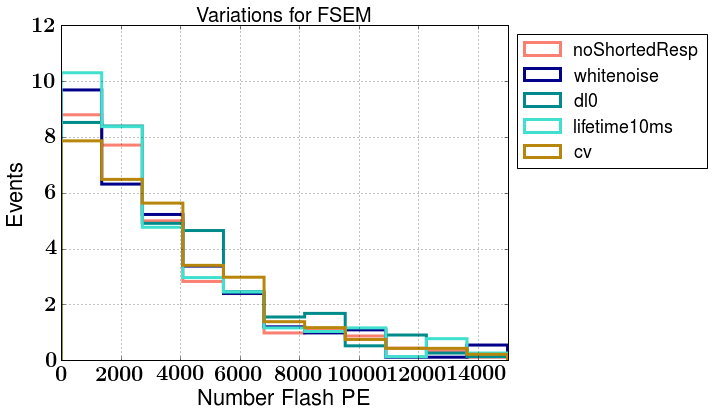

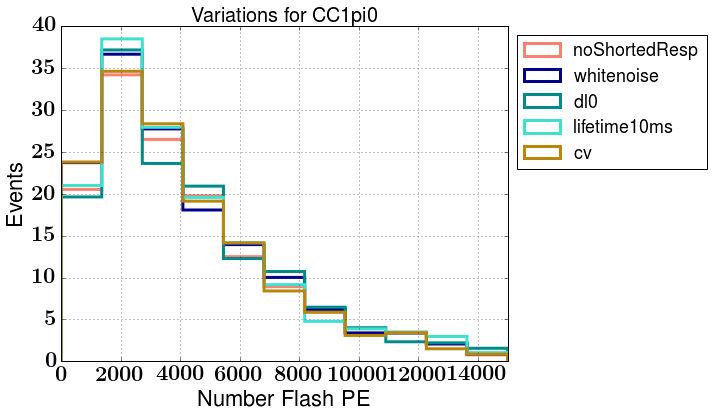

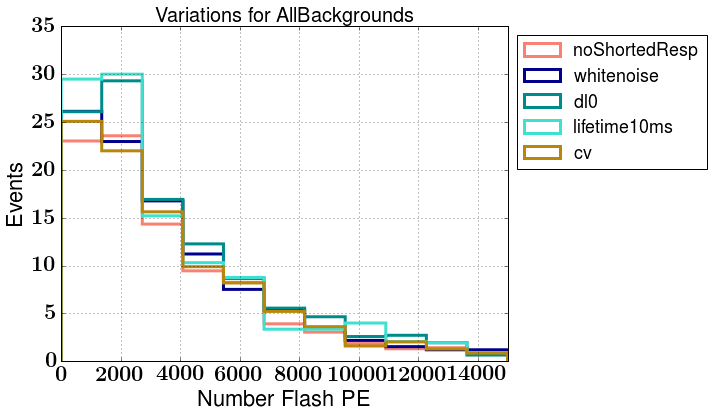

In [193]:
makeAbsNormPlots('gamma_E',0,425,nbins=12,xlabel='Clustered Tagged Shower Energy [MeV]',unit='MeV')
makeAbsNormPlots('gamma_RL',3.5,60,nbins=12,xlabel='Conversion Distance of Shower Candidate [cm]')
makeAbsNormPlots('gamma_IP_w_vtx',0,10,nbins=12,xlabel='Tagged Shower Impact Parameter with Vertex [cm]')
makeAbsNormPlots('gamma_pdg',-220,220,nbins=40,xlabel='Candidate Shower True PDG',unit='empty')
makeAbsNormPlots('gamma_perfect_clustering_E',0,700,nbins=11,xlabel='Perfect Clustering E [MeV]',unit='empty')
makeAbsNormPlots('gamma_cw_purity',0,1,nbins=11,xlabel='Shower Purity',unit='empty')
makeAbsNormPlots('gamma_cw_complete',0,1,nbins=11,xlabel='Shower Completeness',unit='empty')

makeAbsNormPlots('flash_y_center',-120,120,nbins=11,xlabel='Flash Y Center',unit='[cm]')
makeAbsNormPlots('flash_z_center',0,1040,nbins=11,xlabel='Flash Z Center',unit='[cm]')
makeAbsNormPlots('flash_pe',0,15000,nbins=11,xlabel='Number Flash PE',unit='#PE')
makeAbsNormPlots('flash_time',2.5,5.5,nbins=11,xlabel='Flash Time wrt Trigger [us]',unit='us')

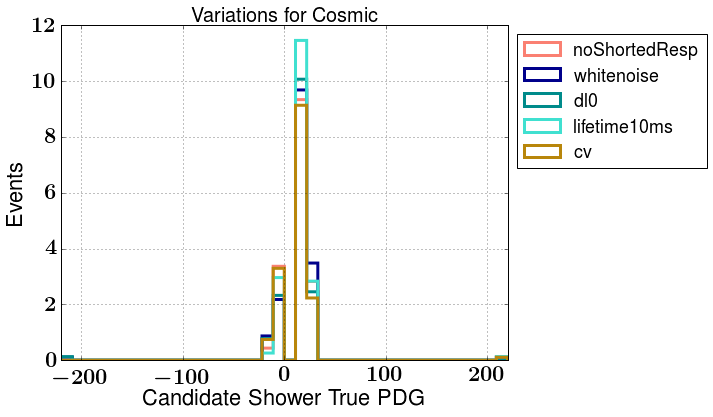

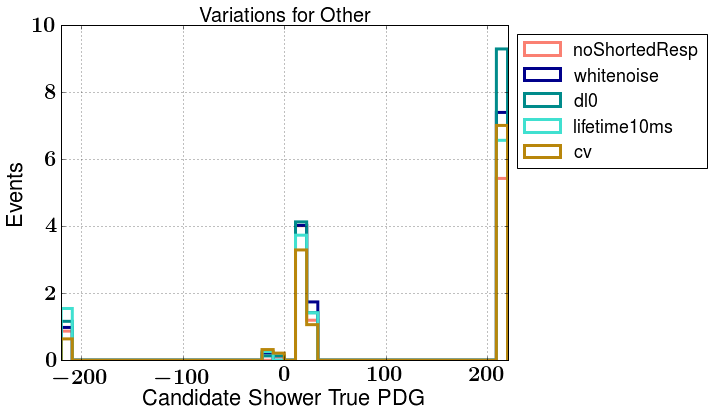

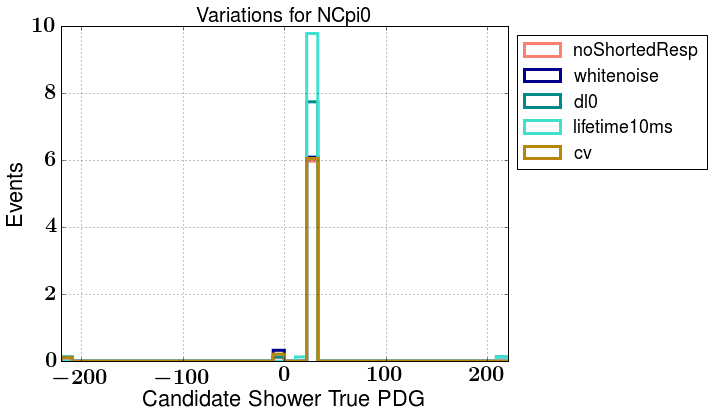

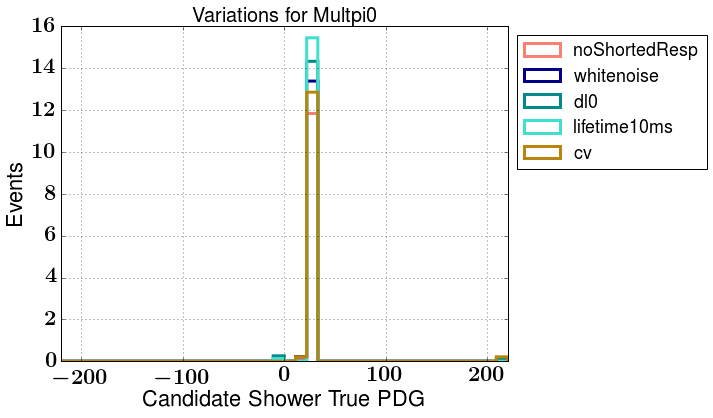

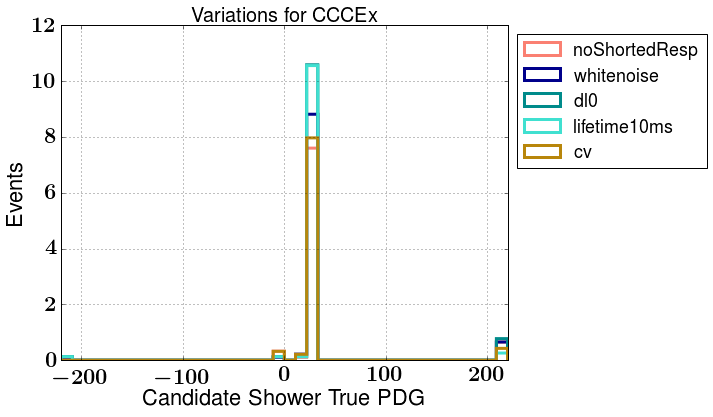

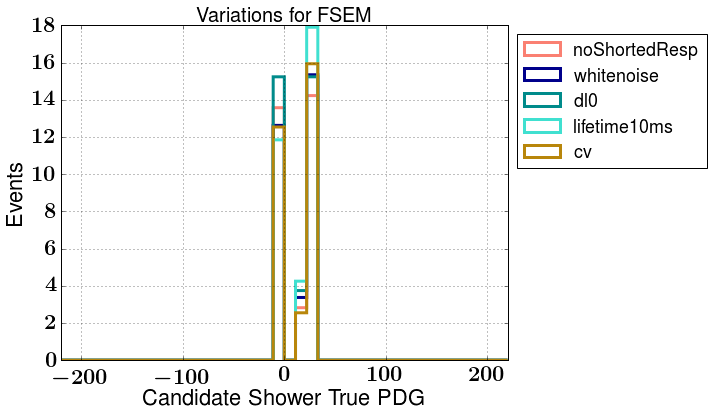

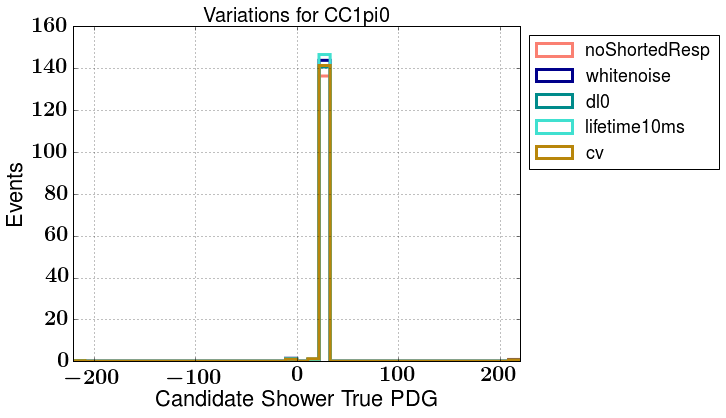

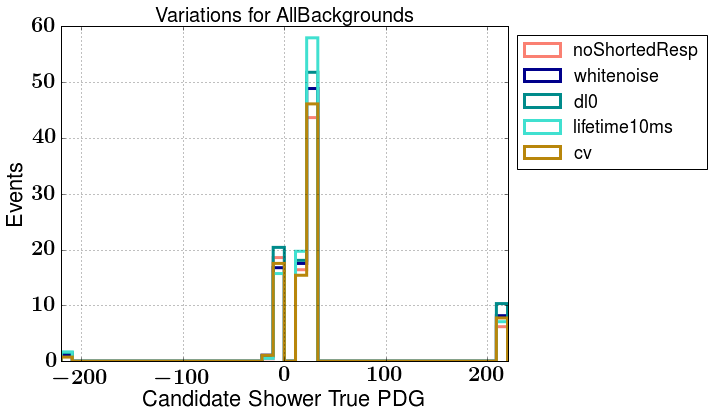

In [211]:
makeAbsNormPlots('gamma_pdg',-220,220,nbins=40,xlabel='Candidate Shower True PDG',unit='empty')


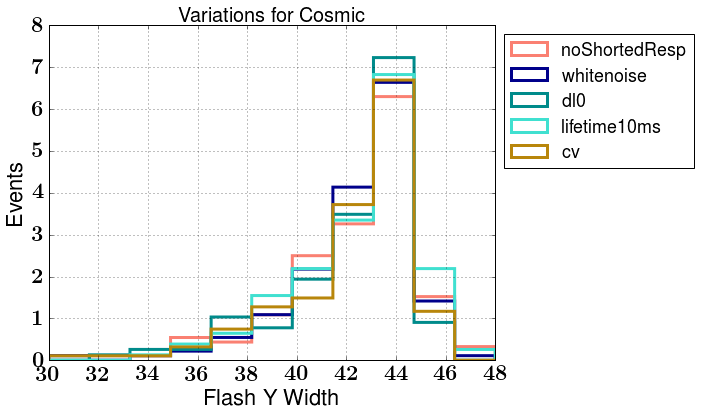

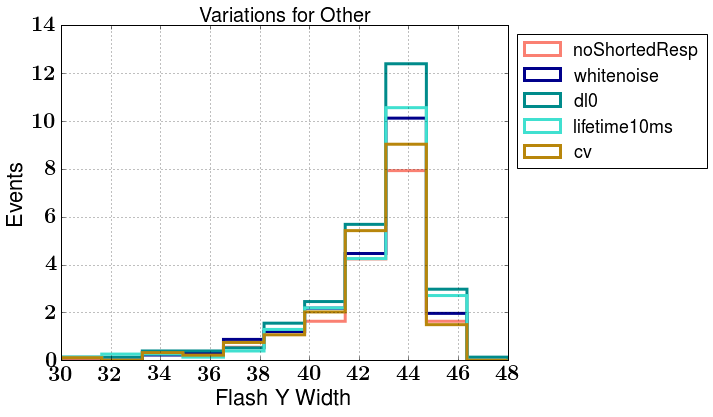

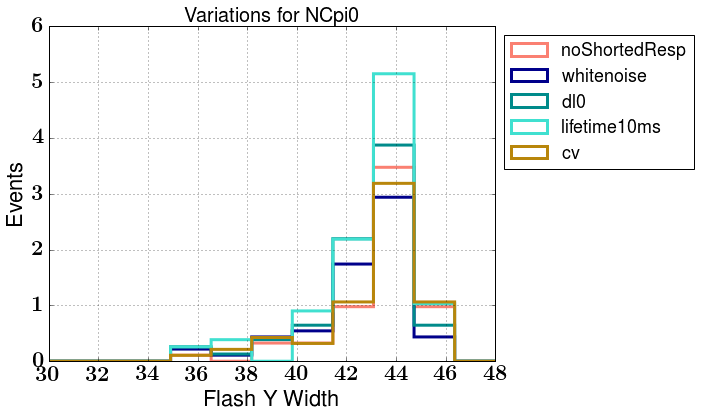

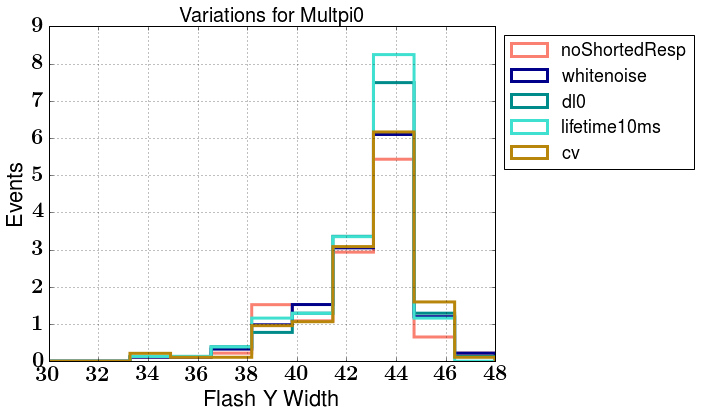

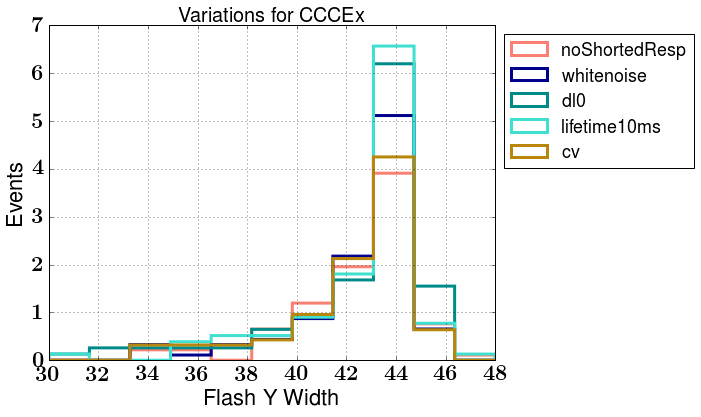

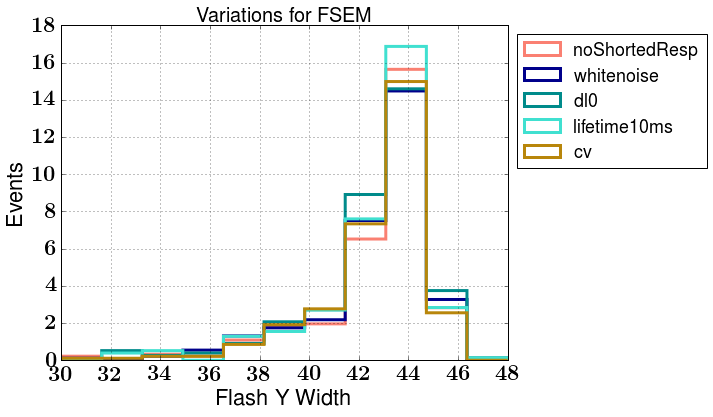

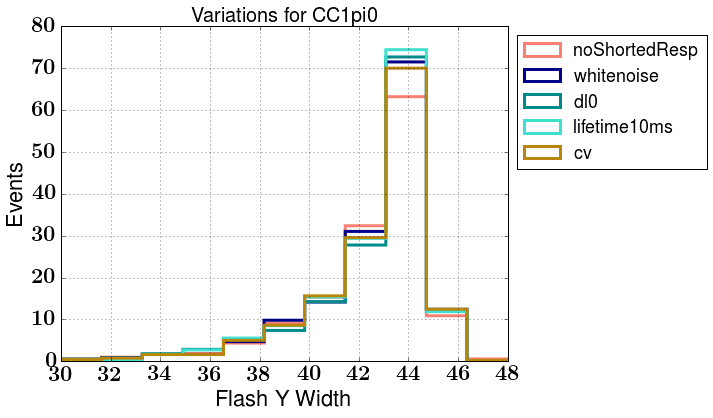

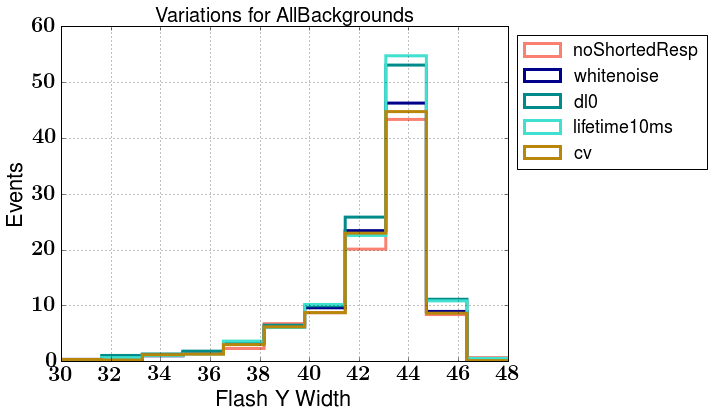

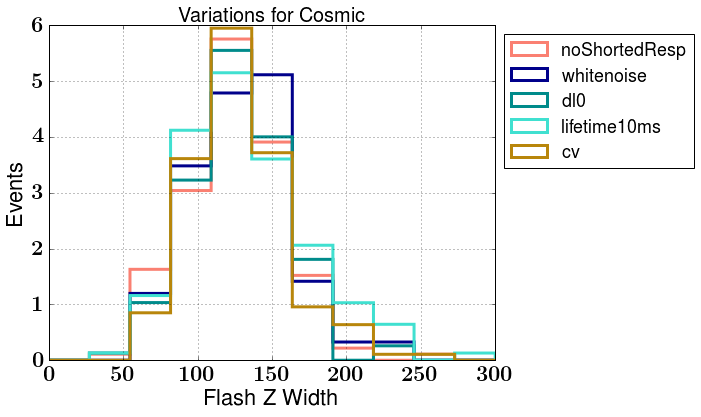

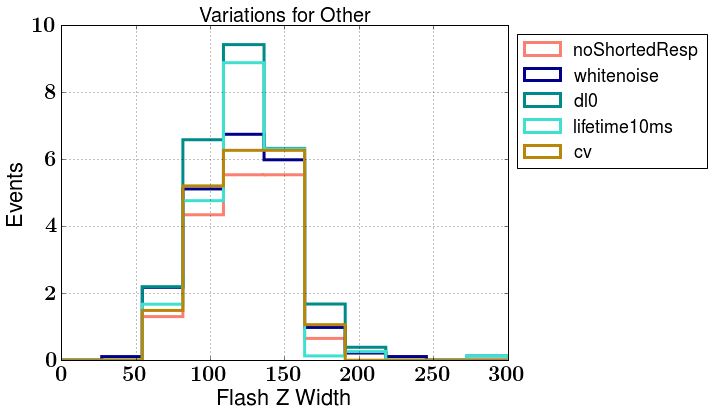

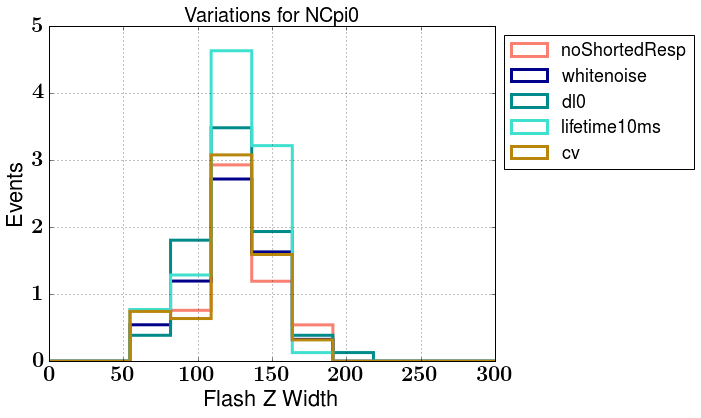

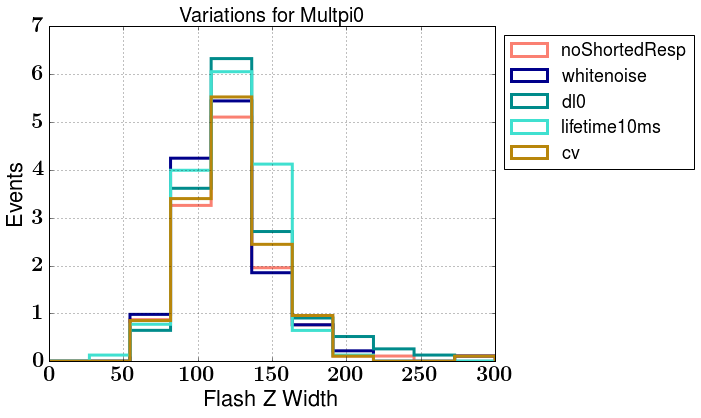

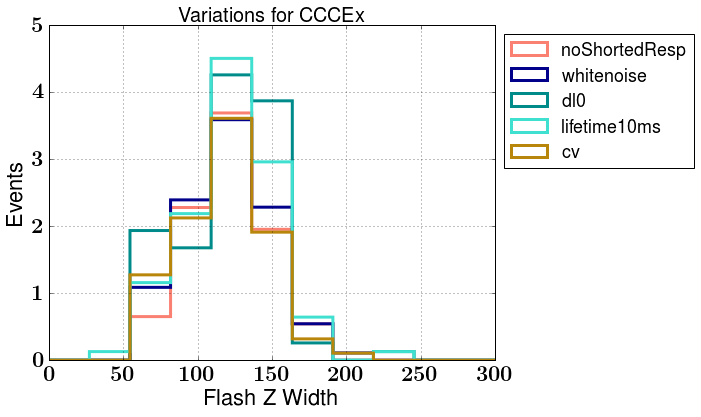

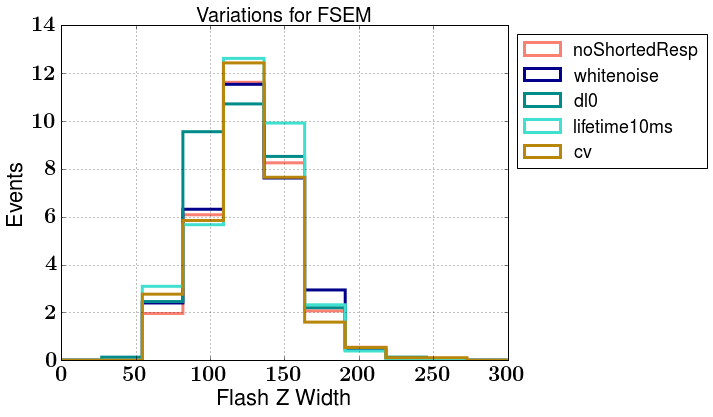

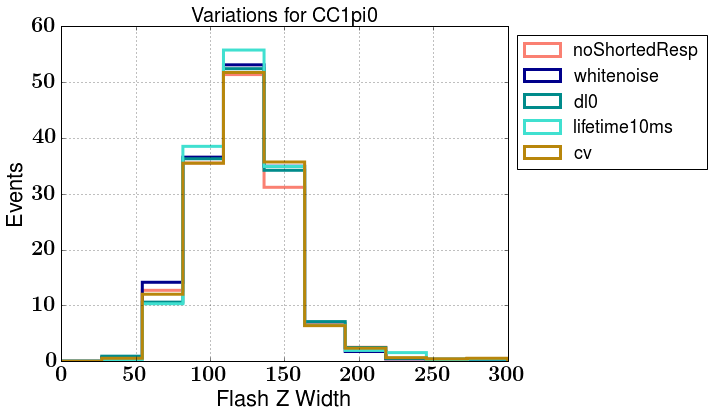

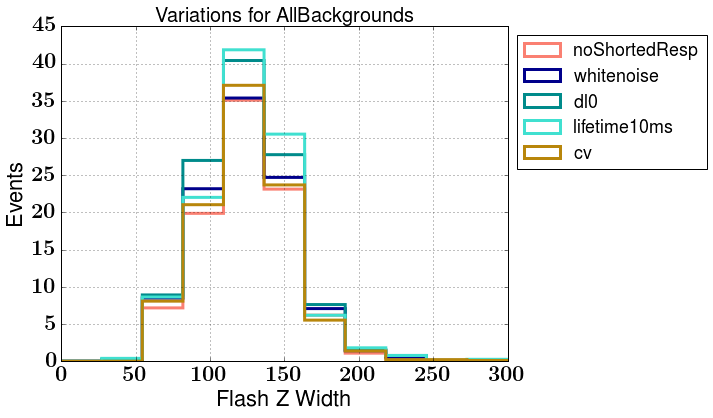

In [207]:
makeAbsNormPlots('flash_y_width',30,48,nbins=11,xlabel='Flash Y Width',unit='[cm]')
makeAbsNormPlots('flash_z_width',0,300,nbins=11,xlabel='Flash Z Width',unit='[cm]')


In [24]:
stage = 'sel2_nshr_gt0'

f = 'DetSysFiles/BT_backgrounds_sel2_'

var_v = ['cv','stretchResp','altDeadChannels','deadSaturatedChannels','noPEnoise','noShortedResp',\
         'whitenoise','nospacecharge','dicharge','enhancedexttpcvis','lifetime10ms','dl0','dt0',\
         'birksrecomb','lightyeild']

# Stored in same order as above var_v; all are e20
pot_v = [4.63,4.53,4.34,4.53,2.38,4.53,4.52,3.98,4.58,4.60,3.82,3.81,3.62,4.54,2.84]

# CV sample, 3 that are way higher than expected, and one that is lower than expected
var_v = ['cv','lifetime10ms','dl0','whitenoise','noShortedResp']

pot_v = [ 4.63,3.82,3.81,4.52,4.53]
scale_v = [ 0.492/pot_v[i] for i in xrange(len(pot_v)) ]

df_v = []
df_cos_v = []; df_cc1pi0_v = []; df_nc1pi0_v = []; df_multpi0_v = []; df_cccex_v = []
df_nu_EM_v = []; df_oth_v = []; df_all_but_sig_v = []

w_v = []
cos_w_v = []; cc1pi0_w_v = []; nc1pi0_w_v = []; multpi0_w_v = []; cccex_w_v = []
nu_EM_w_v = []; oth_w_v = []; all_but_sig_w_v = []

for i in xrange(len(var_v)):
    
    f_new = f + str(var_v[i]) + '.root'
    
    t = rn.root2array(f_new,treename='tree')
    df = pd.DataFrame(t)

    df['mu_endx'] = np.where(df.mu_startx-df.vtx_x == 0, df.mu_endx, df.mu_startx)
    df['mu_endy'] = np.where(df.mu_starty - df.vtx_y == 0, df.mu_endy, df.mu_starty)
    df['mu_endz'] = np.where(df.mu_startz - df.vtx_z == 0, df.mu_endz, df.mu_startz)

    df['mu_startx'] = df['vtx_x']
    df['mu_starty'] = df['vtx_y']
    df['mu_startz'] = df['vtx_z']
    df_v.append(df)
    
    #print 'Shape of %s sample is %d ' % (var_v[i],df.shape[0])
    dfa = df.query('nshrs > 0')
    cos_v = df.query('bkgd_id == 1 and nshrs > 0')
    cc1pi0_v = df.query('bkgd_id == 2 and nshrs > 0')
    nc1pi0_v = df.query('bkgd_id == 3 and nshrs > 0')
    multpi0_v = df.query('bkgd_id == 5 and nshrs > 0')
    cccex_v = df.query('bkgd_id == 8 and nshrs > 0 ')
    nu_EM_v = df.query('(bkgd_id == 4 or bkgd_id == 9 or bkgd_id == 10 or bkgd_id==11 or\
                          bkgd_id ==12 or bkgd_id ==13)  and nshrs > 0')
    oth_v = df.query('(bkgd_id == 0 or bkgd_id == 6 or bkgd_id == 7) and nshrs > 0')
    all_but_sig_v = df.query('bkgd_id != 2 and nshrs > 0')

    print var_v[i], cc1pi0_v.shape[0], all_but_sig_v.shape[0], dfa.shape[0]
    
    df_cos_v.append(cos_v)
    df_cc1pi0_v.append(cc1pi0_v)
    df_nc1pi0_v.append(nc1pi0_v)
    df_multpi0_v.append(multpi0_v)
    df_cccex_v.append(cccex_v)
    df_nu_EM_v.append(nu_EM_v)
    df_oth_v.append(oth_v)
    df_all_but_sig_v.append(all_but_sig_v)
    
    scale = scale_v[i]

    cos_w = [ scale for i in xrange(cos_v.shape[0]) ] 
    oth_w = [ scale for i in xrange(oth_v.shape[0]) ] 
    nc1pi0_w = [ scale for i in xrange(nc1pi0_v.shape[0]) ] 
    multpi0_w = [ scale for i in xrange(multpi0_v.shape[0]) ] 
    cccex_w = [ scale for i in xrange(cccex_v.shape[0]) ] 
    nu_EM_w = [ scale for i in xrange(nu_EM_v.shape[0]) ] 
    oth_w = [ scale for i in xrange(oth_v.shape[0]) ] 
    cc1pi0_w = [ scale for i in xrange(cc1pi0_v.shape[0]) ] 
    all_but_sig_w = [ scale for i in xrange(all_but_sig_v.shape[0]) ] 

    cos_w_v.append(cos_w)
    cc1pi0_w_v.append(cc1pi0_w)
    nc1pi0_w_v.append(nc1pi0_w)
    multpi0_w_v.append(multpi0_w)
    cccex_w_v.append(cccex_w)
    nu_EM_w_v.append(nu_EM_w)
    oth_w_v.append(oth_w)
    all_but_sig_w_v.append(all_but_sig_w)

    
df_bkgd_v = [df_cos_v,df_oth_v,df_nc1pi0_v,df_multpi0_v,df_cccex_v,df_nu_EM_v,df_cc1pi0_v,df_all_but_sig_v]
w_v = [cos_w_v,oth_w_v,nc1pi0_w_v,multpi0_w_v,cccex_w_v,nu_EM_w_v,cc1pi0_w_v,all_but_sig_w_v]

cv 2040 2451 4491
lifetime10ms 1769 2163 3932
dl0 1726 2252 3978
whitenoise 2058 2424 4482
noShortedResp 2007 2337 4344


In [34]:
list(df)

['event_id',
 'subrun_id',
 'run_id',
 'event',
 'bkgd_id',
 'nu_mode',
 'nshrs',
 'vtx_x',
 'vtx_y',
 'vtx_z',
 'mc_vtx_x',
 'mc_vtx_y',
 'mc_vtx_z',
 'mc_scecorr_vtx_x',
 'mc_scecorr_vtx_y',
 'mc_scecorr_vtx_z',
 'flash_time',
 'flash_pe',
 'flash_y_center',
 'flash_z_center',
 'flash_y_width',
 'flash_z_width',
 'mu_true_angle',
 'mu_true_phi',
 'mu_true_mom',
 'mu_true_startx',
 'mu_true_starty',
 'mu_true_startz',
 'mu_true_endx',
 'mu_true_endy',
 'mu_true_endz',
 'mu_angle',
 'mu_len',
 'mu_startx',
 'mu_starty',
 'mu_startz',
 'mu_endx',
 'mu_endy',
 'mu_endz',
 'mu_phi',
 'mult',
 'mu_purity',
 'mu_complete',
 'mu_cw_purity',
 'mu_cw_complete',
 'mu_origin',
 'mu_type',
 'mu_pdg',
 'mu_mother_pdg',
 'n_mcs_at_vtx',
 'n_reco_at_vtx',
 'pi0_mass',
 'pi0_oangle',
 'pi0_true_oangle',
 'pi0_IP',
 'pi0_mom',
 'pi0_low_radL',
 'pi0_low_IP_w_vtx',
 'pi0_low_purity',
 'pi0_low_complete',
 'pi0_low_cw_purity',
 'pi0_low_cw_complete',
 'pi0_low_true_gammaE',
 'pi0_low_true_detProf_gammaE

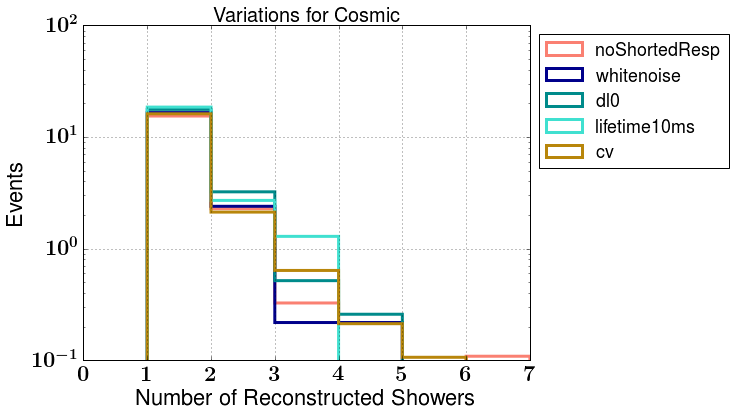

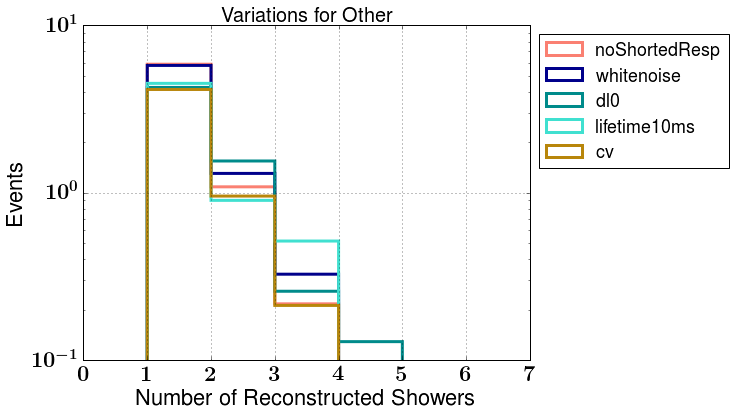

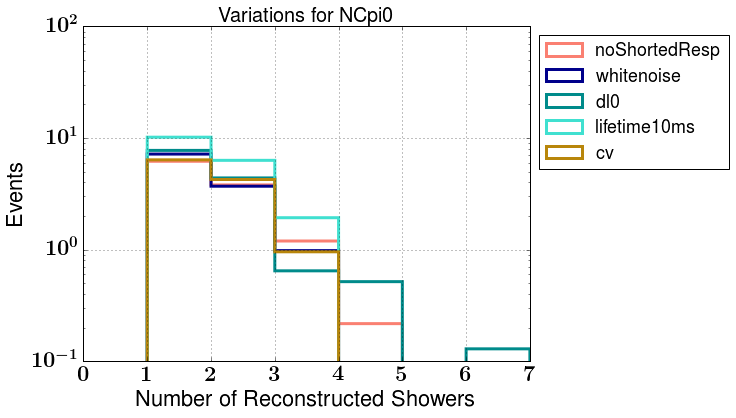

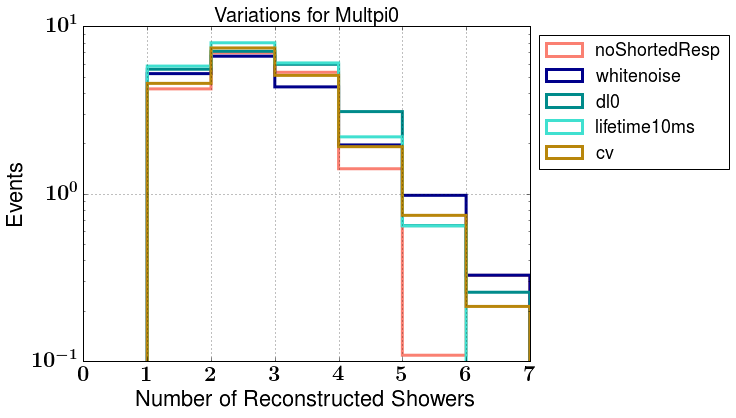

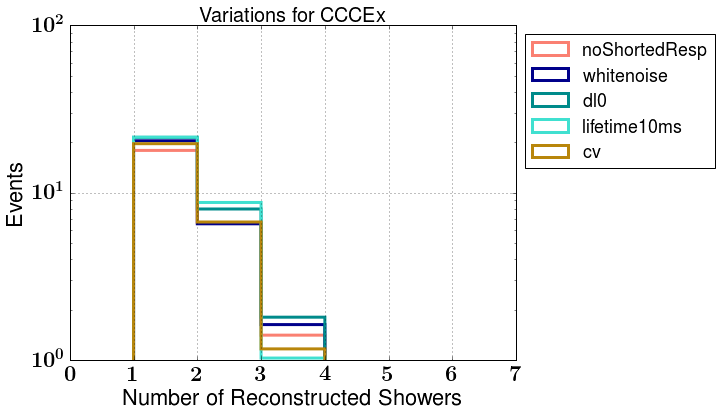

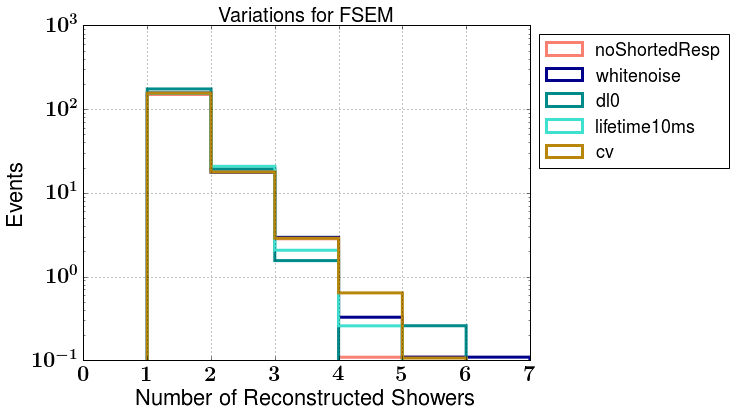

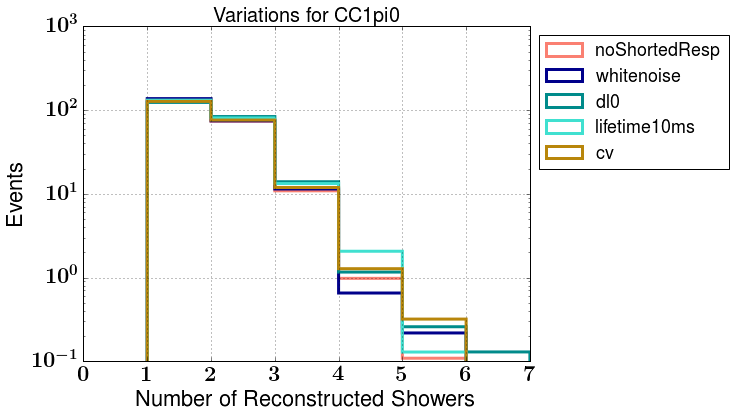

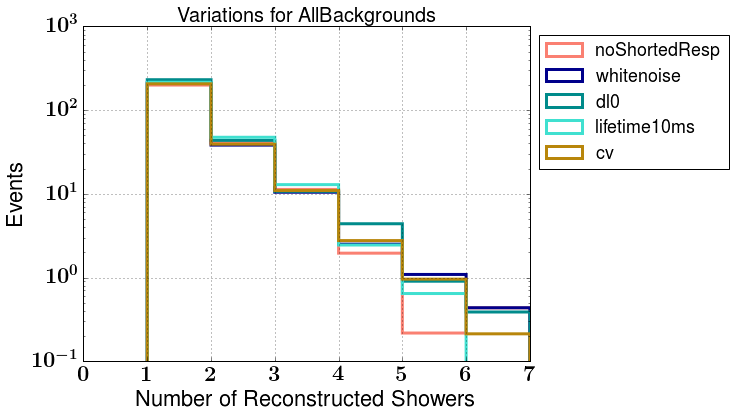

In [19]:
makeAbsNormPlots('nshrs',0,7,nbins=7,xlabel='Number of Reconstructed Showers',unit='empty')


In [25]:
f = 'DetSysFiles/BT_backgrounds_one_'

var_v = ['cv','lifetime10ms','dl0','whitenoise','noShortedResp']
pot_v = [ 4.63,3.82,3.81,4.52,4.53]
scale_v = [ 0.492/pot_v[i] for i in xrange(len(pot_v)) ]

df_v = []
df_cos_v = []; df_cc1pi0_v = []; df_nc1pi0_v = []; df_multpi0_v = []; df_cccex_v = []
df_nu_EM_v = []; df_oth_v = []; df_all_but_sig_v = []

w_v = []
cos_w_v = []; cc1pi0_w_v = []; nc1pi0_w_v = []; multpi0_w_v = []; cccex_w_v = []
nu_EM_w_v = []; oth_w_v = []; all_but_sig_w_v = []

for i in xrange(len(var_v)):
    
    f_new = f + str(var_v[i]) + '.root'
    
    t = rn.root2array(f_new,treename='shower_tree')
    df = pd.DataFrame(t)
    df_v.append(df)
    
    #print 'Shape of %s sample is %d ' % (var_v[i],df.shape[0])
    dfa = df.query('shr_origin != 2 and shr_origin != -1')
    cos_v = df.query('bkgd_id == 1 or shr_origin == 2')
    cc1pi0_v = dfa.query('bkgd_id == 2')
    nc1pi0_v = dfa.query('bkgd_id == 3')
    multpi0_v = dfa.query('bkgd_id == 5')
    cccex_v = dfa.query('bkgd_id == 8 ')
    nu_EM_v = dfa.query('((bkgd_id == 4 or bkgd_id == 9 or bkgd_id == 10 or bkgd_id==11 or\
                     bkgd_id ==12 or bkgd_id ==13) & (shr_type == 1) )')

    oth_v = dfa.query('bkgd_id == 0 or bkgd_id == 6 or bkgd_id == 7 or\
                        ((bkgd_id == 4 or bkgd_id == 9 or bkgd_id == 10 or bkgd_id == 11 or\
                      bkgd_id ==12 or bkgd_id ==13) & shr_type != 1)')
    all_but_sig_v = df.query('bkgd_id != 2 or (bkgd_id == 2 and shr_origin != 1 )')

    df_cos_v.append(cos_v)
    df_cc1pi0_v.append(cc1pi0_v)
    df_nc1pi0_v.append(nc1pi0_v)
    df_multpi0_v.append(multpi0_v)
    df_cccex_v.append(cccex_v)
    df_nu_EM_v.append(nu_EM_v)
    df_oth_v.append(oth_v)
    df_all_but_sig_v.append(all_but_sig_v)
    print all_but_sig_v.shape[0] + cc1pi0_v.shape[0], df.shape[0]
    
df_bkgd_v = [df_cos_v,df_oth_v,df_nc1pi0_v,df_multpi0_v,df_cccex_v,df_nu_EM_v,df_cc1pi0_v,df_all_but_sig_v]

4749 4748
4216 4216
4120 4120
4681 4681
4419 4419


/Library/Python/2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in divide


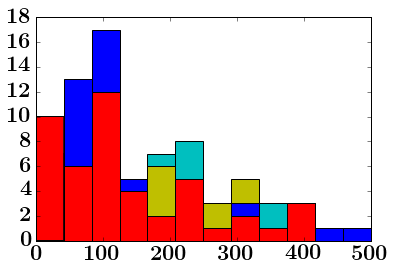

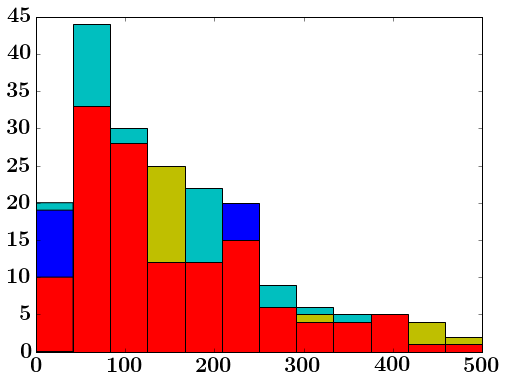

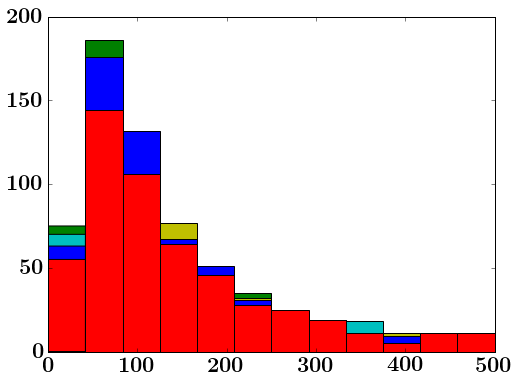

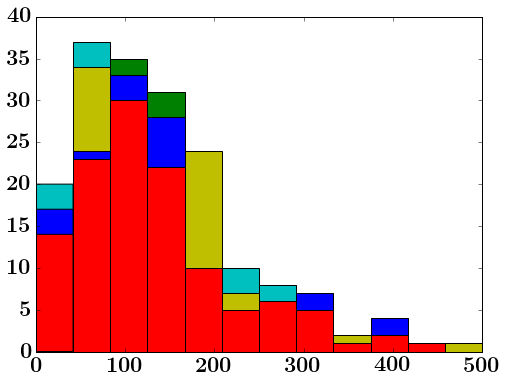

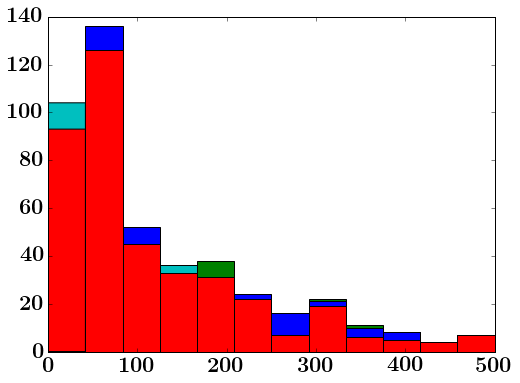

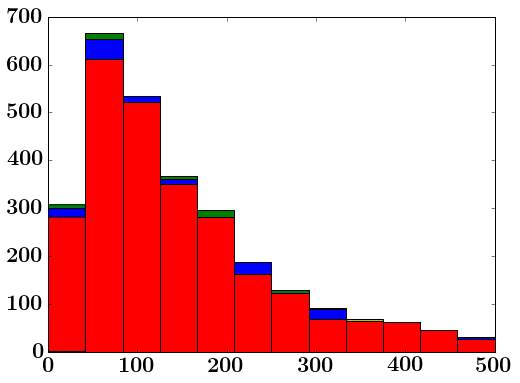

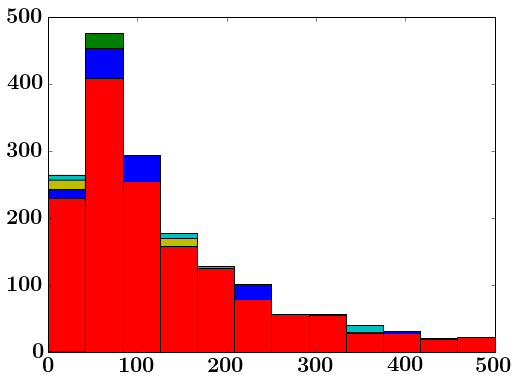

In [26]:
bkgd_label_v = ['Cosmic','Other','NCpi0','Multpi0','CCCEx','FSEM','CC1pi0','AllBackgrounds']
labels_tst = ['cv','lifetime10ms','dl0','whitenoise','noShortedResp']
colors_tst = ['darkgoldenrod','turquoise','darkcyan','darkblue','salmon'] 
nbins = 12

for i in xrange(1,len(bkgd_label_v)):

    df_bkgd = df_bkgd_v[i]
    bkgd_label = bkgd_label_v[i]

    ratio_v = []
    
    for j in xrange(len(df_bkgd)):
        #cv_v = df_bkgd[0]; lt_v = df_bkgd[1]; dl0_v = df_bkgd[2]; wn_v = df_bkgd[3]; noShort_v = df_bkgd[4]   
        detsys_j = df_bkgd[j]
        df_reco_j = detsys_j.query('shr_n_reco > 0')
        
        countsreco,edges,_ = plt.hist(df_reco_j.shr_trueE_detProf.values,bins=nbins,range=(0,500))
        countsmc,_,_ = plt.hist(detsys_j.shr_trueE_detProf.values,bins=nbins,range=(0,500))
        bins = (edges[:-1] + edges[1:])/2
        ratio_v.append(countsreco/countsmc)
        
    fig,ax = plt.subplots(figsize=(8,6))
    for k in xrange(len(df_bkgd)):
        plt.plot(bins,ratio_v[k],'-',marker='o',label='%s'%labels_tst[k],color=colors_tst[k])
    
    plt.ylim(0,1)
    plt.xlabel('True Deposited Energy [MeV]',weight='bold')
    plt.legend(loc=0,fontsize=14) #'upper left',bbox_to_anchor=(1,0.5))
    plt.ylabel('Individual Shower Reco Efficiency',weight='bold')
    plt.grid(True)
    plt.title('Variations for %s'%(str(bkgd_label)),fontsize=20)
    #plt.xlim(xmin,xmax)

    lgd = plt.legend(fontsize=legendfont,loc='upper left',bbox_to_anchor=(1,1))    
    plt.savefig('Plots/DetSys_ShowerRecoEff_%s.png'%(bkgd_label),bbox_extra_artists=(lgd,),bbox_inches='tight')
    plt.clf()

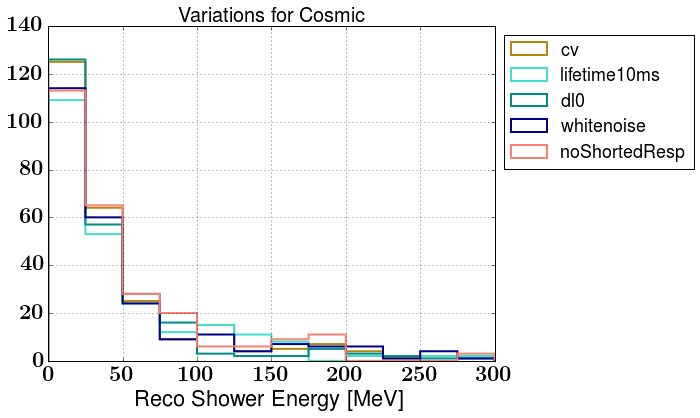

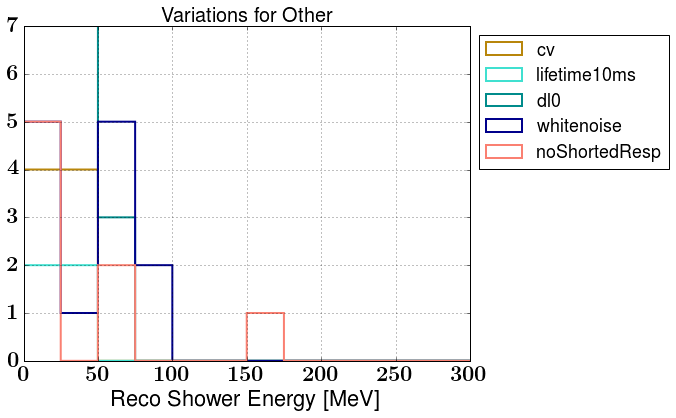

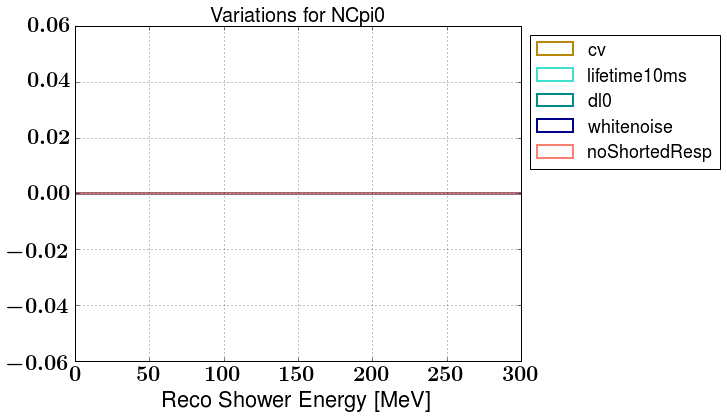

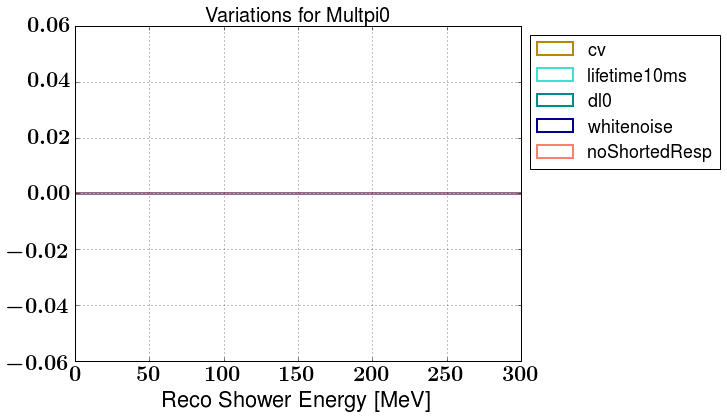

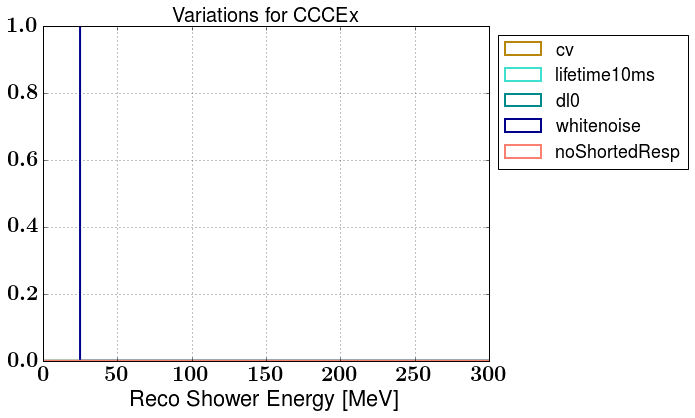

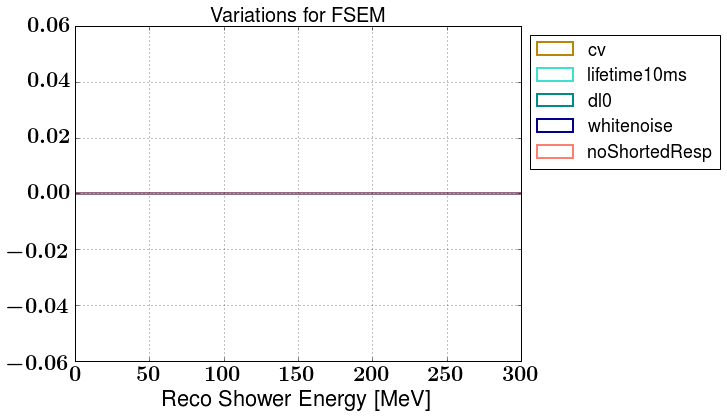

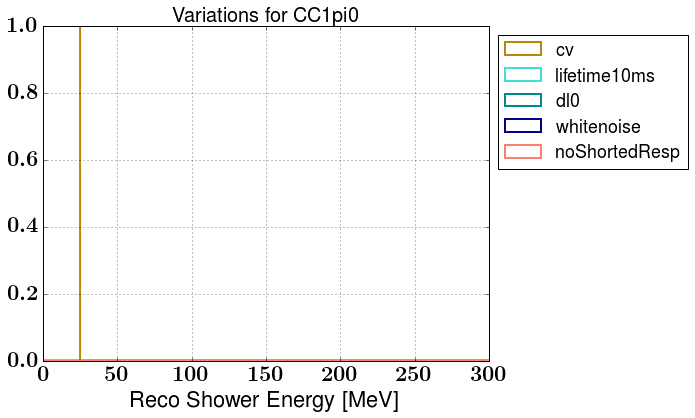

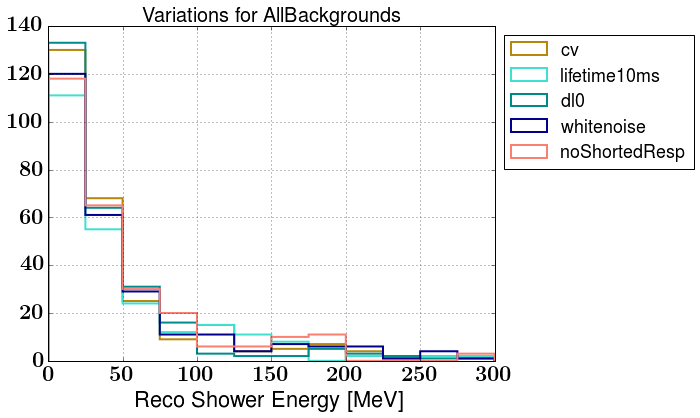

In [31]:
bkgd_label_v = ['Cosmic','Other','NCpi0','Multpi0','CCCEx','FSEM','CC1pi0','AllBackgrounds']
labels_tst = ['cv','lifetime10ms','dl0','whitenoise','noShortedResp']
colors_tst = ['darkgoldenrod','turquoise','darkcyan','darkblue','salmon'] 
nbins = 12

for i in xrange(len(bkgd_label_v)):

    df_bkgd = df_bkgd_v[i]
    bkgd_label = bkgd_label_v[i]

    #print bkgd_label
    
    fig,ax = plt.subplots(figsize=(8,6))
    
    for j in xrange(len(df_bkgd)):
        #cv_v = df_bkgd[0]; lt_v = df_bkgd[1]; dl0_v = df_bkgd[2]; wn_v = df_bkgd[3]; noShort_v = df_bkgd[4]   
        detsys_j = df_bkgd[j]
        df_reco_j = detsys_j.query('shr_origin != 1')    
        #print df_reco_j.shape[0]
        plt.hist(df_reco_j.shr_energy.values,bins=nbins,range=(0,300),label='%s'%labels_tst[j],\
                 histtype='step',color=colors_tst[j],lw=2)
        bins = (edges[:-1] + edges[1:])/2
        ratio_v.append(countsreco/countsmc)
           
    plt.xlabel('Reco Shower Energy [MeV]',weight='bold')
    plt.legend(loc=0,fontsize=14) #'upper left',bbox_to_anchor=(1,0.5))
    
    #plt.ylabel('Individual Shower Reco Efficiency',weight='bold')
    plt.grid(True)
    plt.title('Variations for %s'%(str(bkgd_label)),fontsize=20)
    #plt.xlim(xmin,xmax)

    lgd = plt.legend(fontsize=legendfont,loc='upper left',bbox_to_anchor=(1,1))    
    plt.savefig('Plots/DetSys_RecoEnergy_%s.png'%(bkgd_label),bbox_extra_artists=(lgd,),bbox_inches='tight')
    #plt.clf()

In [56]:
f = 'DetSysFiles/BT_backgrounds_sel2_'

var_v = ['cv','lifetime10ms','dl0','whitenoise','noShortedResp']
pot_v = [ 4.63,3.82,3.81,4.52,4.53]
scale_v = [ 0.492/pot_v[i] for i in xrange(len(pot_v)) ]

df_v = []
df_cos_v = []; df_cc1pi0_v = []; df_nc1pi0_v = []; df_multpi0_v = []; df_cccex_v = []
df_nu_EM_v = []; df_oth_v = []; df_all_but_sig_v = []

w_v = []
cos_w_v = []; cc1pi0_w_v = []; nc1pi0_w_v = []; multpi0_w_v = []; cccex_w_v = []
nu_EM_w_v = []; oth_w_v = []; all_but_sig_w_v = []

for i in xrange(len(var_v)):
    
    f_new = f + str(var_v[i]) + '.root'
    
    t = rn.root2array(f_new,treename='shower_tree')
    df = pd.DataFrame(t)
    df_v.append(df)
    
    #print 'Shape of %s sample is %d ' % (var_v[i],df.shape[0])
    dfa = df.query('shr_origin != 2 and shr_origin != -1')
    cos_v = df.query('bkgd_id == 1 or shr_origin == 2')
    cc1pi0_v = dfa.query('bkgd_id == 2')
    nc1pi0_v = dfa.query('bkgd_id == 3')
    multpi0_v = dfa.query('bkgd_id == 5')
    cccex_v = dfa.query('bkgd_id == 8 ')
    nu_EM_v = dfa.query('((bkgd_id == 4 or bkgd_id == 9 or bkgd_id == 10 or bkgd_id==11 or\
                     bkgd_id ==12 or bkgd_id ==13) & (shr_type == 1) )')

    oth_v = dfa.query('bkgd_id == 0 or bkgd_id == 6 or bkgd_id == 7 or\
                        ((bkgd_id == 4 or bkgd_id == 9 or bkgd_id == 10 or bkgd_id == 11 or\
                      bkgd_id ==12 or bkgd_id ==13) & shr_type != 1)')
    all_but_sig_v = df.query('bkgd_id != 8 or bkgd_id != 2 or (bkgd_id == 2 and shr_origin != 1 )')

    df_cos_v.append(cos_v)
    df_cc1pi0_v.append(cc1pi0_v)
    df_nc1pi0_v.append(nc1pi0_v)
    df_multpi0_v.append(multpi0_v)
    df_cccex_v.append(cccex_v)
    df_nu_EM_v.append(nu_EM_v)
    df_oth_v.append(oth_v)
    df_all_but_sig_v.append(all_but_sig_v)
    print all_but_sig_v.shape[0] + cc1pi0_v.shape[0], df.shape[0]

    scale = scale_v[i]

    cos_w = [ scale for i in xrange(cos_v.shape[0]) ] 
    oth_w = [ scale for i in xrange(oth_v.shape[0]) ] 
    nc1pi0_w = [ scale for i in xrange(nc1pi0_v.shape[0]) ] 
    multpi0_w = [ scale for i in xrange(multpi0_v.shape[0]) ] 
    cccex_w = [ scale for i in xrange(cccex_v.shape[0]) ] 
    nu_EM_w = [ scale for i in xrange(nu_EM_v.shape[0]) ] 
    oth_w = [ scale for i in xrange(oth_v.shape[0]) ] 
    cc1pi0_w = [ scale for i in xrange(cc1pi0_v.shape[0]) ] 
    all_but_sig_w = [ scale for i in xrange(all_but_sig_v.shape[0]) ] 

    cos_w_v.append(cos_w)
    cc1pi0_w_v.append(cc1pi0_w)
    nc1pi0_w_v.append(nc1pi0_w)
    multpi0_w_v.append(multpi0_w)
    cccex_w_v.append(cccex_w)
    nu_EM_w_v.append(nu_EM_w)
    oth_w_v.append(oth_w)
    all_but_sig_w_v.append(all_but_sig_w)

    
    
df_bkgd_v = [df_cos_v,df_oth_v,df_nc1pi0_v,df_multpi0_v,df_cccex_v,df_nu_EM_v,df_cc1pi0_v,df_all_but_sig_v]
w_v = [cos_w_v,oth_w_v,nc1pi0_w_v,multpi0_w_v,cccex_w_v,nu_EM_w_v,cc1pi0_w_v,all_but_sig_w_v]

15658 10275
13866 9176
13274 8806
15553 10153
15161 9887


/Library/Python/2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in divide


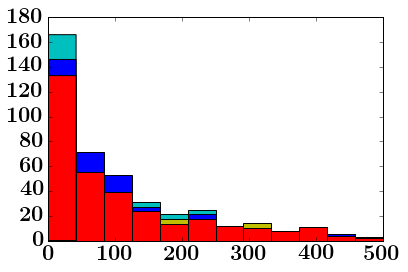

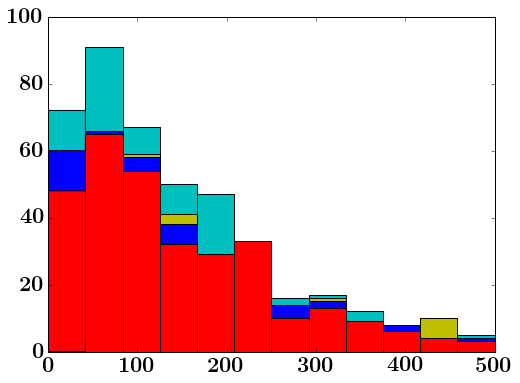

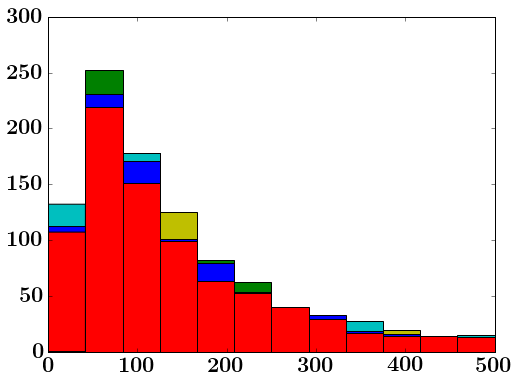

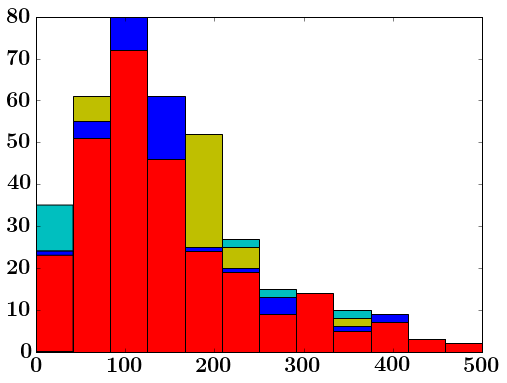

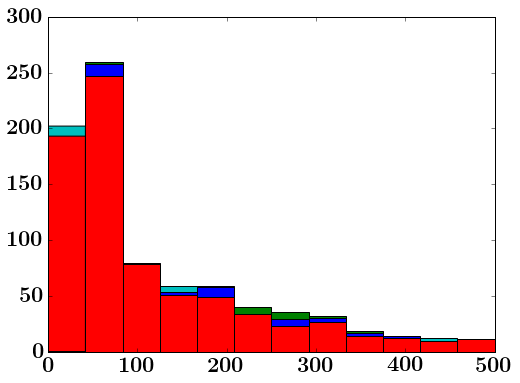

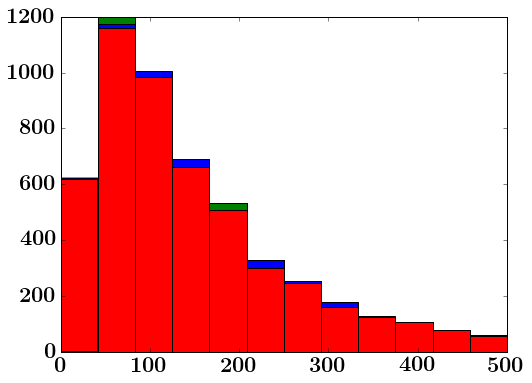

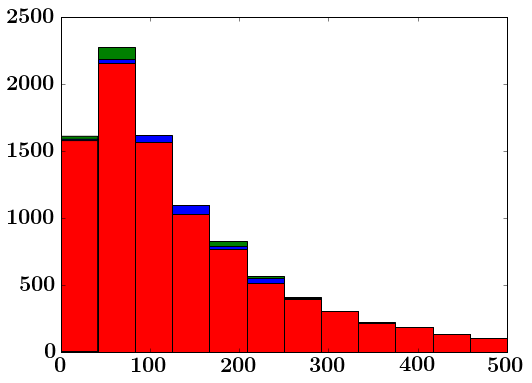

In [57]:
bkgd_label_v = ['Cosmic','Other','NCpi0','Multpi0','CCCEx','FSEM','CC1pi0','AllBackgrounds']
labels_tst = ['cv','lifetime10ms','dl0','whitenoise','noShortedResp']
colors_tst = ['darkgoldenrod','turquoise','darkcyan','darkblue','salmon'] 
nbins = 12

for i in xrange(1,len(bkgd_label_v)):

    df_bkgd = df_bkgd_v[i]
    bkgd_label = bkgd_label_v[i]

    ratio_v = []
    
    for j in xrange(len(df_bkgd)):
        #cv_v = df_bkgd[0]; lt_v = df_bkgd[1]; dl0_v = df_bkgd[2]; wn_v = df_bkgd[3]; noShort_v = df_bkgd[4]   
        detsys_j = df_bkgd[j]
        df_reco_j = detsys_j.query('shr_n_reco > 0')
        
        countsreco,edges,_ = plt.hist(df_reco_j.shr_trueE_detProf.values,bins=nbins,range=(0,500))
        countsmc,_,_ = plt.hist(detsys_j.shr_trueE_detProf.values,bins=nbins,range=(0,500))
        bins = (edges[:-1] + edges[1:])/2
        ratio_v.append(countsreco/countsmc)
        
    fig,ax = plt.subplots(figsize=(8,6))
    for k in xrange(len(df_bkgd)):
        plt.plot(bins,ratio_v[k],'-',marker='o',label='%s'%labels_tst[k],color=colors_tst[k])
    
    plt.ylim(0,1)
    plt.xlabel('True Deposited Energy [MeV]',weight='bold')
    plt.legend(loc=0,fontsize=14) #'upper left',bbox_to_anchor=(1,0.5))
    plt.ylabel('Individual Shower Reco Efficiency',weight='bold')
    plt.grid(True)
    plt.title('Variations for %s'%(str(bkgd_label)),fontsize=20)
    #plt.xlim(xmin,xmax)

    lgd = plt.legend(fontsize=legendfont,loc='upper left',bbox_to_anchor=(1,1))    
    plt.savefig('Plots/DetSys_sel2_ShowerRecoEff_%s.png'%(bkgd_label),bbox_extra_artists=(lgd,),bbox_inches='tight')
    plt.clf()

In [58]:
#list(df)

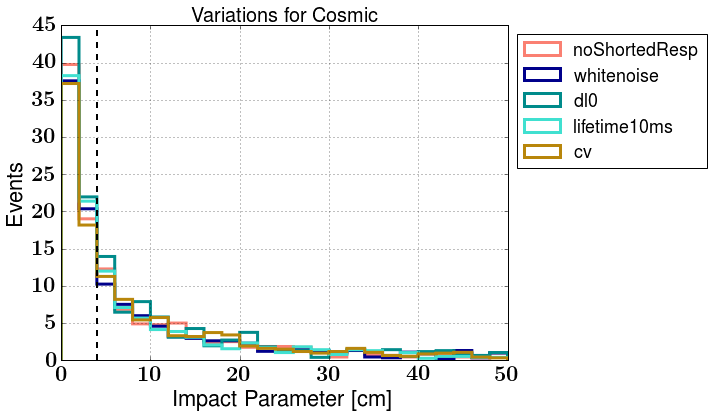

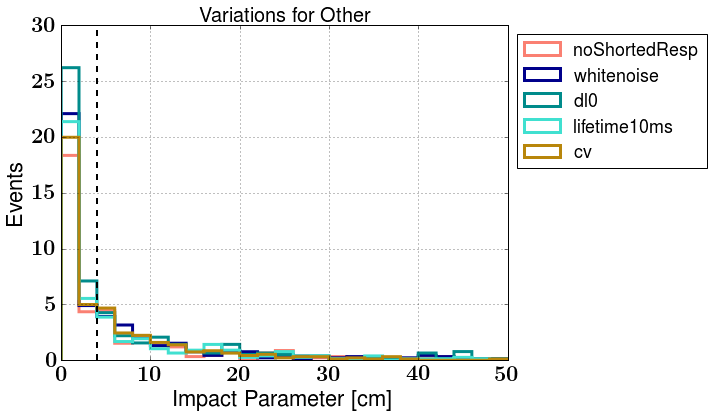

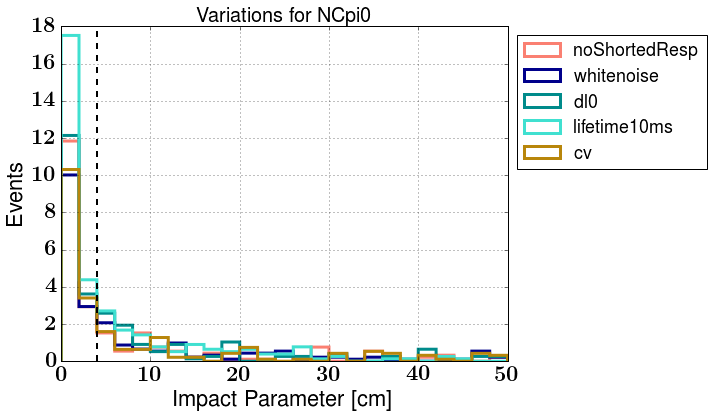

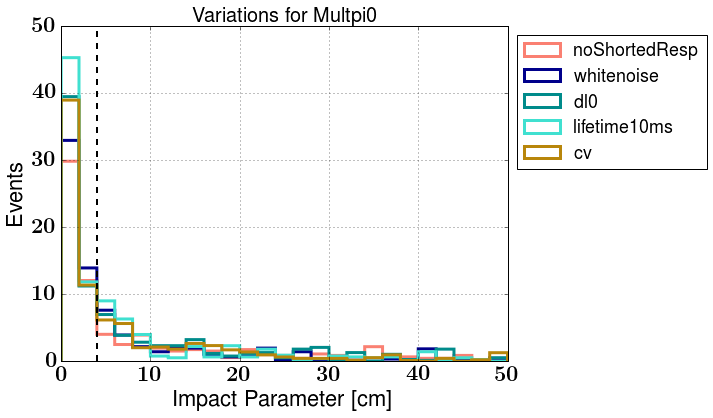

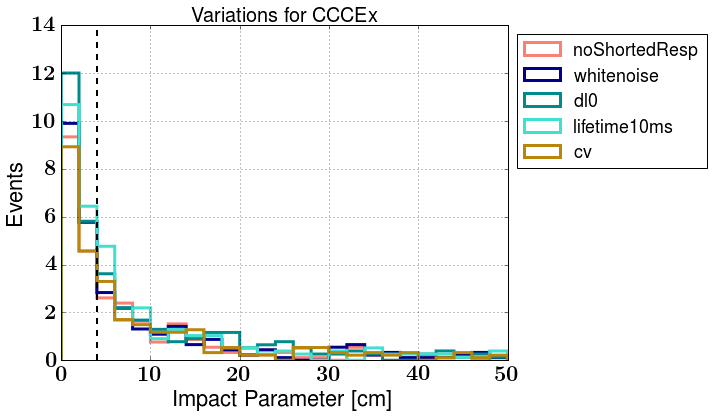

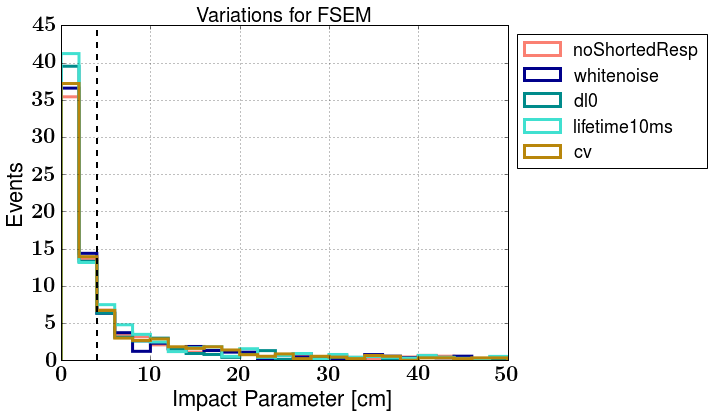

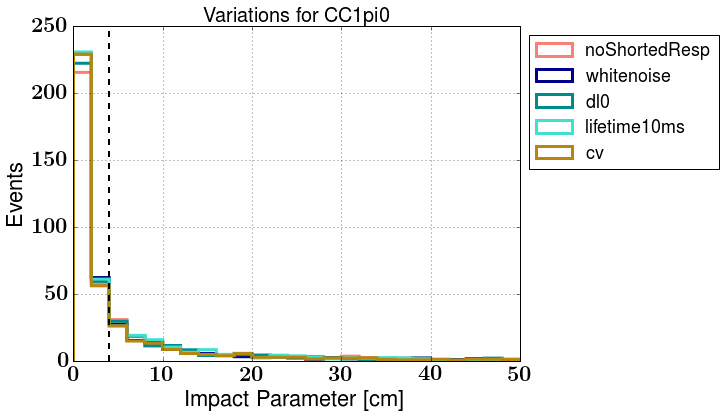

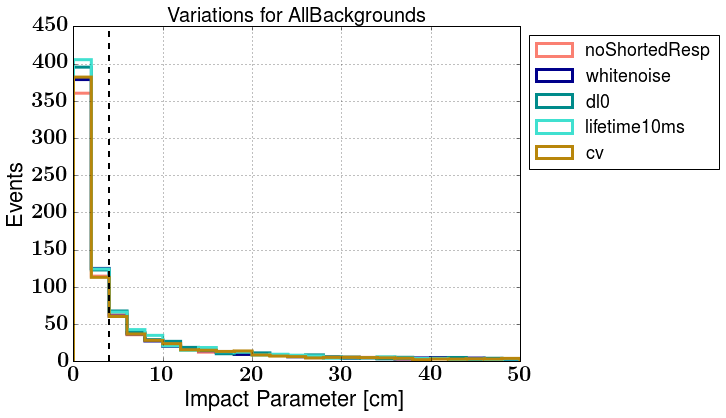

In [69]:
makeAbsNormPlots('shr_ip',0,50,nbins=25,xlabel='Impact Parameter [cm]',cut=4)


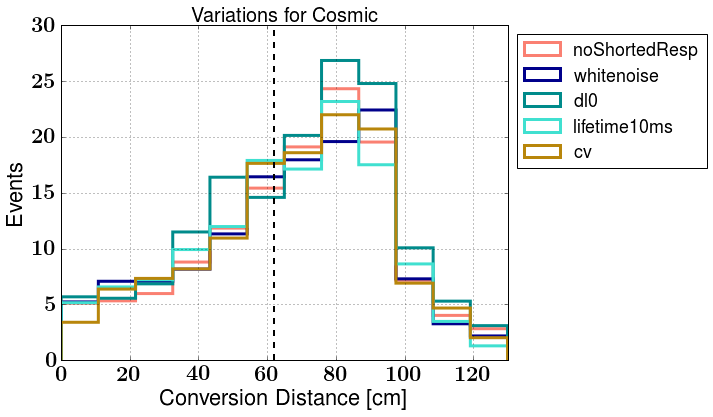

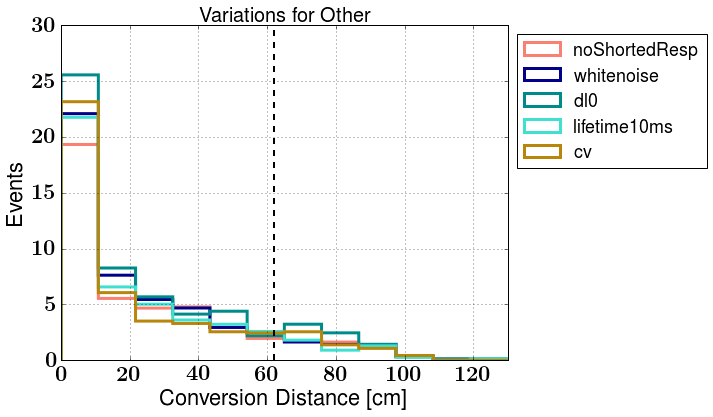

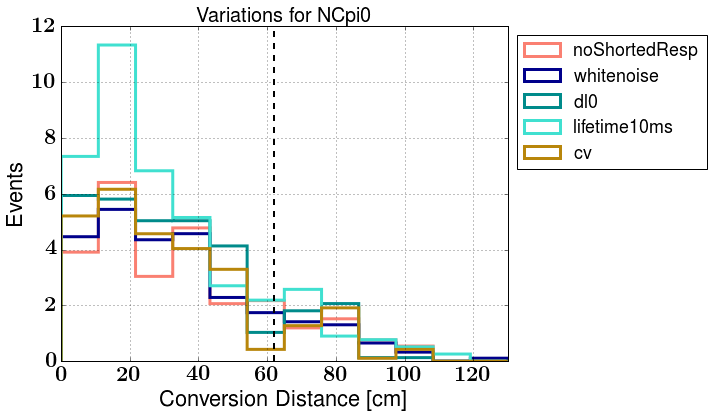

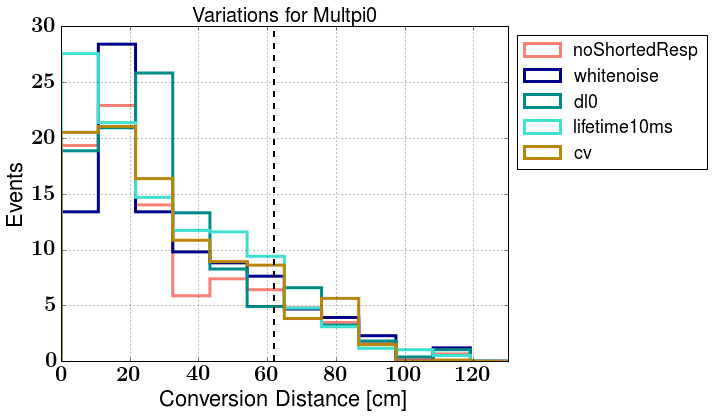

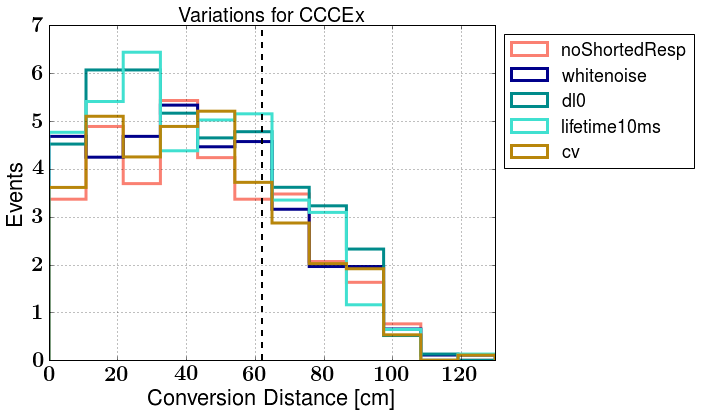

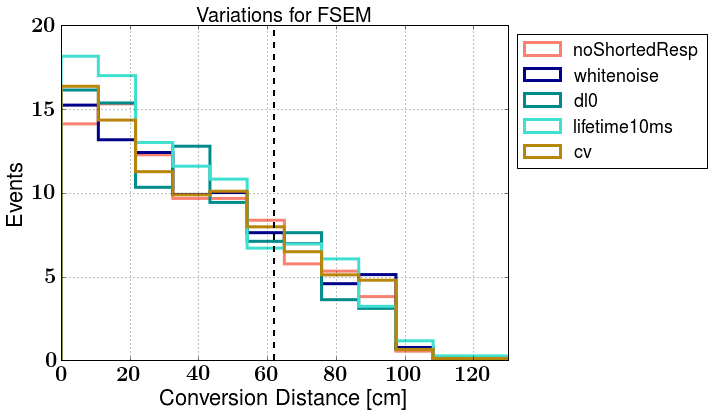

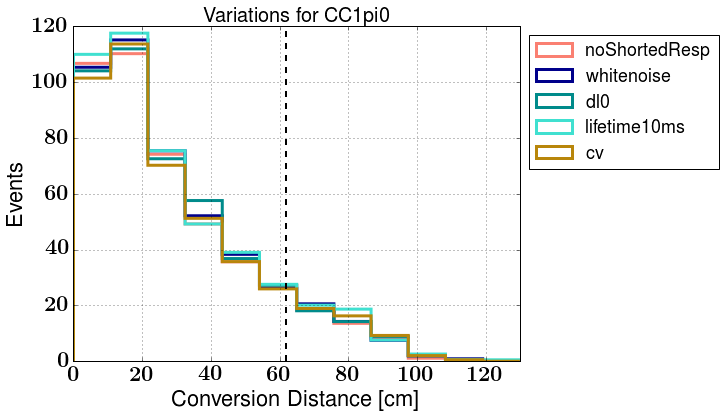

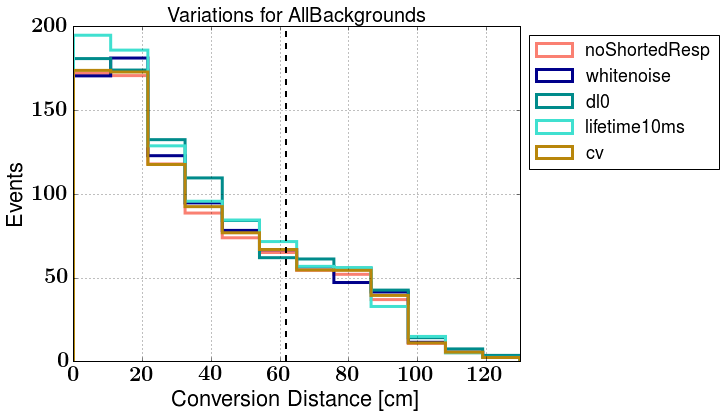

In [70]:
makeAbsNormPlots('shr_vtx_dist',0,130,nbins=12,xlabel='Conversion Distance [cm]',cut=62)
